#Imports

In [ ]:
# !pip3 install pydicom --q

In [ ]:
!pip install SimpleITK --q
!pip install -U segmentation_models --q

In [ ]:
%matplotlib inline
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler
from skimage.segmentation import active_contour, chan_vese
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import precision_score, recall_score
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model
from skimage import measure, morphology
from sklearn.metrics import make_scorer
from tqdm.notebook import tqdm as tq
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage import data, draw
import SimpleITK as sitk
import tensorflow as tf
from glob import glob
import scipy.ndimage
import pandas as pd
import numpy as np
import pickle
import math
import cv2
import sys
import csv
import os


tf.keras.utils.set_random_seed(40)

In [ ]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_shared_codes = '/content/drive/MyDrive/LCD/LUNA16/shared_codes'
sys.path.append(all_shared_codes)


## Add libraries to system path

In [ ]:
sys.path.append('/content/drive/MyDrive/LCD/LUNA16/LUNA16Challege/Vnet')

In [ ]:
sys.path.append('/content/drive/MyDrive/LCD/LUNA16/LUNA16Challege/dataprocess')

In [ ]:
sys.path.append('/content/drive/MyDrive/LCD/LUNA16/LUNA16Challege')

In [ ]:
from layer import resnet_Add
from utils import *

# Nodule Segmentation

## The 2D images approach

### Loading the data as 2D images

In [ ]:
BASE_DIR = '/content/drive/MyDrive/LCD/LUNA16/'

In [ ]:
luna_path=BASE_DIR
tr_output_img_path=BASE_DIR + "/data/train/images/"
tr_output_mask_path=BASE_DIR + "/data/train/labels/"

v_output_img_path=BASE_DIR + "/data/val/images/"
v_output_mask_path=BASE_DIR + "/data/val/labels/"

ts_output_img_path=BASE_DIR + "/data/test/images/"
ts_output_mask_path=BASE_DIR + "/data/test/labels/"

In [ ]:
def load_data(imgs, masks, imgs_path, masks_path):
  labels = []
  train_end_paths = os.listdir(imgs_path)
  masks_end_paths = os.listdir(masks_path)
  for i in tq(range(len(os.listdir(imgs_path)))):
    # img_path = imgs_path+"/"+i
    img_path = imgs_path + train_end_paths[i]
    # mask_path = masks_path + '/masks_'+img_path.split('_')[-3]
    mask_path = masks_path + masks_end_paths[i]
    labels.append(img_path.split('_')[-1])
    imgs.append(np.load(img_path ,allow_pickle=True))
    masks.append(np.load(mask_path,allow_pickle=True))

  return imgs, masks, labels

In [ ]:
imgs = []
masks = []
labels = []
imgs_test = []
masks_test = []
labels_test = []
imgs_val = []
masks_val = []
labels_val=[]
imgs, masks, labels = load_data(imgs, masks, tr_output_img_path, tr_output_mask_path)
imgs_test, masks_test, labels_test = load_data(imgs_test, masks_test, ts_output_img_path, ts_output_mask_path)
imgs_val, masks_val, labels_val = load_data(imgs_val, masks_val, v_output_img_path, v_output_mask_path)

  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/1074 [00:00<?, ?it/s]

  0%|          | 0/690 [00:00<?, ?it/s]

['0.npy', '0.npy', '1.npy', '1.npy', '1.npy', '0.npy', '0.npy', '0.npy', '0.npy', '0.npy']


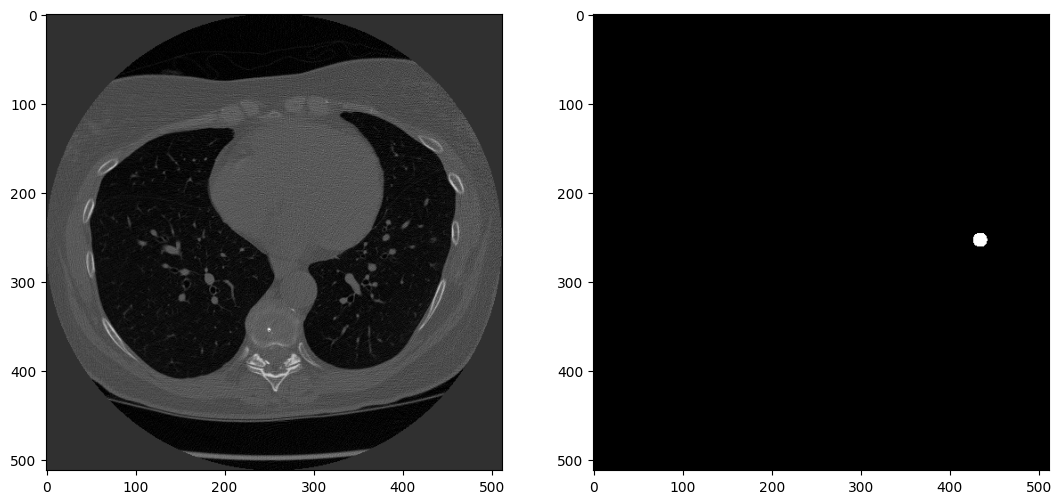

In [ ]:
print(labels_test[641:651])
plt.figure(figsize=[20,10])
plt.subplot(131)
plt.imshow(imgs_test[643],cmap='gray')
plt.subplot(132)
plt.imshow(masks_test[643],cmap='gray')
# plt.subplot(133)
# plt.imshow((imgs)*masks,cmap='gray')

### Pre-processing the data for 2D images

In [ ]:
from preprocess_2d_data import Preprocess2dData

X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []

prepro = Preprocess2dData()

X_train, y_train = prepro.preprocess(imgs ,masks)
X_test, y_test = prepro.preprocess(imgs_test, masks_test)
X_val, y_val = prepro.preprocess(imgs_val, masks_val)

X_train, y_train = prepro.expand_dimension(X_train, y_train)
X_test, y_test = prepro.expand_dimension(X_test, y_test)
X_val, y_val = prepro.expand_dimension(X_val, y_val)

y_test = prepro.make_masks_onehot2d(y_test, 2)
y_val = prepro.make_masks_onehot2d(y_val, 2)
y_train = prepro.make_masks_onehot2d(y_train, 2)

  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/1074 [00:00<?, ?it/s]

  0%|          | 0/690 [00:00<?, ?it/s]

In [ ]:
print(X_val.shape, y_val.shape)

(690, 128, 128, 1) (690, 128, 128, 2)


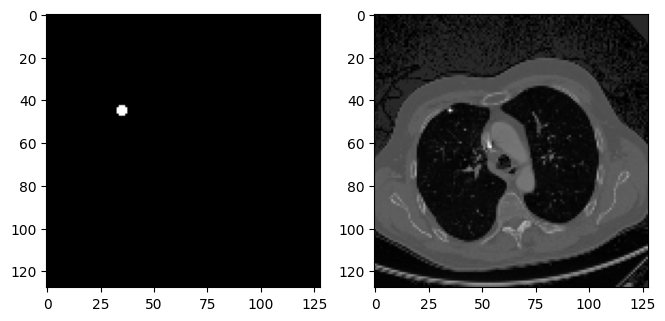

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(131)
plt.imshow(np.argmax(y_test[0], axis=-1),cmap='gray')
plt.subplot(132)
plt.imshow(X_test[0],cmap='gray')

In [ ]:
if len(X_val.shape) < 4 and len(y_val.shape) < 4:
  X_train=tf.expand_dims(X_train, axis=-1)
  y_train=tf.expand_dims(y_train, axis=-1)

print(X_val.shape, y_val.shape)

(690, 128, 128, 1) (690, 128, 128, 2)


In [ ]:
# X_test_f = X_train[1000:]
# y_test_f = y_train[1000:]

# X_train = X_train[:1000]
# y_train = y_train[:1000]

### The Unet model to segmenet 2D images

#### The below image described the architechture of the network


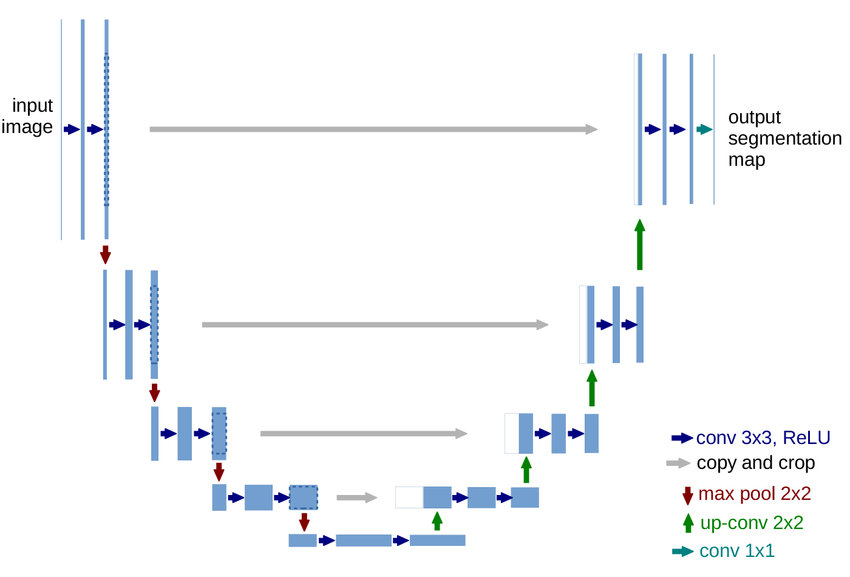

#### Shared functions

In [ ]:
import Building_blocks_Unet_1st_approach as bbu1st
import Train
import Mertics as metrics
import losses

ssim_metric = metrics.SSIMMetric()
dice = losses.dice_coef
iou = metrics.iou
surface_loss = losses.surface_loss_v2

In [ ]:
def visualize_output(output_image):
  # Convert one-hot encoded labels to grayscale image
  grayscale_image = np.argmax(output_image, axis=-1)

  # Show the grayscale image
  plt.imshow(grayscale_image, cmap='gray')
  plt.axis('off')
  plt.show()

def plot_learning_curves(history, metric, model_name):
  # Get the number of epochs
  epochs = len(history.history['loss'])
  # Plot the loss and accuracy curves
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epochs+1), history.history['loss'], label='Training loss')
  plt.plot(range(1, epochs+1), history.history['val_loss'], label='Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss curves')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(range(1, epochs+1), history.history[metric], label=f'Training {metric}')
  plt.plot(range(1, epochs+1), history.history[f'val_{metric}'], label=f'Validation {metric}')
  plt.xlabel('Epochs')
  plt.ylabel(f'{metric}')
  plt.title(f'{metric} curves')
  plt.legend()
  # Show or save the plot
  plt.savefig(f'/content/drive/MyDrive/LCD/LUNA16{model_name}.svg')
  plt.savefig(f'/content/drive/MyDrive/LCD/LUNA16{model_name}.jpg')

  plt.show()

#### build and train Unet model 1st approach

###### Create and compile the model

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
metrics = [dice, iou]
unet_model_v1 = bbu1st.create_and_compile_unet_model(loss=surface_loss, metrics=metrics, optimizer=opt)
# unet_model_v1.summary()

In [ ]:
# tf.keras.utils.plot_model(unet_model, show_shapes=True)

###### Train, predict and evaluate with the model


In [ ]:
X_train.shape

(2094, 128, 128, 1)

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 1

FILE_PATH = '/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models'
fname = os.path.join(FILE_PATH ,'unet_1st_approach_model_weights.{epoch:02d}-{val_loss:.2f}.h5')
if not os.path.isdir(FILE_PATH):
    os.makedirs(FILE_PATH)

unet_model_v1_history, unet_model_v1 = Train.train_model(model=unet_model_v1,
                                          NUM_EPOCHS=NUM_EPOCHS,
                                          BATCH_SIZE=BATCH_SIZE,
                                          fname=fname,
                                          X_train=X_train,
                                          y_train=y_train,
                                          X_test=X_test,
                                          y_test=y_test)

Epoch 1/20
2094/2094 [==============================] - 87s 32ms/step - loss: 0.0011 - dice_coef: 0.9988 - iou: 0.9955 - val_loss: 0.0012 - val_dice_coef: 0.9988 - val_iou: 0.9953
Epoch 2/20
2094/2094 [==============================] - 57s 27ms/step - loss: 0.0011 - dice_coef: 0.9989 - iou: 0.9957 - val_loss: 0.0012 - val_dice_coef: 0.9988 - val_iou: 0.9953
Epoch 3/20
2094/2094 [==============================] - 57s 27ms/step - loss: 0.0011 - dice_coef: 0.9989 - iou: 0.9957 - val_loss: 0.0012 - val_dice_coef: 0.9988 - val_iou: 0.9953
Epoch 4/20
2094/2094 [==============================] - 57s 27ms/step - loss: 0.0011 - dice_coef: 0.9989 - iou: 0.9957 - val_loss: 0.0012 - val_dice_coef: 0.9988 - val_iou: 0.9953
Epoch 5/20
2094/2094 [==============================] - 57s 27ms/step - loss: 0.0011 - dice_coef: 0.9989 - iou: 0.9957 - val_loss: 0.0012 - val_dice_coef: 0.9988 - val_iou: 0.9953
Epoch 6/20
2094/2094 [==============================] - 56s 27ms/step - loss: 0.0011 - dice_coef: 0.

In [ ]:

y_pred = Train.predict_after_train(unet_model_v1, X_val)


# Load your model
# model = tf.keras.models.load_model(model_path)

# Use your model
# y_pred = model.predict(X_test)

22/22 [==============================] - 3s 86ms/step


In [ ]:
"""
  Differences between the two cells is that one is used to predict the model after training immedietly
  the other laod the saved model then predict using it
"""

models_directory = '/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models'
model_path = models_directory + 'unet_1st_approach_model_weights.{epoch:02d}-{val_loss:.2f}.h5'

y_pred, unet_model_v1 = Train.load_model_and_predict(model=unet_model_v1,
                                                     path=model_path,
                                                     test_data=X_val)

###### Visualization

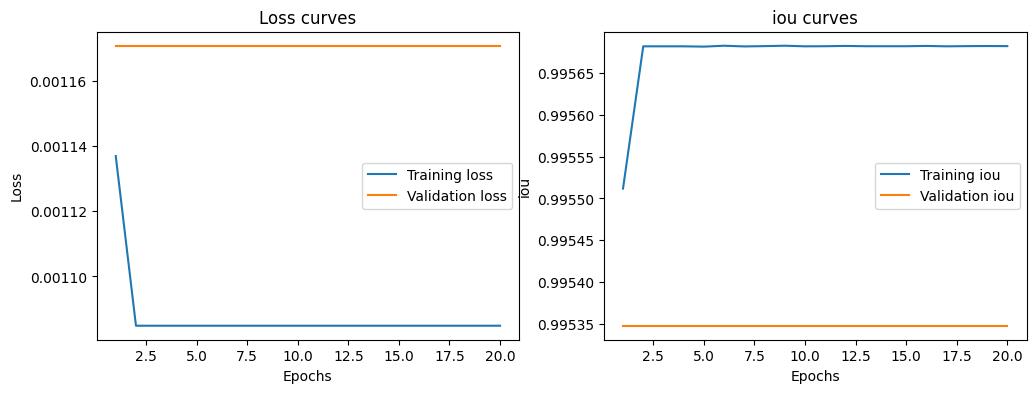

In [ ]:
plot_learning_curves(unet_model_v1_history, "iou", "u-net model with normal architecture ")

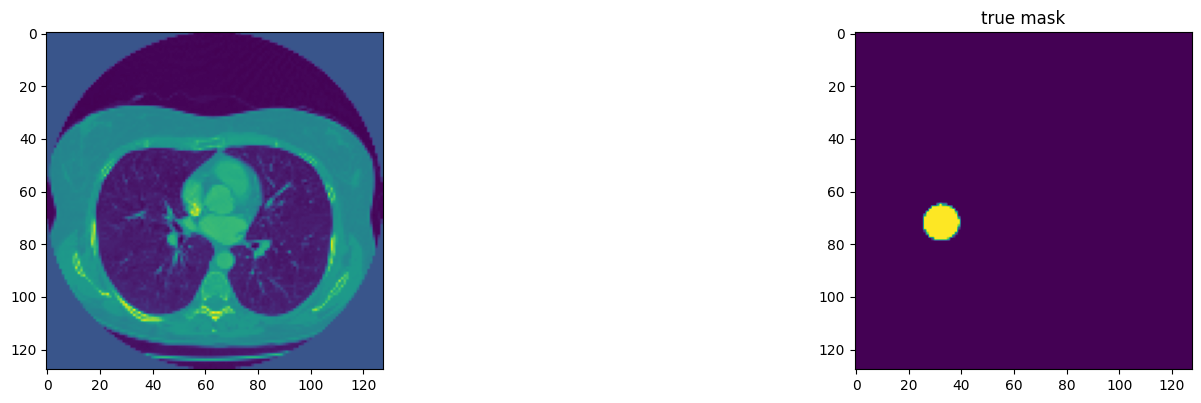

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(X_test[30])
plt.subplot(1, 4, 3)
plt.imshow(y_test[30])
plt.title('true mask')
plt.show()

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
y_pred = np.argmax(y_pred, axis=-1) # a NumPy array of shape (num_samples, height, width)
y_pred = np.expand_dims(y_pred, axis=-1) # a NumPy array of shape (num_samples, height, width, 1)
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(X_test[30])
plt.title('Input image')
plt.subplot(1, 4, 2)
plt.imshow(y_pred[110])
plt.title('Output mask')
plt.subplot(1, 4, 3)
plt.imshow(y_test[110])
plt.title('true mask')
plt.show()

#### Different approach for building the U net model

###### Create and compile the model

In [ ]:
import Building_blocks_Unet_2nd_approach as bbu2nd

loss = sm.losses.bce_dice_loss
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.OneHotMeanIoU(num_classes=2), sm.metrics.FScore(),  sm.metrics.Recall(), sm.metrics.Precision(), ssim_metric]
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

unet_model_v2 = bbu2nd.create_and_compile_unet_model(metrics=metrics, loss=loss, optimizer=opt)
# unet_model_v2.summary()

###### Train, predict and evaluate with the model

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 1

FILE_PATH = '/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models'
if not os.path.isdir(FILE_PATH ):
      os.makedirs(FILE_PATH)
fname = os.path.join(FILE_PATH ,'unet_2nd_approach_model_weights.{epoch:02d}-{val_loss:.4f}.h5')


unet_model_v2_history, unet_model_v2 = Train.train_model(model=unet_model_v2,
                                                        NUM_EPOCHS=NUM_EPOCHS,
                                                        BATCH_SIZE=BATCH_SIZE,
                                                        fname=fname,
                                                        X_train=X_train,
                                                        y_train=y_train,
                                                        X_test=X_test,
                                                        y_test=y_test)

Epoch 1/20


/content/drive/MyDrive/LCD/LUNA16/shared_codes/Mertics.py:78: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_values.append(ssim(img_true, img_pred, multichannel=True))


2094/2094 [==============================] - ETA: 0s - loss: 0.0191 - one_hot_mean_io_u: 0.4988 - f1-score: 0.5023 - recall: 0.5159 - precision: 0.5045 - ssim: 0.9331

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric SSIMMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2094/2094 [==============================] - 46s 17ms/step - loss: 0.0191 - one_hot_mean_io_u: 0.4988 - f1-score: 0.5023 - recall: 0.5159 - precision: 0.5045 - ssim: 0.9331 - val_loss: 0.0423 - val_one_hot_mean_io_u: 0.4988 - val_f1-score: 0.4945 - val_recall: 0.5191 - val_precision: 0.5011 - val_ssim: 0.6777
Epoch 2/20
2094/2094 [==============================] - 37s 17ms/step - loss: 0.0130 - one_hot_mean_io_u: 0.4989 - f1-score: 0.5054 - recall: 0.5186 - precision: 0.5088 - ssim: 0.9617 - val_loss: 0.0205 - val_one_hot_mean_io_u: 0.4988 - val_f1-score: 0.5037 - val_recall: 0.5290 - val_precision: 0.5044 - val_ssim: 0.8522
Epoch 3/20
2094/2094 [==============================] - 36s 17ms/step - loss: 0.0120 - one_hot_mean_io_u: 0.4989 - f1-score: 0.5080 - recall: 0.5214 - precision: 0.5132 - ssim: 0.9642 - val_loss: 0.0256 - val_one_hot_mean_io_u: 0.4988 - val_f1-score: 0.5049 - val_recall: 0.5505 - val_precision: 0.5056 - val_ssim: 0.7928
Epoch 4/20
2094/2094 [=======================

In [ ]:
y_pred = Train.predict_after_train(unet_model_v2, X_val)

22/22 [==============================] - 1s 20ms/step


In [ ]:
"""
  Differences between the two cells is that one is used to predict the model after training immedietly
  the other laod the saved model then predict using it.

  About the paths of the models I updated the names
  of the model that should be saved, but I have used different names before so I kept the old names
  in order to use them
"""

models_directory = '/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models'
model_path = models_directory + 'unet_2nd_approach_model_weights.{epoch:02d}-{val_loss:.2f}.h5'

path = "/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models/weights.18-0.0079.h5"

y_pred, unet_model_v2 = Train.load_model_and_predict(model=unet_model_v2,
                                                     path=model_path,
                                                     test_data=X_val)

In [ ]:
# unetmodel1.load_weights("/content/drive/MyDrive/LCD/Obada/segmentaion models/weights.62-0.02.h5")
# unetmodel1.load_weights("/content/drive/MyDrive/LCD/Obada/segmentaion models/weights.10-0.012.h5")
# unetmodel1.load_weights("/content/drive/MyDrive/LCD/Obada/segmentaion models/weights.18-0.0079.h5")


In [ ]:
path = "/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models/weights.18-0.0079.h5"


In [ ]:
score = unet_model_v2.evaluate(X_val, y_val)

 1/22 [>.............................] - ETA: 14s - loss: 0.0096 - one_hot_mean_io_u: 0.7367 - f1-score: 0.7891 - recall: 0.7240 - precision: 0.9082 - ssim: 0.9885

<ipython-input-22-85867694652b>:24: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_values.append(ssim(img_true, img_pred, multichannel=True))


22/22 [==============================] - 4s 145ms/step - loss: 0.0087 - one_hot_mean_io_u: 0.6761 - f1-score: 0.7207 - recall: 0.6947 - precision: 0.7672 - ssim: 0.9860


###### Visualization

In [ ]:
print(labels_val[30:50])

['0.npy', '0.npy', '0.npy', '1.npy', '1.npy', '1.npy', '1.npy', '1.npy', '1.npy', '1.npy', '1.npy', '1.npy', '1.npy', '1.npy', '1.npy', '1.npy', '1.npy', '1.npy', '0.npy', '0.npy']


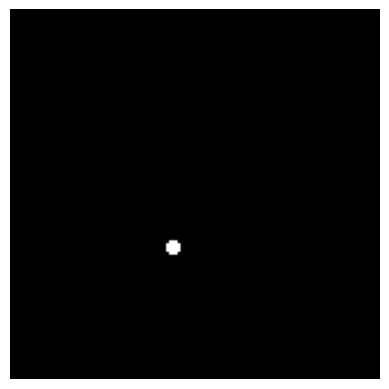

In [ ]:
# Visualize the output image
visualize_output(y_pred[176])

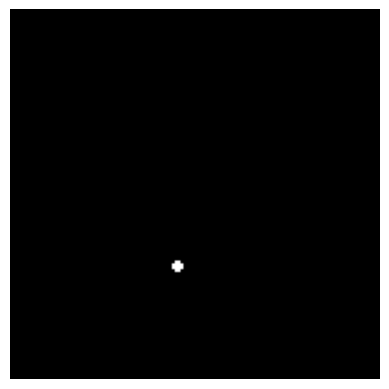

In [ ]:
visualize_output(y_val[176])

In [ ]:
y_pred_1 = np.argmax(y_pred, axis=-1)
# y_pred_1 = np.expand_dims(y_pred_1, axis=-1)

y_test_1 = np.argmax(y_val, axis=-1)
# y_test_1 = np.expand_dims(y_test_1, axis=-1)

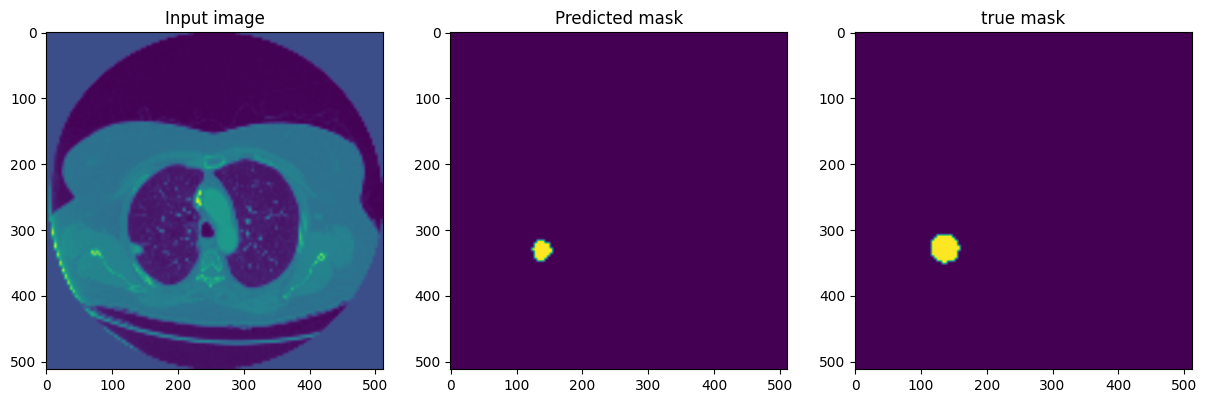

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

target_size = (512, 512)
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
resized_image_val = cv2.resize(X_val[48], target_size)
plt.imshow(resized_image_val)
plt.title('Input image')
plt.subplot(1, 4, 2)
resized_image_pred = cv2.resize(y_pred_1[48].astype(np.float32), dsize=target_size)

plt.imshow(resized_image_pred)
plt.title('Predicted mask')
plt.subplot(1, 4, 3)
resized_image_test = cv2.resize(y_test_1[48].astype(np.float32), dsize=target_size)
plt.imshow(resized_image_test)
plt.title('true mask')
plt.show()

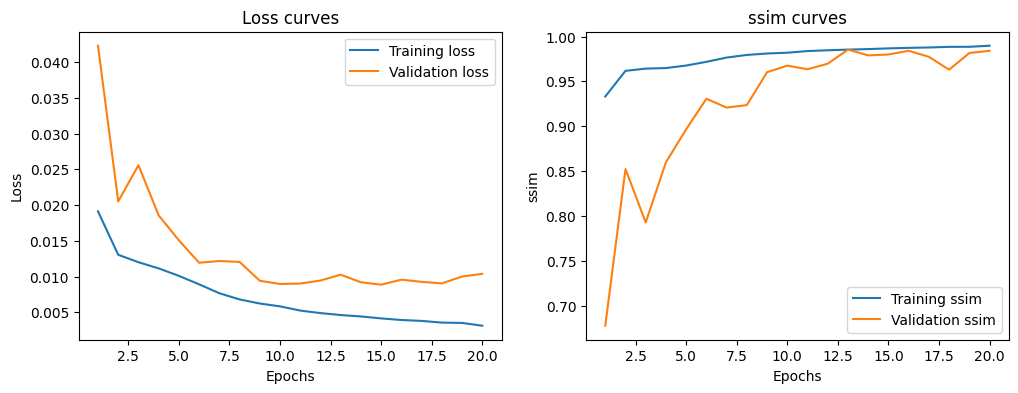

In [ ]:
plot_learning_curves(unet_model_v2_history, "ssim", "normal U-net model")

#### Different approach to build the U net model with a pretrained encoder "resnet34"

###### Create and compile the model

In [ ]:
from keras import backend as K
import Building_blocks_Unet_3rd_approach as bbu3rd

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=2), ssim_metric, sm.metrics.Recall(), sm.metrics.Precision()]

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

unet_model_v3 = bbu3rd.create_and_compile_unet_model(metrics=metrics, loss=total_loss, optimizer=opt)
# unet_model_v3.summary()

85521592/85521592 [==============================] - 2s 0us/step


###### Train, predict and evaluate with the model


In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 1

FILE_PATH = '/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models'
if not os.path.isdir(FILE_PATH ):
      os.makedirs(FILE_PATH)
fname = os.path.join(FILE_PATH ,'unet_3rd_approach_model_weights.{epoch:02d}-{val_loss:.4f}.h5')

# preprocess input
X_train_prepr = tf.convert_to_tensor(X_train)
X_train_prepr = tf.image.grayscale_to_rgb(X_train_prepr)
print(X_train_prepr.shape)
X_test_prepr = tf.convert_to_tensor(X_test)
X_test_prepr = tf.image.grayscale_to_rgb(X_test_prepr)
X_train_prepr = preprocess_input(X_train_prepr)
X_test_prepr = preprocess_input(X_test_prepr)
print(X_test_prepr.shape)


unet_model_v3_history, unet_model_v3 = Train.train_model(model=unet_model_v3,
                                                        NUM_EPOCHS=NUM_EPOCHS,
                                                        BATCH_SIZE=BATCH_SIZE,
                                                        fname=fname,
                                                        X_train=X_train_prepr,
                                                        y_train=y_train,
                                                        X_test=X_test_prepr,
                                                        y_test=y_test)

(2094, 128, 128, 3)
(1074, 128, 128, 3)
Epoch 1/100


/content/drive/MyDrive/LCD/LUNA16/shared_codes/Mertics.py:78: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_values.append(ssim(img_true, img_pred, multichannel=True))


2093/2094 [============================>.] - ETA: 0s - loss: 0.4670 - one_hot_mean_io_u: 0.5186 - ssim: 0.7981 - recall: 0.5893 - precision: 0.5399

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric SSIMMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2094/2094 [==============================] - 116s 37ms/step - loss: 0.4668 - one_hot_mean_io_u: 0.5186 - ssim: 0.7982 - recall: 0.5895 - precision: 0.5401 - val_loss: 0.3759 - val_one_hot_mean_io_u: 0.6184 - val_ssim: 0.9853 - val_recall: 0.6773 - val_precision: 0.6296
Epoch 2/100
2094/2094 [==============================] - 76s 36ms/step - loss: 0.3273 - one_hot_mean_io_u: 0.6395 - ssim: 0.9858 - recall: 0.7247 - precision: 0.6823 - val_loss: 0.3397 - val_one_hot_mean_io_u: 0.6507 - val_ssim: 0.9872 - val_recall: 0.7097 - val_precision: 0.6731
Epoch 3/100
2094/2094 [==============================] - 75s 36ms/step - loss: 0.2682 - one_hot_mean_io_u: 0.7013 - ssim: 0.9893 - recall: 0.7711 - precision: 0.7398 - val_loss: 0.3429 - val_one_hot_mean_io_u: 0.6529 - val_ssim: 0.9901 - val_recall: 0.6755 - val_precision: 0.6998
Epoch 4/100
2094/2094 [==============================] - 75s 36ms/step - loss: 0.2417 - one_hot_mean_io_u: 0.7270 - ssim: 0.9903 - recall: 0.7950 - precision: 0.7628 - 

In [ ]:
X_val_prepr = tf.convert_to_tensor(X_val)
X_val_prepr = tf.image.grayscale_to_rgb(X_val_prepr)
X_val_prepr = preprocess_input(X_val_prepr)


y_pred = Train.predict_after_train(unet_model_v3, X_val_prepr)

22/22 [==============================] - 2s 33ms/step


In [ ]:
"""
  Differences between the two cells is that one is used to predict the model after training immedietly
  the other laod the saved model then predict using it.

  About the paths of the models I updated the names
  of the model that should be saved, but I have used different names before so I kept the old names
  in order to use them
"""

models_directory = '/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models'
model_path = models_directory + 'unet_3rd_approach_model_weights.{epoch:02d}-{val_loss:.2f}.h5'

path = "/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models/weights.18-0.0079.h5"

X_val_prepr = preprocess_input(X_val)
X_val_prepr = tf.convert_to_tensor(X_val_prepr)
X_val_prepr = tf.image.grayscale_to_rgb(X_val_prepr)

y_pred, unet_model_v3 = Train.load_model_and_predict(model=unet_model_v3,
                                                     path=model_path,
                                                     test_data=X_val_prepr)

###### Visualization

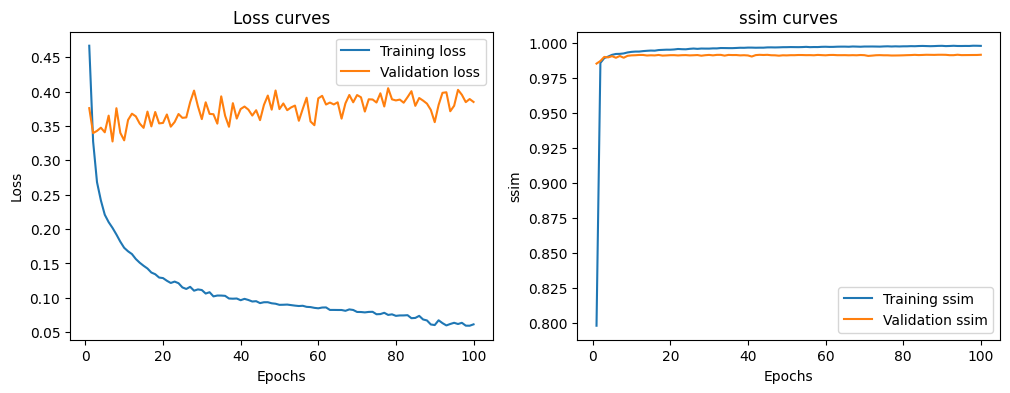

In [ ]:
plot_learning_curves(unet_model_v3_history, "ssim", "model_with_pretrained_encoder 'resnet34' ")

In [ ]:


# y_predicted = model_resnet_backbone.predict(X_val_prepr)

22/22 [==============================] - 4s 81ms/step


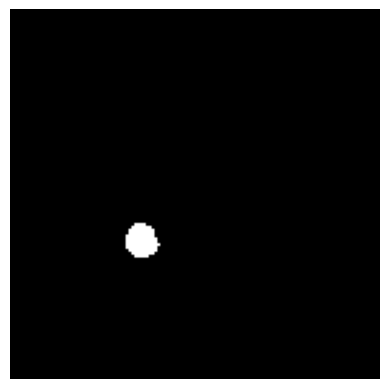

In [ ]:
visualize_output(y_predicted[54])

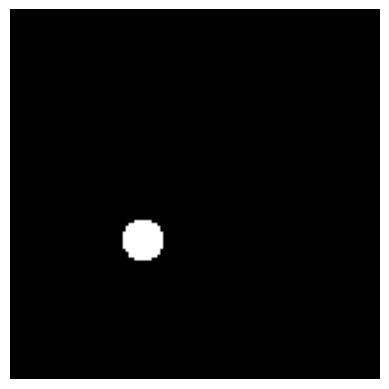

In [ ]:
visualize_output(y_val[54])

In [ ]:
unet_model_v3.evaluate(X_val_prepr, y_val)

 1/22 [>.............................] - ETA: 4s - loss: 0.1458 - one_hot_mean_io_u_1: 0.7781 - ssim: 0.9908 - recall: 0.7937 - precision: 0.9582

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric SSIMMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
<ipython-input-22-85867694652b>:24: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_values.append(ssim(img_true, img_pred, multichannel=True))


22/22 [==============================] - 4s 177ms/step - loss: 0.2390 - one_hot_mean_io_u_1: 0.6939 - ssim: 0.9913 - recall: 0.7090 - precision: 0.8902


[0.2390429526567459,
 0.6938968896865845,
 0.9912606477737427,
 0.7089616060256958,
 0.8902497887611389]

#### Different approach to build the U net model with a pretrained encoder "MobileNetV2"

###### Create and compile the model

In [ ]:
import Building_blocks_Unet_4th_approach as bbu4th

metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=2), ssim_metric, sm.metrics.Recall(), sm.metrics.Precision()]

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

opt = tf.keras.optimizers.Nadam(1e-4)

unet_model_v4 = bbu4th.create_and_compile_unet_model(metrics=metrics, loss=total_loss, optimizer=opt)
# unet_model_v3.summary()

###### Train, predict and evaluate with the model


In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 1

FILE_PATH = '/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models'
if not os.path.isdir(FILE_PATH):
      os.makedirs(FILE_PATH)
fname = os.path.join(FILE_PATH ,'unet_4th_approach_model_weights.{epoch:02d}-{val_loss:.4f}.h5')

X_train_prepr = tf.convert_to_tensor(X_train)
X_train_prepr = tf.image.grayscale_to_rgb(X_train_prepr)
print(X_train_prepr.shape)
X_test_prepr = tf.convert_to_tensor(X_test)
X_test_prepr = tf.image.grayscale_to_rgb(X_test_prepr)
print(X_test_prepr.shape)


unet_model_v4_history, unet_model_v4 = Train.train_model(model=unet_model_v4,
                                                        NUM_EPOCHS=NUM_EPOCHS,
                                                        BATCH_SIZE=BATCH_SIZE,
                                                        fname=fname,
                                                        X_train=X_train_prepr,
                                                        y_train=y_train,
                                                        X_test=X_test_prepr,
                                                        y_test=y_test)

(2094, 128, 128, 3)
(1074, 128, 128, 3)
Epoch 1/100


/content/drive/MyDrive/LCD/LUNA16/shared_codes/Mertics.py:78: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_values.append(ssim(img_true, img_pred, multichannel=True))


2094/2094 [==============================] - ETA: 0s - loss: 0.4258 - one_hot_mean_io_u: 0.5244 - ssim: 0.8052 - recall: 0.6688 - precision: 0.5784

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric SSIMMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2094/2094 [==============================] - 107s 34ms/step - loss: 0.4258 - one_hot_mean_io_u: 0.5244 - ssim: 0.8052 - recall: 0.6688 - precision: 0.5784 - val_loss: 0.3759 - val_one_hot_mean_io_u: 0.5892 - val_ssim: 0.9675 - val_recall: 0.7641 - val_precision: 0.6047
Epoch 2/100
2094/2094 [==============================] - 70s 33ms/step - loss: 0.2901 - one_hot_mean_io_u: 0.6748 - ssim: 0.9875 - recall: 0.7591 - precision: 0.7217 - val_loss: 0.3186 - val_one_hot_mean_io_u: 0.6472 - val_ssim: 0.9872 - val_recall: 0.7181 - val_precision: 0.7064
Epoch 3/100
2094/2094 [==============================] - 68s 33ms/step - loss: 0.2491 - one_hot_mean_io_u: 0.7089 - ssim: 0.9900 - recall: 0.7922 - precision: 0.7640 - val_loss: 0.3681 - val_one_hot_mean_io_u: 0.6063 - val_ssim: 0.9908 - val_recall: 0.6342 - val_precision: 0.7068
Epoch 4/100
2094/2094 [==============================] - 69s 33ms/step - loss: 0.2239 - one_hot_mean_io_u: 0.7334 - ssim: 0.9914 - recall: 0.8107 - precision: 0.7904 - 

In [ ]:
X_val_prepr = tf.convert_to_tensor(X_val)
X_val_prepr = tf.image.grayscale_to_rgb(X_val_prepr)

y_pred = Train.predict_after_train(unet_model_v4, X_val_prepr)

In [ ]:
"""
  Differences between the two cells is that one is used to predict the model after training immedietly
  the other laod the saved model then predict using it.

  About the paths of the models I updated the names
  of the model that should be saved, but I have used different names before so I kept the old names
  in order to use them
"""

models_directory = '/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models'
model_path = models_directory + 'unet_4th_approach_model_weights.{epoch:02d}-{val_loss:.2f}.h5'

path = "/content/drive/MyDrive/LCD/Obada/Segmentation Models/segmentaion models/weights.18-0.0079.h5"

X_val_prepr = tf.convert_to_tensor(X_val_prepr)
X_val_prepr = tf.image.grayscale_to_rgb(X_val_prepr)

y_pred, unet_model_v4 = Train.load_model_and_predict(model=unet_model_v4,
                                                     path=model_path,
                                                     test_data=X_val_prepr)

###### Visualization

In [ ]:
plot_learning_curves(unet_model_v4_history, "ssim", "model_with_pretrained_encoder 'MobileNetV2' ")

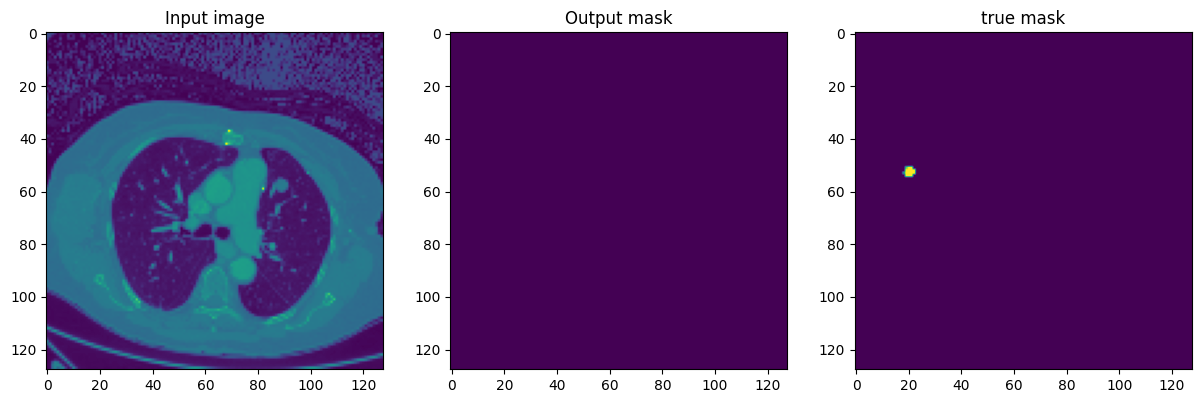

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
y_pred = np.argmax(y_pred, axis=-1) # a NumPy array of shape (num_samples, height, width)
y_pred = np.expand_dims(y_pred, axis=-1) # a NumPy array of shape (num_samples, height, width, 1)
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(X_test[101])
plt.title('Input image')
plt.subplot(1, 4, 2)
plt.imshow(y_pred[101])
plt.title('Output mask')
plt.subplot(1, 4, 3)
plt.imshow(y_test[101])
plt.title('true mask')
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

### Optimize segmentation model results

The optimization process contains two experiments:

before applying these experiments I captured the area of the tumor that match the segmented plcae from the mask then we can either keep the full image or crop it,

1.   Apply active contour
2.   Apply thresholding segmentation

The process of the work is:
1.   Use the *extract_roi_full_image* function
2.   Apply thresholding segmentation
3.   Use the *extract_roi_cropped_image* function
4.   Pass the results to feature extractor




In [ ]:
def find_circle_properties(mask):

    # Find contours in the image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter the contours to find the circle contour
    circle_contour = None
    for contour in contours:
        # Filter based on contour area or other characteristics
        area = cv2.contourArea(contour)
        if area > min_area_threshold and area < max_area_threshold:
            circle_contour = contour
            break

    if circle_contour is None:
        print("No circle contour found in the image.")
        return None

    # Calculate the moments of the circle contour
    moments = cv2.moments(circle_contour)

    # Calculate the center of the circle
    center_x = moments['m10'] / moments['m00']
    center_y = moments['m01'] / moments['m00']
    center = (center_x, center_y)

    # Calculate the diameter of the circle
    distances = np.linalg.norm(circle_contour - center, axis=2)
    diameter = np.max(distances)

    return center, diameter

In [ ]:
def extract_roi_cropped_image(image, mask):
    """
    Extracts and crops the region of interest (ROI) from an image based on the corresponding mask.

    Arguments:
        image: Input image.
        mask: Mask corresponding to the ROI.

    Returns:
        Cropped ROI image.
    """
    # Convert mask to binary (0 and 255)
    mask = np.uint8(mask == 1)

    # Find contours of the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contours[0])

    # Crop the image based on the bounding box
    roi_image = image[y:y+h, x:x+w]

    return roi_image, (x, y, w, h)

In [ ]:
def extract_roi_full_image(image, mask):
    """
    Extracts the region of interest (ROI) from an image based on the corresponding mask.

    Arguments:
        image: Input image.
        mask: Mask corresponding to the ROI.

    Returns:
        ROI image.
    """
    # Convert mask to binary (0 and 255)
    mask = np.uint8(mask == 1)

    # Apply the mask to the image
    roi_image = cv2.bitwise_and(image, image, mask=mask)

    return roi_image

In [ ]:
target_size = (512, 512)
resized_image_pred = cv2.resize(y_pred_1[176].astype(np.float32), dsize=target_size)
resized_image_val = cv2.resize(X_val[176], target_size)


In [ ]:
roi_image, (x, y, w, h) = extract_roi_cropped_image(resized_image_val, resized_image_pred)
roi_image_org = extract_roi_full_image(resized_image_val, resized_image_pred)

Text(0.5, 1.0, 'Output mask')

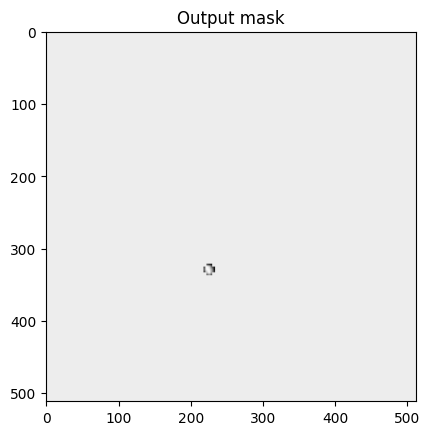

In [ ]:
# plt.imshow(np.uint8(y_pred_1[213] == 1), cmap='gray')
plt.imshow(roi_image_org, cmap='gray')
plt.title('Output mask')

In [ ]:
# mask = np.uint8(y_pred_1[213] == 1)
indices = np.where(y_pred_1[213])

print(len(indices[0]))

138


In [ ]:
pixels_0_255 = (roi_image_org * 255).astype(np.uint8)

Text(0.5, 1.0, 'Output mask')

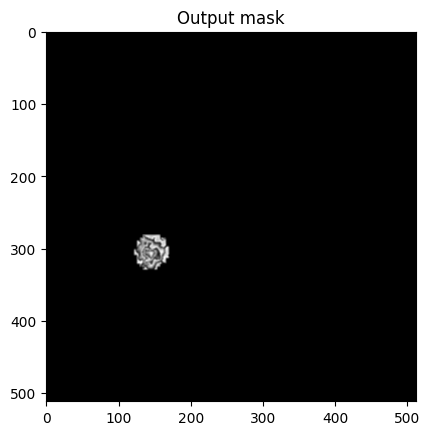

In [ ]:
blurred_image = cv2.GaussianBlur(pixels_0_255, (3, 3), 5)
plt.imshow(blurred_image, cmap='gray')
plt.title('Output mask')

In [ ]:
# mask = np.uint8(blurred_image == 1)
indices = np.where(blurred_image)

print(len(indices[0]))

2004


In [ ]:
if roi_image_org.dtype != np.uint8:
    grayscale = roi_image_org.astype(np.uint8)

# # Calculate the threshold value.
threshold = cv2.adaptiveThreshold(
    grayscale, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# Apply the threshold to the image.
# thresholded = cv2.threshold(grayscale, int(threshold), 255, cv2.THRESH_BINARY)[0]

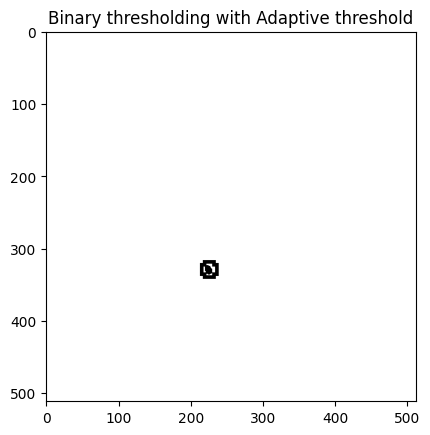

66714375


In [ ]:
plt.imshow(threshold, cmap='gray')
plt.title('Binary thresholding with Adaptive threshold')
plt.savefig("Binary thresholding with Adaptive threshold.jpg")
plt.savefig("Binary thresholding with Adaptive threshold.svg")
plt.show()
print(np.sum(threshold))

In [ ]:
threshold_otsu = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# Apply the threshold to the image.
thresholded = cv2.threshold(threshold_otsu, 0, 255, cv2.THRESH_BINARY)[1]

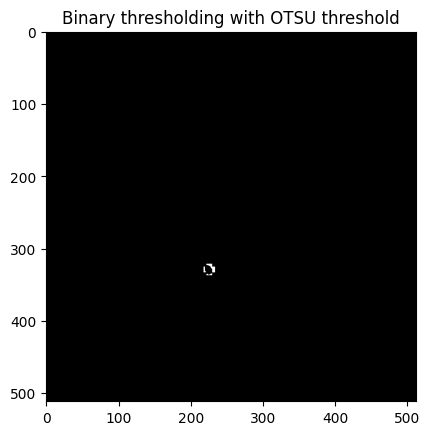

23715


In [ ]:
plt.imshow(thresholded, cmap='gray')
plt.title('Binary thresholding with OTSU threshold')
plt.savefig("Binary thresholding with OTSU threshold.jpg")
plt.savefig("Binary thresholding with OTSU threshold.svg")
plt.show()
print(np.sum(thresholded))

In [ ]:
def canny_edge_detection(image):
  """Applies Canny edge detection to an image."""

  # Check the image type.
  if image.dtype != np.uint8:
    image = image.astype(np.uint8)

  # Calculate the threshold values.
  low_threshold = 50
  high_threshold = 150

  # Apply Canny edge detection.
  edges = cv2.Canny(image, low_threshold, high_threshold)

  return edges

edges = canny_edge_detection(roi_image_org)

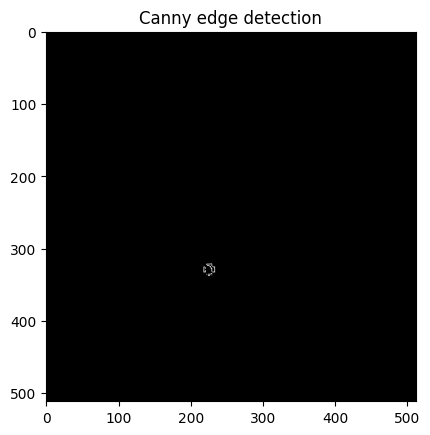

16320


In [ ]:
plt.imshow(edges, cmap='gray')
plt.title('Canny edge detection')
plt.savefig("Canny edge detection.jpg")
plt.savefig("Canny edge detection.svg")
plt.show()
print(np.sum(edges))

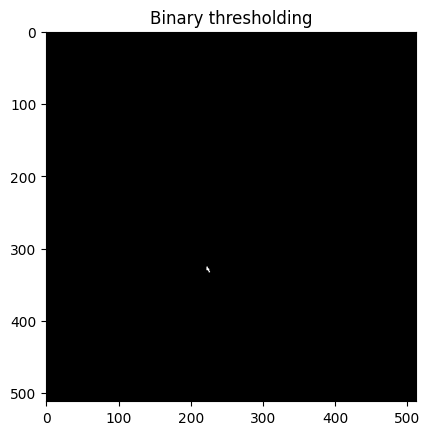

21.0


In [ ]:
# Apply binary thresholding
threshold_value = 10  # Threshold value to separate foreground and background
_, binary_image = cv2.threshold(roi_image_org*255., threshold_value, 1., cv2.THRESH_BINARY)

plt.imshow(binary_image, cmap='gray')
plt.title('Binary thresholding')
plt.savefig("Binary thresholding.jpg")
plt.savefig("Binary thresholding.svg")

plt.show()
print(np.sum(binary_image))

In [ ]:
"""
  In this cell I am summing the pixels to make sure that the segmented area
  shrinked to the mass
"""

np.sum(resized_image_pred)

992.0

In [ ]:
roi_image_org_new = extract_roi_full_image(resized_image_val, binary_image)
roi_image_cropped_new, (x_new, y_new, h_new, w_new) = extract_roi_cropped_image(resized_image_val, binary_image)


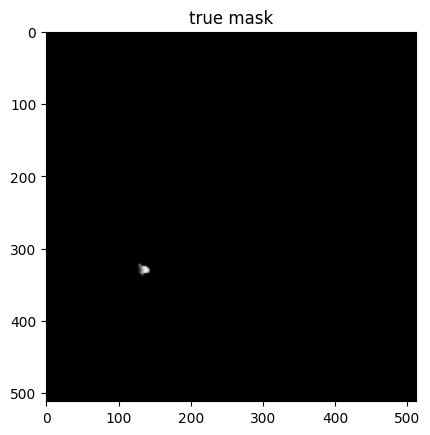

In [ ]:
plt.imshow((roi_image_org_new), cmap='gray')
plt.title('true mask')
plt.show()

In [ ]:
x_val_squeezed = np.squeeze(X_val[213], axis=-1)
roi_image_expanded = np.expand_dims(roi_image_org, axis=-1)
roi_image_squeezed = np.squeeze(roi_image, axis=-1)


(128, 128)

In [ ]:
target_size = (512, 512)
resized_image_pred_213 = cv2.resize(y_pred_1[213].astype(np.float32), dsize=target_size)
resized_image_val_213 = cv2.resize(X_val[213], target_size)

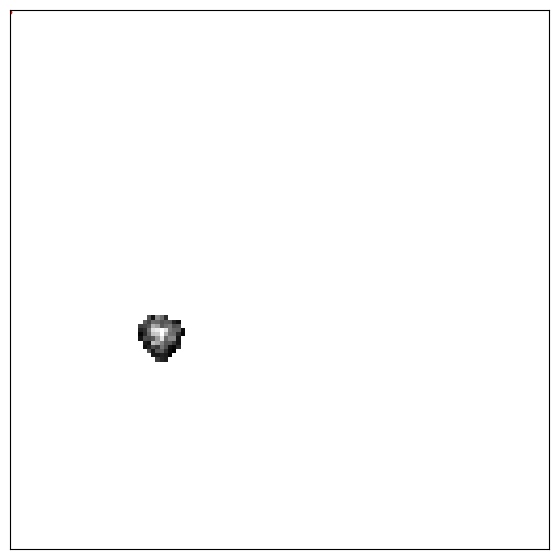

In [ ]:
# img = data.astronaut()
# img = rgb2gray(roi_image)

s = np.linspace(0, 2*np.pi, 400)
r = 100 + 100*np.sin(s)
c = 220 + 100*np.cos(s)
snake = active_contour(gaussian(roi_image_org, 3, preserve_range=False),
                       roi_image_squeezed, alpha=0.015, beta=10, gamma=0.001)
# Computing the Chan VESE segmentation technique
# chanvese_gray_astronaut = chan_vese(roi_image,
#                                     max_iter=100,
#                                     extended_output=True)

fig, ax = plt.subplots(figsize=(7, 7))
# Plotting the segmented - 100 iterations image
# ax.imshow(snake, cmap="gray")
# title = "Chan-Vese segmentation - {} iterations".format(len(chanvese_gray_astronaut[2]))

# ax.set_title(title)

ax.imshow(roi_image_org, cmap=plt.cm.gray)
ax.plot(roi_image_squeezed[:, 1], roi_image_squeezed[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, roi_image_org.shape[1], roi_image_org.shape[0], 0])

plt.show()

<ipython-input-78-9f5cbe84b138>:21: FutureWarning: `max_iterations` is a deprecated argument name for `active_contour`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  contour = active_contour(resized_image_val_213, snake_init, alpha, beta, gamma, coordinates='rc', max_iterations=iterations)


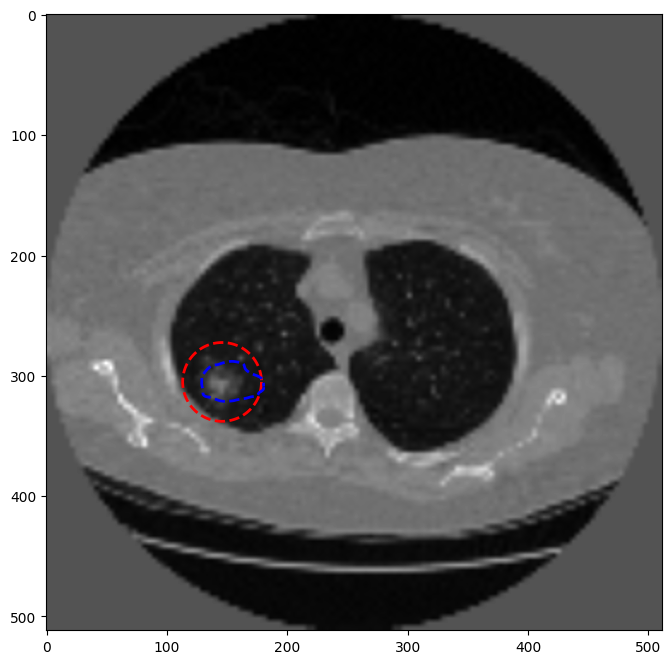

In [ ]:
"""
  IN this cell I am just trying some random values for the parameters
"""


y, x = np.nonzero(resized_image_pred)

center = np.mean(x), np.mean(y)
radius = np.sqrt((x - center[0])**2 + (y - center[1])**2).max()

alpha = 0.09  # Controls elasticity
beta = 0.01  # Controls rigidity
gamma = 0.1  # Controls attraction to image edges
iterations = 100  # Number of iterations

theta = np.linspace(0, 2 * np.pi, 100)
x_init = center[0] + radius * np.cos(theta)
y_init = center[1] + radius * np.sin(theta)
snake_init = np.array([x_init, y_init]).T

contour = active_contour(resized_image_val_213, snake_init, alpha, beta, gamma, coordinates='rc', max_iterations=iterations)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(resized_image_val_213, cmap='gray')
ax.plot(x_init, y_init, '--r', lw=2)
ax.plot(contour[:, 0], contour[:, 1], '--b', lw=2)
plt.show()

<ipython-input-141-8a9c2ec8d609>:50: FutureWarning: `max_iterations` is a deprecated argument name for `active_contour`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  contour = active_contour(resized_image_val_resized, snake_init, alpha, beta, gamma, coordinates='rc', max_iterations=iterations)
<ipython-input-141-8a9c2ec8d609>:73: FutureWarning: `max_iterations` is a deprecated argument name for `active_contour`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  best_contour = active_contour(resized_image_val_resized, snake_init, best_alpha, best_beta, best_gamma, coordinates='rc', max_iterations=best_iterations)


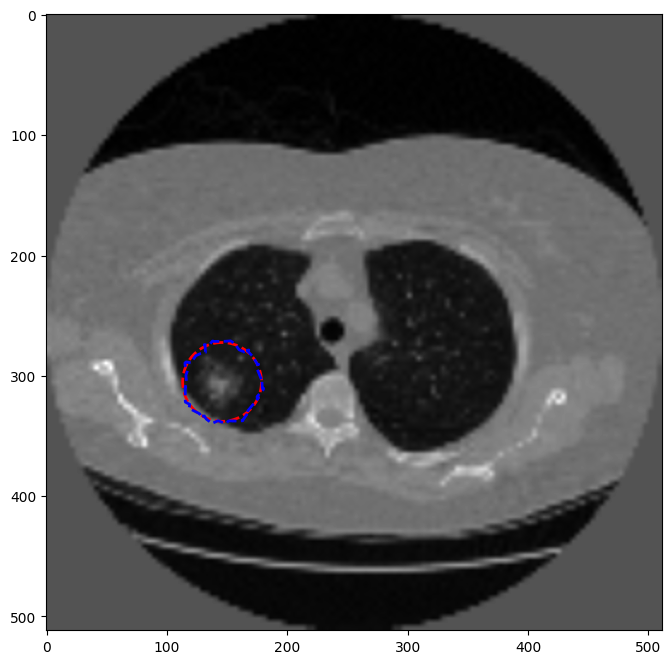

Best Parameters: {'alpha': 0.001, 'beta': 0.0001, 'gamma': 0.001, 'max_iterations': 50}
Best Score: 0.0


In [ ]:
"""
  IN this cell I have used the same concept that GridSearchCV has, which I
  initialized multiple values for the active contour's parameters then create
  a function to measure the IOU of the output image from the active contour with
  the original image to find the prefect pack of the parameters.

  The thing is if we can see the prefect pack didn't create that good result,
  it's close to the original.
"""


def contour_accuracy(y_true, y_pred):
    y_true_resized = resize(y_true, y_pred.shape, anti_aliasing=True) > 0.5
    intersection = np.logical_and(y_true_resized, y_pred)
    union = np.logical_or(y_true_resized, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

y, x = np.nonzero(resized_image_pred_213)

center = np.mean(x), np.mean(y)
radius = np.sqrt((x - center[0])**2 + (y - center[1])**2).max()

alpha = 0.1  # Controls elasticity
beta = 0.001  # Controls rigidity
gamma = 0.1  # Controls attraction to image edges
iterations = 250  # Number of iterations

theta = np.linspace(0, 2 * np.pi, 100)
x_init = center[0] + radius * np.cos(theta)
y_init = center[1] + radius * np.sin(theta)
snake_init = np.array([x_init, y_init]).T

resized_image_val_resized = resize(resized_image_val_213, resized_image_pred.shape, anti_aliasing=True)

best_score = -np.inf
alpha_range = [0.001, 0.01, 0.1, 1.0]
beta_range = [0.0001, 0.001, 0.01, 0.1]
gamma_range = [0.001, 0.01, 0.1, 1.0]
iterations_range = [50, 100, 250, 500]

for alpha in alpha_range:
    for beta in beta_range:
        for gamma in gamma_range:
            for iterations in iterations_range:
                contour = active_contour(resized_image_val_resized, snake_init, alpha, beta, gamma, coordinates='rc', max_iterations=iterations)

                accuracy = contour_accuracy(resized_image_pred, contour)

                if accuracy > best_score:
                    best_score = accuracy
                    best_params = {'alpha': alpha, 'beta': beta, 'gamma': gamma, 'max_iterations': iterations}

best_alpha = best_params['alpha']
best_beta = best_params['beta']
best_gamma = best_params['gamma']
best_iterations = best_params['max_iterations']

theta = np.linspace(0, 2 * np.pi, 100)
x_init = center[0] + radius * np.cos(theta)
y_init = center[1] + radius * np.sin(theta)
snake_init = np.array([x_init, y_init]).T

best_contour = active_contour(resized_image_val_resized, snake_init, best_alpha, best_beta, best_gamma, coordinates='rc', max_iterations=best_iterations)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(resized_image_val_resized, cmap='gray')
ax.plot(x_init, y_init, '--r', lw=2)
ax.plot(best_contour[:, 0], best_contour[:, 1], '--b', lw=2)
plt.show()

print("Best Parameters:", best_params)
print("Best Score:", best_score)


## The 3D images approach

### Data

#### Create sample 3d data to test the model on it

##### Create the data

In [ ]:
# Define the dimensions of the 3D dataset
width, height, depth, channels = 96, 96, 16, 1
def create_3d_imgs_with_shapes_inside(width=96, height=96, depth=16, channels=1, num_objects=1, object_size=10):
  # Generate empty 3D data and mask arrays
  data = np.random.randint(1, 150, size=(width, height, depth, channels))
  mask = np.zeros((width, height, depth, channels), dtype=np.uint8)

  # Generate small cube-shaped objects within the 3D dataset
  for _ in range(num_objects):
    x = np.random.randint(object_size, width - object_size)
    y = np.random.randint(object_size, height - object_size)
    z = np.random.randint(object_size // 2, depth - object_size // 2)
    data[x-object_size:x+object_size, y-object_size:y+object_size, z-object_size:z+object_size, :] = 255
    mask[x-object_size:x+object_size, y-object_size:y+object_size, z-object_size:z+object_size, :] = 1

  return data, mask

def visualize(data, num_slices):
  # Visualize each slice of the generated 3D data and mask
  num_slices = min(16, depth)
  fig, axes = plt.subplots(4, 4, figsize=(12, 12))
  for i, ax in enumerate(axes.flat):
    if i < num_slices:
      slice_idx = i * (depth // num_slices)
      ax.imshow(data[:, :, slice_idx, 0], cmap='gray')
      ax.axis('off')
      ax.set_title(f"Slice {slice_idx}")
    else:
      ax.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
# Create a train data

batch_xs = np.empty((2000, 96, 96, 16, 1))
batch_ys = np.empty((2000, 96, 96, 16, 1))
for num in tq(range(2000)):
  batch_xs[num, :, :, :, :], batch_ys[num, :, :, :, :]= create_3d_imgs_with_shapes_inside(width=96, height=96, depth=16, channels=1, num_objects=1, object_size=10)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# Create a test data
x_test = np.empty((200, 96, 96, 16, 1))
y_test = np.empty((200, 96, 96, 16, 1))
for num in tq(range(200)):
  x_test[num, :, :, :, :], y_test[num, :, :, :, :]= create_3d_imgs_with_shapes_inside(width=96, height=96, depth=16, channels=1, num_objects=1, object_size=10)


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def make_masks_onehot(batch_ys, num_classes):
  # Assuming you have the mask array with shape (width, height, depth, channels)
  width, height, depth, channels = batch_ys.shape
  # num_classes = 2  # Number of classes (background and object)

  # Reshape the mask to have shape (width * height * depth, channels)
  reshaped_mask = batch_ys.reshape((-1, channels))

  # Create an instance of OneHotEncoder
  encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

  # Fit and transform the reshaped mask
  mask_one_hot = encoder.fit_transform(reshaped_mask)

  # Reshape the one-hot encoded mask back to the original shape
  mask_one_hot = mask_one_hot.reshape(batch_ys.shape[:-1] + (num_classes,))
  return mask_one_hot

In [ ]:
y_arr = np.empty((2000, 96, 96, 16, 2))
for i in range(len(batch_ys)):
  y_arr[i, :, :, :, :] = make_masks_onehot(batch_ys[i], 2)

In [ ]:
## save the data as pickled data
# Specify the file path where you want to save the array
file_path_src = 'src_images.pkl'
file_path_masks = 'mask_images.pkl'

def save_pickled_data(file_path, data):
  # Save the array to a file using pickle
  with open(file_path, 'wb') as ft:
      pickle.dump(data, ft)

# save_pickled_data(file_path_src, images)
# save_pickled_data(file_path_masks, labels)


#### Luna16 data loading and preprocessing

In [ ]:
import SimpleITK as sitk

image = sitk.ReadImage('/content/drive/MyDrive/LCD/LUNA/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd')
annotation = '/content/drive/MyDrive/LCD/LUNA/annotations.csv'
annotation_data = pd.read_csv(annotation)
annotation_data

In [ ]:
import numpy as np

def create_mask(image, annotation):
    # x = annotation['coordX']
    # y = annotation['coordY']
    # z = annotation['coordZ']
    center = [annotation['coordX'].values[0],annotation['coordY'].values[0],annotation['coordZ'].values[0]]
    print(center)
    diameter = annotation['diameter_mm']
    print(diameter)
    spacing = np.array(image.GetSpacing())
    origin = np.array(image.GetOrigin())
    # convert diameter from mm to pixels
    diameter_pixels = diameter / spacing[0]
    v_center = np.rint((center - origin) / spacing)
    mask_itk = np.zeros(shape=(image.GetSize()[0], image.GetSize()[1], image.GetSize()[2]), dtype=np.float)
    def make_mask(mask, v_center, v_diam,spacing, diam):
      v_diam_z=int(diam/spacing[2]+1)
      v_diam_y=int(diam/spacing[1]+1)
      v_diam_x=int(diam/spacing[0]+1)
      v_diam_z = np.rint(v_diam_z / 2)
      v_diam_y = np.rint(v_diam_y / 2)
      v_diam_x = np.rint(v_diam_x / 2)
      z_min = int(v_center[0] - v_diam_z)
      z_max = int(v_center[0] + v_diam_z + 1)
      x_min = int(v_center[1] - v_diam_x)
      x_max = int(v_center[1] + v_diam_x + 1)
      y_min = int(v_center[2] - v_diam_y)
      y_max = int(v_center[2] + v_diam_y + 1)
      mask[z_min:z_max, x_min:x_max, y_min:y_max] = 1.0
    # output nodule pixel size for preparing the classify
      print((z_max - z_min, x_max - x_min, y_max - y_min))
      return mask
    # create a spherical mask
    mask = make_mask(mask_itk, v_center, diameter_pixels, spacing, diameter)
    # x, y, z = np.meshgrid(np.arange(image.GetSize()[0]), np.arange(image.GetSize()[1]), np.arange(image.GetSize()[2]), indexing='ij')
    # mask = ((x-center[0])**2 + (y-center[1])**2 + (z-center[2])**2) <= (diameter_pixels/2)**2

    return mask.astype(np.int16)

# Create masks for all annotations
masks = []
# for i, annotation in annotation_data.iterrows():
#   print(i)
annotation1 = annotation_data[annotation_data["seriesuid"] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734']
mask = create_mask(image, annotation1)
masks.append(mask)

# Save the masks as separate image files
for i, mask in enumerate(masks):
    sitk.WriteImage(sitk.GetImageFromArray(mask), f'content/mask_{i}.mhd')

In [ ]:
import SimpleITK as sitk
import numpy as np
import os
from glob import glob
import pandas as pd

tqdm = lambda x: x


# get mask_region from csv data
def make_mask(mask, v_center, v_diam, spacing):
    v_diam_z = int(diam/spacing[2]+1)
    v_diam_y = int(diam/spacing[1]+1)
    v_diam_x = int(diam/spacing[0]+1)
    v_diam_z = np.rint(v_diam_z / 2)
    v_diam_y = np.rint(v_diam_y / 2)
    v_diam_x = np.rint(v_diam_x / 2)
    z_min = int(v_center[0] - v_diam_z)
    z_max = int(v_center[0] + v_diam_z + 1)
    x_min = int(v_center[1] - v_diam_x)
    x_max = int(v_center[1] + v_diam_x + 1)
    y_min = int(v_center[2] - v_diam_y)
    y_max = int(v_center[2] + v_diam_y + 1)
    mask[z_min:z_max, x_min:x_max, y_min:y_max] = 1.0
    # output nodule pixel size for preparing the classify
    # print((z_max - z_min, x_max - x_min, y_max - y_min))


# Helper function to get rows in data frame associated with each file
def get_filename(file_list, case_):
    for f in file_list:
        if case_ in f:
            return (f)


# Getting list of image files and save mask image files
for subsetindex in range(2, 3):
    luna_path = "/content/drive/MyDrive/LCD/LUNA16/"
    luna_subset_path = luna_path + "subset" + str(subsetindex) + "/"
    output_path = "/content/drive/MyDrive/LCD/LUNA16/mask/"
    luna_subset_mask_path = output_path + "subset" + str(subsetindex) + "/"
    if not os.path.exists(luna_subset_mask_path):
        os.makedirs(luna_subset_mask_path)
    file_list = glob(luna_subset_path + "*.mhd")

    file_list_path=[]
    for i in range(len(file_list)):
        file_list_path.append(file_list[i][0:-4])

    # The locations of the nodes
    luna_csv_path = "/content/drive/MyDrive/LCD/LUNA"
    df_node = pd.read_csv(luna_csv_path + "/" + "annotations.csv")
    df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list_path, file_name))
    df_node = df_node.dropna()
    # Looping over the image files
    for fcount, img_file in enumerate(tqdm(file_list_path)):

        # get all nodules associate with file
        mini_df = df_node[df_node["file"] == img_file]
        # load the src data once
        img_file=img_file+".mhd"
        itk_img = sitk.ReadImage(img_file)
        # indexes are z,y,x (notice the ordering)
        img_array = sitk.GetArrayFromImage(itk_img)
        # num_z height width constitute the transverse plane
        num_z, height, width = img_array.shape
        # x,y,z  Origin in world coordinates (mm)
        origin = np.array(itk_img.GetOrigin())
        # spacing of voxels in world coor. (mm)
        spacing = np.array(itk_img.GetSpacing())
        # some files may not have a nodule--skipping those
        if mini_df.shape[0] == 0:
            # set out mask data once
            mask_itk = np.zeros(shape=(num_z, height, width), dtype=np.float)
        if mini_df.shape[0] > 0:
          # set out mask data once
          mask_itk = np.zeros(shape=(num_z, height, width), dtype=np.float)
          # go through all nodes in one series image
          for node_idx, cur_row in mini_df.iterrows():
              node_x = cur_row["coordX"]
              node_y = cur_row["coordY"]
              node_z = cur_row["coordZ"]
              diam = cur_row["diameter_mm"]
              center = np.array([node_x, node_y, node_z])
              # nodule center
              v_center = np.rint((center - origin) / spacing)
              # nodule diam
              v_diam = diam
              # convert x,y,z order v_center to z,y,x order v_center
              v_center[0], v_center[1], v_center[2] = v_center[2], v_center[1], v_center[0]
              make_mask(mask_itk, v_center, v_diam,spacing)

        mask_itk = np.uint8(mask_itk * 255.)
        mask_itk = np.clip(mask_itk, 0, 255).astype('uint8')
        sitk_maskimg = sitk.GetImageFromArray(mask_itk)
        sitk_maskimg.SetSpacing(spacing)
        sitk_maskimg.SetOrigin(origin)
        sub_img_file = img_file[len(luna_subset_path):-4]
        sitk.WriteImage(sitk_maskimg, luna_subset_mask_path + sub_img_file + "_segmentation.mhd")


In [ ]:
import SimpleITK as sitk
from glob import glob

luna_path = "/content/drive/MyDrive/LCD/LUNA16/"
output_path = "/content/drive/MyDrive/LCD/LUNA16/mask/"


def getTrunctedThresholdValue():
    """
    remove outside of liver region value,and expand the tumor range when normalization 0 to 1.
    calculate the overlap between liver mask and src image with range of lower and upper value.
    :return:None
    """
    upper = 600
    lower = -1000
    num_points = 0.0
    num_inliers = 0.0
    for subsetindex in range(2, 3, 1):
        luna_subset_path = luna_path + "subset" + str(subsetindex) + "/"
        file_list = glob(luna_subset_path + "*.mhd")
        for fcount in range(len(file_list)):
            src = sitk.ReadImage(file_list[fcount], sitk.sitkInt16)
            srcimg = sitk.GetArrayFromImage(src)
            luna_subset_mask_path = output_path + "subset" + str(subsetindex) + "/"
            sub_img_file = file_list[fcount][len(luna_subset_path):-4]
            seg = sitk.ReadImage(luna_subset_mask_path + sub_img_file + "_segmentation.mhd", sitk.sitkUInt8)
            segimg = sitk.GetArrayFromImage(seg)
            seg_maskimage = segimg.copy()
            seg_maskimage[segimg > 1] = 255

            inliers = 0
            num_point = 0
            for z in range(seg_maskimage.shape[0]):
                for y in range(seg_maskimage.shape[1]):
                    for x in range(seg_maskimage.shape[2]):
                        if seg_maskimage[z][y][x] != 0:
                            num_point += 1
                            if (srcimg[z][y][x] < upper) and (srcimg[z][y][x] > lower):
                                inliers += 1
            # if not seg mask,not calculate
            if num_point != 0:
                print('{:.4}%'.format(inliers / num_point * 100))
                num_points += num_point
                num_inliers += inliers
    # print(num_inliers / num_points)


def getitkImageSpacing():
    """
    get src itk image size and spacing,spacing value from 0.6 to 5,should resample image to have same z spacing.
    :return:None
    """
    for subsetindex in range(2, 3, 1):
        luna_subset_path = luna_path + "subset" + str(subsetindex) + "/"
        file_list = glob(luna_subset_path + "*.mhd")
        for fcount in range(len(file_list)):
            src = sitk.ReadImage(file_list[fcount], sitk.sitkInt16)
            srcSize = src.GetSize()
            srcSpace = src.GetSpacing()
            print(srcSize)
            print(srcSpace)


getTrunctedThresholdValue()
getitkImageSpacing()


In [ ]:
# from __future__ import print_function, division
import os
import SimpleITK as sitk
import cv2
import numpy as np
from glob import glob


def getRangImageDepth(image):
    """
    :param image:
    :return:rang of image depth
    """
    # start, end = np.where(image)[0][[0, -1]]
    fistflag = True
    startposition = 0
    endposition = 0
    for z in range(image.shape[0]):
        notzeroflag = np.max(image[z])
        if notzeroflag and fistflag:
            startposition = z
            fistflag = False
        if notzeroflag:
            endposition = z
    return startposition, endposition


def resize_image_itk(itkimage, newSpacing, resamplemethod=sitk.sitkNearestNeighbor):
    """
    image resize withe sitk resampleImageFilter
    :param itkimage:
    :param newSpacing:such as [1,1,1]
    :param resamplemethod:
    :return:
    """
    newSpacing = np.array(newSpacing, float)
    originSpcaing = itkimage.GetSpacing()
    resampler = sitk.ResampleImageFilter()
    originSize = itkimage.GetSize()
    factor = newSpacing / originSpcaing
    newSize = originSize / factor
    newSize = newSize.astype(np.int)
    resampler.SetReferenceImage(itkimage)
    resampler.SetOutputSpacing(newSpacing.tolist())
    resampler.SetSize(newSize.tolist())
    resampler.SetTransform(sitk.Transform(3, sitk.sitkIdentity))
    resampler.SetInterpolator(resamplemethod)
    itkimgResampled = resampler.Execute(itkimage)
    if resamplemethod == sitk.sitkNearestNeighbor:
        itkimgResampled = sitk.Threshold(itkimgResampled, 0, 1.0, 255)
    imgResampled = sitk.GetArrayFromImage(itkimgResampled)
    return imgResampled, itkimgResampled


def load_itk(filename):
    """
    load mhd files and normalization 0-255
    :param filename:
    :return:
    """
    rescalFilt = sitk.RescaleIntensityImageFilter()
    rescalFilt.SetOutputMaximum(255)
    rescalFilt.SetOutputMinimum(0)
    # Reads the image using SimpleITK
    itkimage = rescalFilt.Execute(sitk.Cast(sitk.ReadImage(filename), sitk.sitkFloat32))
    return itkimage


def load_itkfilewithtrucation(filename, upper=200, lower=-200):
    """
    load mhd files,set truncted value range and normalization 0-255
    :param filename:
    :param upper:
    :param lower:
    :return:
    """
    # 1,tructed outside of liver value
    srcitkimage = sitk.Cast(sitk.ReadImage(filename), sitk.sitkFloat32)
    srcitkimagearray = sitk.GetArrayFromImage(srcitkimage)
    srcitkimagearray[srcitkimagearray > upper] = upper
    srcitkimagearray[srcitkimagearray < lower] = lower
    # 2,get tructed outside of liver value image
    sitktructedimage = sitk.GetImageFromArray(srcitkimagearray)
    origin = np.array(srcitkimage.GetOrigin())
    spacing = np.array(srcitkimage.GetSpacing())
    sitktructedimage.SetSpacing(spacing)
    sitktructedimage.SetOrigin(origin)
    # 3 normalization value to 0-255
    rescalFilt = sitk.RescaleIntensityImageFilter()
    rescalFilt.SetOutputMaximum(255)
    rescalFilt.SetOutputMinimum(0)
    itkimage = rescalFilt.Execute(sitk.Cast(sitktructedimage, sitk.sitkFloat32))
    return itkimage


def processOriginaltraindata():
    expandslice = 13
    trainImage = "/content/drive/MyDrive/LCD/LUNA16/process/image/"
    trainMask = "/content/drive/MyDrive/LCD/LUNA16/process/mask/"
    """
    load itk image,change z Spacing value to 1,and save image ,liver mask ,tumor mask
    :return:None
    """
    seriesindex = 0
    for subsetindex in range(2, 3):
      luna_path = "/content/drive/MyDrive/LCD/LUNA16/"
      # luna_path = "G:\Data\LIDC\LUNA16\LUNA16\src/"
      luna_subset_path = luna_path + "subset" + str(subsetindex) + "/"
      output_path = "/content/drive/MyDrive/LCD/LUNA16/mask/"
      # output_path = "G:\Data\LIDC\LUNA16\LUNA16\mask/"
      luna_subset_mask_path = output_path + "subset" + str(subsetindex) + "/"
      file_list = glob(luna_subset_path + "*.mhd")
      for fcount in range(len(file_list)):
        # 1 load itk image and truncate value with upper and lower
        src = load_itkfilewithtrucation(file_list[fcount], 600, -1000)
        sub_img_file = file_list[fcount][len(luna_subset_path):-4]
        seg = sitk.ReadImage(luna_subset_mask_path + sub_img_file + "_segmentation.mhd", sitk.sitkUInt8)
        segzspace = seg.GetSpacing()[-1]
        # 2 change z spacing >1.0 to 1.0
        if segzspace > 1.0:

          _, seg = resize_image_itk(seg, (seg.GetSpacing()[0], seg.GetSpacing()[1], 1.0),
                                    resamplemethod=sitk.sitkNearestNeighbor)
          _, src = resize_image_itk(src, (src.GetSpacing()[0], src.GetSpacing()[1], 1.0),
                                    resamplemethod=sitk.sitkLinear)
        # 3 get resample array(image and segmask)
        segimg = sitk.GetArrayFromImage(seg)
        srcimg = sitk.GetArrayFromImage(src)

        trainimagefile = trainImage + str(seriesindex)
        trainMaskfile = trainMask + str(seriesindex)
        if not os.path.exists(trainimagefile):
          os.makedirs(trainimagefile)
        if not os.path.exists(trainMaskfile):
          os.makedirs(trainMaskfile)
        # 4 get mask
        seg_liverimage = segimg.copy()
        seg_liverimage[segimg > 0] = 255
        # 5 get the roi range of mask,and expand number slices before and after,and get expand range roi image
        startpostion, endpostion = getRangImageDepth(seg_liverimage)
        if startpostion == endpostion:
          continue
        imagez = np.shape(seg_liverimage)[0]
        startpostion = startpostion - expandslice
        endpostion = endpostion + expandslice
        if startpostion < 0:
          startpostion = 0
        if endpostion > imagez:
          endpostion = imagez
        srcimg = srcimg[startpostion:endpostion, :, :]
        seg_liverimage = seg_liverimage[startpostion:endpostion, :, :]
        # 6 write src, liver mask and tumor mask image
        for z in range(seg_liverimage.shape[0]):
          srcimg = np.clip(srcimg, 0, 255).astype('uint8')
          cv2.imwrite(trainimagefile + "/" + str(z) + ".bmp", srcimg[z])
          cv2.imwrite(trainMaskfile + "/" + str(z) + ".bmp", seg_liverimage[z])
        seriesindex += 1


processOriginaltraindata()


In [ ]:
# from __future__ import print_function, division
import numpy as np
import cv2
import os


def subimage_generator(image, mask, patch_block_size, numberxy, numberz):
    """
    generate the sub images and masks with patch_block_size
    :param image:
    :param patch_block_size:
    :param stride:
    :return:
    """
    width = np.shape(image)[1]
    height = np.shape(image)[2]
    imagez = np.shape(image)[0]
    block_width = np.array(patch_block_size)[1]
    block_height = np.array(patch_block_size)[2]
    blockz = np.array(patch_block_size)[0]
    stridewidth = (width - block_width) // numberxy
    strideheight = (height - block_height) // numberxy
    stridez = (imagez - blockz) // numberz
    # step 1:if stridez is bigger 1,return  numberxy * numberxy * numberz samples
    if stridez >= 1 and stridewidth >= 1 and strideheight >= 1:
        step_width = width - (stridewidth * numberxy + block_width)
        step_width = step_width // 2
        step_height = height - (strideheight * numberxy + block_height)
        step_height = step_height // 2
        step_z = imagez - (stridez * numberz + blockz)
        step_z = step_z // 2
        hr_samples_list = []
        hr_mask_samples_list = []
        for z in range(step_z, numberz * (stridez + 1) + step_z, numberz):
            for x in range(step_width, numberxy * (stridewidth + 1) + step_width, numberxy):
                for y in range(step_height, numberxy * (strideheight + 1) + step_height, numberxy):
                    temp1=(mask[z:z + blockz, x:x + block_width, y:y + block_height]!=0).sum()
                    temp2=blockz*block_width*block_height/20.0
                    if temp1>temp2:
                        hr_samples_list.append(image[z:z + blockz, x:x + block_width, y:y + block_height])
                        hr_mask_samples_list.append(mask[z:z + blockz, x:x + block_width, y:y + block_height])
        hr_samples = np.array(hr_samples_list).reshape((len(hr_samples_list), blockz, block_width, block_height))
        hr_mask_samples = np.array(hr_mask_samples_list).reshape(
            (len(hr_mask_samples_list), blockz, block_width, block_height))
        return hr_samples, hr_mask_samples
    # step 2:other sutitation,return one samples
    else:
        nb_sub_images = 1 * 1 * 1
        hr_samples = np.zeros(shape=(nb_sub_images, blockz, block_width, block_height), dtype=np.float)
        hr_mask_samples = np.zeros(shape=(nb_sub_images, blockz, block_width, block_height), dtype=np.float)
        rangz = min(imagez, blockz)
        rangwidth = min(width, block_width)
        rangheight = min(height, block_height)
        hr_samples[0, 0:rangz, 0:rangwidth, 0:rangheight] = image[0:rangz, 0:rangwidth, 0:rangheight]
        hr_mask_samples[0, 0:rangz, 0:rangwidth, 0:rangheight] = mask[0:rangz, 0:rangwidth, 0:rangheight]
        return hr_samples, hr_mask_samples


def make_patch(image, mask, patch_block_size, numberxy, numberz):
    """
    make number patch
    :param image:[depth,512,512]
    :param patch_block: such as[64,128,128]
    :return:[samples,64,128,128]
    expand the dimension z range the subimage:[startpostion-blockz//2:endpostion+blockz//2,:,:]
    """
    image_subsample, mask_subsample = subimage_generator(image=image, mask=mask, patch_block_size=patch_block_size,
                                                         numberxy=numberxy, numberz=numberz)
    return image_subsample, mask_subsample


def gen_image_mask(srcimg, seg_image, index, shape, numberxy, numberz, trainImage, trainMask):
    # step 2 get subimages (numberxy*numberxy*numberz,64, 128, 128)
    sub_srcimages,sub_liverimages = make_patch(srcimg,seg_image, patch_block_size=shape, numberxy=numberxy, numberz=numberz)
    # step 3 only save subimages (numberxy*numberxy*numberz,64, 128, 128)
    samples, imagez = np.shape(sub_srcimages)[0], np.shape(sub_srcimages)[1]
    for j in tq(range(samples)):
        sub_masks = sub_liverimages.astype(np.float32)
        sub_masks = np.clip(sub_masks, 0, 255).astype('uint8')
        if np.max(sub_masks[j, :, :, :]) == 255:
            filepath = trainImage + "/" + str(index) + "_" + str(j) + "/"
            filepath2 = trainMask + "/" + str(index) + "_" + str(j) + "/"
            if not os.path.exists(filepath) and not os.path.exists(filepath2):
                os.makedirs(filepath)
                os.makedirs(filepath2)
            for z in range(imagez):
                image = sub_srcimages[j, z, :, :]
                image = image.astype(np.float32)
                image = np.clip(image, 0, 255).astype('uint8')
                cv2.imwrite(filepath + str(z) + ".bmp", image)
                cv2.imwrite(filepath2 + str(z) + ".bmp", sub_masks[j, z, :, :])


def prepare3dtraindata(srcpath, maskpath, trainImage, trainMask, number, height, width, shape=(16, 256, 256),
                       numberxy=3, numberz=20):
    for i in tq(range(number)):
        index = 0
        listsrc = []
        listmask = []
        for _ in tq(os.listdir(srcpath + "/" + str(i))):
            image = cv2.imread(srcpath +"/"+ str(i) + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)
            label = cv2.imread(maskpath +"/"+ str(i) + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)
            listsrc.append(image)
            listmask.append(label)
            index += 1

        imagearray = np.array(listsrc)
        imagearray = np.reshape(imagearray, (index, height, width))
        maskarray = np.array(listmask)
        maskarray = np.reshape(maskarray, (index, height, width))
        gen_image_mask(imagearray, maskarray, i, shape=shape, numberxy=numberxy, numberz=numberz, trainImage=trainImage,
                       trainMask=trainMask)


def preparenoduledetectiontraindata():
    height = 512
    width = 512
    number = 56
    srcpath = "/content/drive/MyDrive/LCD/LUNA16/process/image"
    maskpath = "/content/drive/MyDrive/LCD/LUNA16/process/mask"
    trainImage = "/content/segmentation/Image"
    trainMask = "/content/segmentation/Mask"
    prepare3dtraindata(srcpath, maskpath, trainImage, trainMask, number, height, width, (16, 96, 96), 10, 10)


preparenoduledetectiontraindata()


In [ ]:
save_file2csv("/content/drive/MyDrive/segmentation/Image/", '/content/drive/MyDrive/train_segment.csv')
save_file2csv("/content/drive/MyDrive/segmentation/Mask/", '/content/drive/MyDrive/label_segment.csv')

### The V-net model to segement 3D images


#### The below image describes the architecture of the model

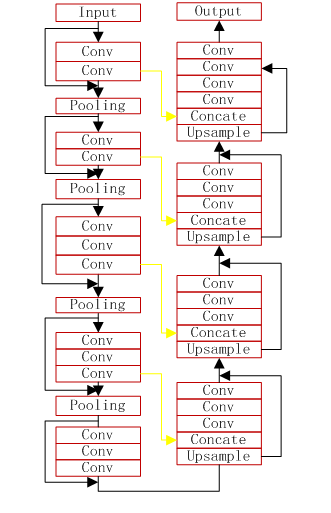

#### Build the model

In [ ]:
def conv_batch_drop(x, drop, k):
  conv1 = Conv3D(k, (3, 3, 3), strides=(1, 1, 1), activation='relu', padding='same')(x)
  batch_norm1 = BatchNormalization()(conv1)
  drop1 = Dropout(rate=1-drop)(tf.nn.relu(batch_norm1))
  return drop1

def decov(x, k):
  up4 = Conv3DTranspose(k, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)
  conv = tf.nn.relu(up4)
  return conv

def crop_and_concat(x1, x2):
    x1_shape = tf.shape(x1)
    x2_shape = tf.shape(x2)
    # offsets for the top left corner of the crop
    offsets = [0, (x2_shape[1] - x1_shape[1]) // 2,
               (x2_shape[2] - x1_shape[2]) // 2, (x2_shape[3] - x1_shape[3]) // 2, 0]
    size = [-1, x2_shape[1], x2_shape[2], x2_shape[3], -1]
    x1_crop = tf.slice(x1, offsets, size)
    return tf.keras.layers.Concatenate()([x1_crop, x2])


def vnet(input_shape, num_classes):
    drop = tf.Variable(0.01, dtype=tf.float32)
    inputs = Input(input_shape)

    # Encoding path
    layer0 = conv_batch_drop(inputs, drop, 16)
    layer1 = conv_batch_drop(layer0, drop, 16)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(layer1)

    layer2 = conv_batch_drop(pool1, drop, 32)
    layer2 = conv_batch_drop(layer2, drop, 32)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(layer2)

    layer3 = conv_batch_drop(pool2, drop, 64)
    layer3 = conv_batch_drop(layer3, drop, 64)
    layer3 = conv_batch_drop(layer3, drop, 64)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(layer3)

    layer4 = conv_batch_drop(pool3, drop, 128)
    layer4 = conv_batch_drop(layer4, drop, 128)
    layer4 = conv_batch_drop(layer4, drop, 128)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(layer4)

    layer5 = conv_batch_drop(pool4, drop, 256)
    layer5 = conv_batch_drop(layer5, drop, 256)
    layer5 = conv_batch_drop(layer5, drop, 256)

    # Decoding path
    deconv1 = Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(layer5)
    layer6 = crop_and_concat(layer4, deconv1)
    layer6 = conv_batch_drop(layer6, drop, 128)
    layer6 = conv_batch_drop(layer6, drop, 128)
    layer6 = conv_batch_drop(layer6, drop, 128)

    deconv2 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(layer6)
    layer7 = crop_and_concat(layer3, deconv2)
    layer7 = conv_batch_drop(layer7, drop, 64)
    layer7 = conv_batch_drop(layer7, drop, 64)
    layer7 = conv_batch_drop(layer7, drop, 64)

    doconv3 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(layer7)
    layer8 = crop_and_concat(layer2, doconv3)
    layer8 = conv_batch_drop(layer8, drop, 32)
    layer8 = conv_batch_drop(layer8, drop, 32)
    layer8 = conv_batch_drop(layer8, drop, 32)

    doconv4 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(layer8)
    layer9 = crop_and_concat(layer1, doconv4)
    layer9 = conv_batch_drop(layer9, drop, 32)
    layer9 = conv_batch_drop(layer9, drop, 32)
    layer9 = conv_batch_drop(layer9, drop, 32)

    # Output layer
    output = Conv3D(num_classes, (1, 1, 1), activation='softmax')(layer9)

    model = Model(inputs=inputs, outputs=output)

    return model


vnet_model = vnet((16,96,96,1),2)

In [ ]:
vnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 96, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 16, 96, 96,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 96, 96,   64         ['conv3d[0][0]']                 
 alization)                     16)                                                           

#### Compile the model

In [ ]:
vnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=sm.losses.DiceLoss(),
              metrics=[sm.metrics.IOUScore(),
                       tf.keras.metrics.FalseNegatives()])

#### Train the model on the sample data

In [ ]:
batch_xs_tran = np.transpose(batch_xs, (0, 3, 1, 2, 4))
batch_ys_tran = np.transpose(y_arr, (0, 3, 1, 2, 4))

his = vnet_model.fit(batch_xs_tran, batch_ys_tran, epochs=50, batch_size=8)

Epoch 1/50
250/250 [==============================] - 178s 570ms/step - loss: 0.6203 - iou_score: 0.2970 - false_negatives: 7077497.0000
Epoch 2/50
250/250 [==============================] - 145s 581ms/step - loss: 0.5679 - iou_score: 0.3683 - false_negatives: 3972000.0000
Epoch 3/50
250/250 [==============================] - 145s 579ms/step - loss: 0.5458 - iou_score: 0.4029 - false_negatives: 3972000.0000
Epoch 4/50
250/250 [==============================] - 145s 580ms/step - loss: 0.5338 - iou_score: 0.4231 - false_negatives: 3972000.0000
Epoch 5/50
250/250 [==============================] - 145s 578ms/step - loss: 0.5251 - iou_score: 0.4385 - false_negatives: 3972000.0000
Epoch 6/50
250/250 [==============================] - 145s 579ms/step - loss: 0.5188 - iou_score: 0.4501 - false_negatives: 3972000.0000
Epoch 7/50
250/250 [==============================] - 145s 579ms/step - loss: 0.5143 - iou_score: 0.4588 - false_negatives: 3972000.0000
Epoch 8/50
250/250 [=====================

In [ ]:
tf.saved_model.save(vnet_model, "/content/drive/MyDrive/LCD/LUNA16")

In [ ]:
loaded_model = tf.saved_model.load("/content/drive/MyDrive/LCD/LUNA16/my_model")

In [ ]:
# Get the inference function from the loaded model
inference_func = loaded_model.signatures["serving_default"]

# Assuming you have input data for prediction
input_data = x_test  # Your input data for prediction

# Make predictions using the loaded model
input_data = np.asarray(input_data, dtype=np.float32)
predictions = inference_func(tf.constant(input_data))

# # Access the output of the predictions
# output = predictions["output"]

# # Convert the output to a NumPy array if needed
# output = output.numpy()

In [ ]:
predictions['conv3d_25'][0][0][0]

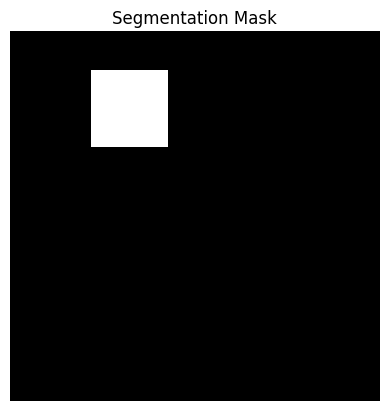

In [ ]:
# Assuming 'output' is your predicted segmentation output array of shape (200, 96, 96, 16, 2)
slice_idx = 15  # Select the slice index along the depth dimension to visualize

# Select the slice from the output array
slice_data = y_test[120, :, :, slice_idx, :]

# Assuming you want to visualize the segmentation mask of class 1
# mask = slice_data[..., 1]

# Plot the segmentation mask
plt.imshow(slice_data, cmap='gray')
plt.axis('off')
plt.title('Segmentation Mask')
plt.show()

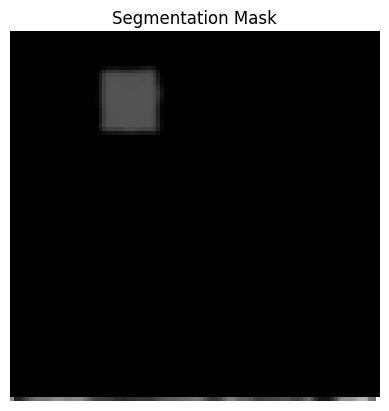

In [ ]:
# Assuming 'output' is your predicted segmentation output array of shape (200, 96, 96, 16, 2)
slice_idx = 15  # Select the slice index along the depth dimension to visualize

# Select the slice from the output array
slice_data = predictions['conv3d_25'][120][:, :, slice_idx, :]

# Assuming you want to visualize the segmentation mask of class 1
mask = slice_data[..., 1]

# Plot the segmentation mask
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Segmentation Mask')
plt.show()

In [ ]:
y_pred = np.argmin(predictions['conv3d_25'], axis=-1)

In [ ]:
y_pred = np.expand_dims(y_pred, axis=-1)

In [ ]:
y_pred[0][0][0]

In [ ]:
visualize(y_pred, 16)

#### Train the model on the real data

In [ ]:
def load_shuffle_dpaths(train_path_csv, label_path_csv):
  csvmaskdata = pd.read_csv(label_path_csv)
  csvimagedata = pd.read_csv(train_path_csv)
  maskdata = csvmaskdata.iloc[:, :].values
  imagedata = csvimagedata.iloc[:, :].values
  # shuffle imagedata and maskdata together
  perm = np.arange(len(csvimagedata))
  np.random.shuffle(perm)
  imagedata = imagedata[perm]
  maskdata = maskdata[perm]
  return imagedata, maskdata

# imagedata, maskdata = load_shuffle_dpaths('/content/drive/MyDrive/train_segment.csv', '/content/drive/MyDrive/label_segment.csv')
imagedata, maskdata = load_shuffle_dpaths('/content/drive/MyDrive/LCD/LUNA16/train_in_csv', '/content/drive/MyDrive/LCD/LUNA16/mask_in_csv')

In [ ]:
# save_file2csv("/content/drive/MyDrive/LCD/LUNA16/segmentation/Image", '/content/drive/MyDrive/LCD/LUNA16/train_in_csv')
# save_file2csv("/content/drive/MyDrive/LCD/LUNA16/segmentation/Mask", '/content/drive/MyDrive/LCD/LUNA16/mask_in_csv')


sub_dirs: ['40_158', '40_159', '40_160', '40_161', '40_162', '40_163', '40_164', '40_165', '40_166', '40_167', '40_168', '40_169', '40_170', '40_171', '40_172', '40_173', '40_174', '40_175', '40_176', '40_177', '40_178', '40_179', '40_180', '40_181', '40_182', '40_183', '40_184', '40_185', '40_186', '40_187', '40_188', '40_189', '40_190', '40_191', '40_192', '40_193', '40_194', '40_195', '40_196', '40_197', '40_198', '40_199', '40_200', '40_201', '40_202', '40_203', '40_204', '40_205', '40_206', '40_207', '40_208', '40_209', '40_210', '40_211', '40_212', '40_213', '40_214', '40_215', '40_216', '40_217', '40_218', '40_219', '40_220', '40_221', '40_222', '40_223', '40_224', '40_225', '40_226', '40_227', '40_228', '40_229', '40_230', '40_231', '40_232', '40_233', '40_234', '40_235', '40_236', '40_237', '40_238', '40_239', '40_240', '40_241', '40_242', '40_243', '40_244', '40_245', '40_246', '40_247', '40_248', '40_249', '40_250', '40_251', '40_252', '40_253', '40_254', '40_255', '40_256',

In [ ]:
def load_all_images(imagedata_paths, maskdata_paths):
  batch_xs = np.empty((len(imagedata_paths), 16, 96, 96, 1))
  batch_ys = np.empty((len(maskdata_paths), 16, 96, 96, 1))
  for num in tq(range(len(imagedata_paths))):
    index = 0
    for _ in os.listdir(imagedata_paths[num][0]):
      image = cv2.imread(imagedata_paths[num][0] + "/" +str(index)+".bmp", cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(maskdata_paths[num][0] + "/" +str(index)+".bmp", cv2.IMREAD_GRAYSCALE)
      # print(imagedata[num][0])
      # print(index)
      batch_xs[num, index, :, :, :] = np.reshape(image, (96, 96, 1))
      batch_ys[num, index, :, :, :] = np.reshape(label, (96, 96, 1))
      index += 1

  return batch_xs, batch_ys

images, labels = load_all_images(imagedata[0:1], maskdata[0:1])

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
labels = np.transpose(labels,(0,2,3,1,4))

In [ ]:
labels = make_masks_onehot(labels, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
y_arr = np.empty((len(labels), 96, 96, 16, 2))
for i in range(len(labels)):
  y_arr[i, :, :, :, :] = make_masks_onehot(labels[i], 2)

y_arr = np.array(y_arr)
labels = np.transpose(y_arr,(0,3,1,2,4))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

# Assuming you have a 3D numpy array called "lung_image" representing the lung image
# Set the x, y, z dimensions of the lung image
x_dim, y_dim, z_dim = imagearray.shape

# Generate a grid of coordinates
x, y, z = np.meshgrid(range(x_dim), range(y_dim), range(z_dim))

# Flatten the lung image and corresponding coordinates
lung_image_flattened = imagearray.flatten()
x_flattened = x.flatten()
y_flattened = y.flatten()
z_flattened = z.flatten()

# Mask the background (assuming background value is 0)
mask = lung_image_flattened > 0
# Create a trace for the 3D scatter plot
trace = go.Scatter3d(
    x=x_flattened[mask],
    y=y_flattened[mask],
    z=z_flattened[mask],
    mode='markers',
    marker=dict(
        size=1,
        color=lung_image_flattened[mask],
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout for the 3D plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

# Create the figure and add the trace to it
fig = go.Figure(data=[trace], layout=layout)

# Show the 3D plot
fig.show()

In [ ]:
def image_mask_generator(images_dir, masks_dir, batch_size):
    while True:
        # Generate batches of data
        for i in range(0, len(images_dir), batch_size):
            batch_image_filenames = images_dir[i:i + batch_size]
            batch_mask_filenames = masks_dir[i:i + batch_size]

            batch_xs = np.empty((batch_size, 16, 96, 96, 1))
            batch_ys = np.empty((batch_size, 16, 96, 96, 1))
            batch_ys_one_hot = np.empty((batch_size, 16, 96, 96, 2))


            for num, file_name in enumerate(batch_image_filenames):
                index = 0
                for index in range(16):
                    image = cv2.imread(file_name[0] + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)
                    label = cv2.imread(batch_mask_filenames[num][0] + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)

                    batch_xs[num, index, :, :, :] = np.reshape(image, (96, 96, 1))
                    batch_ys[num, index, :, :, :] = np.reshape(label, (96, 96, 1))
                batch_ys_one_hot[num, :, :, :, :] = make_masks_onehot(batch_ys[num, :, :, :, :], 2)

            yield batch_xs, batch_ys_one_hot

In [ ]:
train_generator = image_mask_generator(imagedata, maskdata, 8)
# print(train_generator)
his = vnet_model.fit(train_generator, epochs=50)

Epoch 1/50
      1/Unknown - 44s 44s/step - loss: 0.6037 - iou_score: 0.2778 - false_negatives: 132661.0000

In [ ]:
images = np.load("/content/drive/MyDrive/LCD/LUNA16/data_images.npy", allow_pickle=True)
labels = np.load("/content/drive/MyDrive/LCD/LUNA16/data_masks.npy", allow_pickle=True)


In [ ]:
y_arr = np.empty((len(labels), 96, 96, 16, 2))
for i in range(len(labels)):
  y_arr[i, :, :, :, :] = make_masks_onehot(labels[i], 2)

y_arr = np.array(y_arr)
labels = np.transpose(y_arr,(0,3,1,2,4))

In [ ]:
labels.shape

In [ ]:
# train_generator = image_mask_generator(imagedata, maskdata, 8)
# print(train_generator)
his = vnet_model.fit(images, labels, batch_size=8, epochs=150)

In [ ]:
tf.saved_model.save(vnet_model, "/content/drive/MyDrive/LCD/LUNA16/my_model")

In [ ]:
import cv2
# Serve data by batches
def _next_batch(train_images, train_labels, batch_size, index_in_epoch):
    start = index_in_epoch
    index_in_epoch += batch_size

    num_examples = train_images.shape[0]
    # when all trainig data have been already used, it is reorder randomly
    if index_in_epoch > num_examples:
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end], index_in_epoch

csvmaskdata = pd.read_csv('/content/drive/MyDrive/label_segment.csv')
csvimagedata = pd.read_csv('/content/drive/MyDrive/train_segment.csv')
maskdata = csvmaskdata.iloc[:, :].values
imagedata = csvimagedata.iloc[:, :].values
# shuffle imagedata and maskdata together
perm = np.arange(len(csvimagedata))
np.random.shuffle(perm)
imagedata = imagedata[perm]
maskdata = maskdata[perm]
index_in_epoch = 0
batched_data_x = []
batched_data_y = []
for i in tq(range(350)):

  batch_xs_path, batch_ys_path, index_in_epoch = _next_batch(imagedata, maskdata, 8,
                                                             index_in_epoch)
  # print(index_in_epoch)
  batch_xs = np.empty((len(batch_xs_path), 16, 96, 96, 1))
  batch_ys = np.empty((len(batch_ys_path), 16, 96, 96, 1))
  for num in tq(range(len(batch_xs_path))):
    index = 0
    for j in tq(os.listdir(batch_xs_path[num][0])):
      # print("-----------num:",num)
      # print(batch_xs_path[num])
      # print(j)

      image = cv2.imread(batch_xs_path[num][0] + "/" +str(index)+".bmp", cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(batch_ys_path[num][0] + "/" +str(index)+".bmp", cv2.IMREAD_GRAYSCALE)
      # print(image.shape)
      # print(np.array(batch_xs).shape)
      batch_xs[num, index, :, :, :] = np.reshape(image, (96, 96, 1))
      batch_ys[num, index, :, :, :] = np.reshape(label, (96, 96, 1))
      # print(batch_xs.shape)
      index += 1
  batched_data_x.append(batch_xs)
  batched_data_y.append(batch_ys)
  # batch_xs = np.transpose(batch_xs, (0, 2, 1))
  # his = vnet_model.fit(batch_xs, batch_ys, epochs=1,batch_size=1)
  # print(batch_xs_path, batch_ys_path)

#### Finetune the pretrained torch model

In [ ]:
image_path = []
mask_path = []
for path in os.listdir('/content/drive/MyDrive/LCD/LUNA16/process/image'):
  image_path.append('/content/drive/MyDrive/LCD/LUNA16/process/image/'+path)
  mask_path.append('/content/drive/MyDrive/LCD/LUNA16/process/mask/'+path)


In [ ]:
imagearray = []
maskarray = []
for i in tq(range(len(image_path))):
  index = 0
  listsrc = []
  listmask = []
  for _ in tq(os.listdir('/content/drive/MyDrive/LCD/LUNA16/process/image/' + str(i))):
      image = cv2.imread('/content/drive/MyDrive/LCD/LUNA16/process/image/' + str(i) + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)
      label = cv2.imread('/content/drive/MyDrive/LCD/LUNA16/process/mask/' + str(i) + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)
      listsrc.append(image)
      listmask.append(label)
      index += 1

  imagearray = np.array(listsrc)
  imagearray = np.reshape(imagearray, (index, 512, 512))
  maskarray = np.array(listmask)
  maskarray = np.reshape(maskarray, (index, 512, 512))
  if i==0:
    break

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

In [ ]:
img = np.expand_dims(imagearray, axis=0)  # Add batch dimension
img = np.expand_dims(img, axis=4)  # Add channel dimension

# Convert the image to a PyTorch tensor
# tensor = torch.from_numpy(imagearray).float()

In [ ]:
imagearray = np.transpose(images, (0, 4, 2, 3, 1))
# mas = np.transpose(labels, (0, 4, 2, 3, 1))

In [ ]:
# imagearray = np.transpose(imagearray, (1, 2, 0))

In [ ]:
imagearray.shape


(1, 1, 96, 96, 16)

In [ ]:
import torch
imagearray = imagearray.astype(np.double)
tensor = torch.from_numpy(imagearray)
# tensor = tensor.double()

In [ ]:
import torch

# Path to the saved model file
model_path = '/content/drive/MyDrive/LCD/LUNA16/lung_nodule_ct_detection/lung_nodule_ct_detection/models/model.ts'

# Load the model
model = torch.load(model_path)
model.eval()
# torch.backends.disable_tracing()
# Perform the inference in eager mode
model.double()

# with torch.no_grad():
output = model(tensor)
# Use the loaded model for further operations
# For example, you can make predictions using the model
input_data = ...  # Your input data for prediction
# output = model(tensor)

/usr/local/lib/python3.10/dist-packages/torch/serialization.py:799: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [ ]:
output["box_regression"][0]

tensor([[[[[-1.3259e-01,  8.2168e-02, -4.5073e-02,  ..., -8.0926e-02,
            -5.5376e-03,  8.8096e-03],
           [ 5.6176e-02,  5.0986e-01,  3.4173e-01,  ...,  2.9916e-01,
             4.0731e-01,  3.0456e-01],
           [ 8.7435e-03,  4.5151e-01,  2.1943e-01,  ...,  1.8083e-01,
             3.0827e-01,  2.6552e-01],
           ...,
           [-5.5697e-02,  2.8379e-01,  1.2004e-01,  ...,  9.4808e-02,
             1.3643e-01,  3.0097e-02],
           [-5.3909e-02,  3.6827e-01,  2.4229e-01,  ...,  2.1839e-01,
             2.7671e-01,  1.5735e-01],
           [ 3.3618e-02,  2.9594e-01,  2.1248e-01,  ...,  2.1425e-01,
             2.4585e-01,  1.4563e-01]],

          [[-1.4084e-01, -3.4916e-01, -3.9024e-01,  ..., -4.9604e-01,
            -4.6268e-01, -3.5982e-01],
           [-1.6485e-01, -3.0196e-01, -4.1891e-01,  ..., -5.2915e-01,
            -5.9551e-01, -5.5575e-01],
           [-2.0694e-01, -2.8960e-01, -4.6155e-01,  ..., -5.5640e-01,
            -6.6646e-01, -6.3054e-01],
 

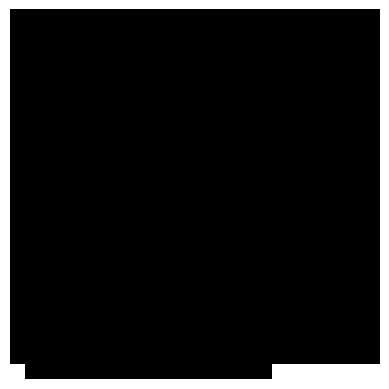

In [ ]:
# Assuming 'output' is the dictionary containing the model's output
classification_output = output["box_regression"][0]
# classification_output = torch.tensor(output["classification"][0])
# Alternatively, you can use box_regression_output = output["box_regression"]

# Apply any necessary post-processing, such as thresholding
threshold = 0.1  # Adjust this value based on your model's output
binary_mask = (classification_output > threshold).float()

# Assuming 'segmented_image' has shape (18, 24, 24, 8)
first_image = segmented_image[0, :, :, 4]  # Select the first image and the first channel
reshaped_image = np.squeeze(first_image)  # Remove any single-dimensional entries

# Display the reshaped image
plt.imshow(reshaped_image, cmap="gray")  # Use appropriate colormap if needed
plt.axis("off")  # Disable axes
plt.show()

#### Checking the data

In [ ]:
srcpath = "/content/drive/MyDrive/LCD/LUNA16/process/image/25"
maskpath = "/content/drive/MyDrive/LCD/LUNA16/process/mask/25"
trainImage = "/content/segmentation/Image"
trainMask = "/content/segmentation/Mask"
shape = (16, 96, 96)
height = 512
width = 512
number = 56
numberxy = 10
numberz = 10
index = 0
listsrc = []
listmask = []
for _ in tq(os.listdir(srcpath)):
    image = cv2.imread(srcpath + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(maskpath + "/" + str(index) + ".bmp", cv2.IMREAD_GRAYSCALE)
    listsrc.append(image)
    listmask.append(label)
    index += 1

imagearray = np.array(listsrc)
imagearray = np.reshape(imagearray, (index, height, width))
maskarray = np.array(listmask)
maskarray = np.reshape(maskarray, (index, height, width))
gen_image_mask(imagearray, maskarray, 25, shape=shape, numberxy=numberxy, numberz=numberz, trainImage=trainImage,
                trainMask=trainMask)

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

In [ ]:
import shutil

# Define the source and destination paths
source_folder = '/content/drive/MyDrive/segmentation'
destination_folder = '/content/drive/MyDrive/LCD/LUNA16'

# Delete the existing folder in Google Drive
# shutil.rmtree(destination_folder)

# Copy the new folder from Colab to Google Drive
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

In [ ]:
len(os.listdir("/content/drive/MyDrive/LCD/LUNA16/segmentation"))

2

In [ ]:
shutil.rmtree("/content/segmentation")

In [ ]:
count = 0
names = []
for i in os.listdir("/content/drive/MyDrive/LCD/LUNA16/segmentation/Image/"):
  # print(i)
  if len(os.listdir("/content/drive/MyDrive/LCD/LUNA16/segmentation/Image/" + i))<16:
    count += 1
    names.append(i)
print(count, names)

0 []


### Different approach of creating the model

#### Creating the model based on .py files and training the model

In [ ]:
from model_vnet3d import Vnet3dModule
def train():

    '''
    Preprocessing for dataset
    '''
    tf.compat.v1.disable_eager_execution()
    # Read  data set (Train data from CSV file)
    csvmaskdata = pd.read_csv('/content/drive/MyDrive/train_segment.csv')
    csvimagedata = pd.read_csv('/content/drive/MyDrive/label_segment.csv')
    maskdata = csvmaskdata.iloc[:, :].values
    imagedata = csvimagedata.iloc[:, :].values
    # shuffle imagedata and maskdata together
    perm = np.arange(len(csvimagedata))
    np.random.shuffle(perm)
    imagedata = imagedata[perm]
    maskdata = maskdata[perm]

    Vnet3d = Vnet3dModule(96, 96, 16, channels=1, costname=("dice coefficient",))
    Vnet3d.train(imagedata, maskdata, "Vnet3d.pd", "/content/log/segmeation/", 0.001, 0.5, 10, 6)

train()

#### Creating the model same as .py but with Keras

In [ ]:
def weight_xavier_init(shape, n_inputs, n_outputs, activefunction='sigomd', uniform=True, variable_name=None):
    with tf.device('/cpu:0'):
        if activefunction == 'sigomd':
            if uniform:
                init_range = tf.sqrt(6.0 / (n_inputs + n_outputs))
                initial = tf.random.uniform(shape, -init_range, init_range)
                return tf.Variable(initial, name=variable_name, trainable=True)
                # return tf.get_variable(name=variable_name, initializer=initial, trainable=True)
            else:
                stddev = tf.sqrt(2.0 / (n_inputs + n_outputs))
                initial = tf.truncated_normal(shape, mean=0.0, stddev=stddev)
                return tf.Variable(initial, name=variable_name, trainable=True)
                # return tf.get_variable(name=variable_name, initializer=initial, trainable=True)
        elif activefunction == 'relu':
            if uniform:
                init_range = tf.sqrt(6.0 / (n_inputs + n_outputs)) * np.sqrt(2)
                initial = tf.random.uniform(shape, -init_range, init_range)
                return tf.Variable(initial, name=variable_name, trainable=True)
                # return tf.get_variable(name=variable_name, initializer=initial, trainable=True)
            else:
                stddev = tf.sqrt(2.0 / (n_inputs + n_outputs)) * np.sqrt(2)
                initial = tf.truncated_normal(shape, mean=0.0, stddev=stddev)
                return tf.Variable(initial, name=variable_name, trainable=True)
                # return tf.get_variable(name=variable_name, initializer=initial, trainable=True)
        elif activefunction == 'tan':
            if uniform:
                init_range = tf.sqrt(6.0 / (n_inputs + n_outputs)) * 4
                initial = tf.random.uniform(shape, -init_range, init_range)
                return tf.Variable(initial, name=variable_name, trainable=True)
                # return tf.get_variable(name=variable_name, initializer=initial, trainable=True)
            else:
                stddev = tf.sqrt(2.0 / (n_inputs + n_outputs)) * 4
                initial = tf.truncated_normal(shape, mean=0.0, stddev=stddev)
                return tf.Variable(initial, name=variable_name, trainable=True)
                # return tf.get_variable(name=variable_name, initializer=initial, trainable=True)
def bias_variable(shape, variable_name=None):
    with tf.device('/cpu:0'):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=variable_name, trainable=True)
        # return tf.get_variable(name=variable_name, initializer=initial, trainable=True)
def conv3d(x, kernal, stride=1):
  conv_3d = tf.keras.layers.Conv3D(filters=16,
                  # kernel_size=W.shape.as_list()[0:3],
                  kernel_size = kernal[0:3],
                  strides=(stride, stride, stride),
                  padding='same')(x)
                  # kernel_initializer=tf.keras.initializers.Constant(W.numpy()))(x)
  return conv_3d

# 3D upsampling
def upsample3d(x, scale_factor, scope=None):
    ''''
    X shape is [nsample,dim,rows, cols, channel]
    out shape is[nsample,dim*scale_factor,rows*scale_factor, cols*scale_factor, channel]
    '''
    x_shape = tf.shape(x)
    k = tf.ones([scale_factor, scale_factor, scale_factor, x_shape[-1], x_shape[-1]])
    # note k.shape = [dim,rows, cols, depth_in, depth_output]
    output_shape = tf.stack(
        [x_shape[0], x_shape[1] * scale_factor, x_shape[2] * scale_factor, x_shape[3] * scale_factor, x_shape[4]])
    upsample = tf.keras.layers.Conv3DTranspose(filter=k, output_shape=output_shape,
                                      strides=(scale_factor, scale_factor, scale_factor),
                                      padding='SAME', name=scope)(x)
    return upsample

# 3D deconvolution
def deconv3d(x, kernal, samefeature=False, depth=False):
    """
    depth flag:False is z axis is same between input and output,true is z axis is input is twice than output
    """
    x_shape = tf.shape(x)
    if depth:
        if samefeature:
            output_shape = tf.stack([x_shape[0], x_shape[1] * 2, x_shape[2] * 2, x_shape[3] * 2, x_shape[4]])
        else:
            output_shape = tf.stack([x_shape[0], x_shape[1] * 2, x_shape[2] * 2, x_shape[3] * 2, x_shape[4] // 2])
        deconv = tf.keras.layers.Conv3DTranspose(filters=kernal[-1],
                                                # output_shape=output_shape,
                                                # kernel_size=W.shape.as_list()[0:3],
                                                 kernel_size = kernal[0:3],
                                                strides=(2, 2, 2),
                                                padding='SAME')(x)
        # deconv = tf.nn.conv3d_transpose(x, W, output_shape, strides=[1, 2, 2, 2, 1], padding='SAME')
    else:
        if samefeature:
            output_shape = tf.stack([x_shape[0], x_shape[1] * 2, x_shape[2] * 2, x_shape[3], x_shape[4]])
        else:
            output_shape = tf.stack([x_shape[0], x_shape[1] * 2, x_shape[2] * 2, x_shape[3], x_shape[4] // 2])
        deconv = tf.keras.layers.Conv3DTranspose(filters=kernal[-1],
                                            # output_shape=output_shape,
                                            # kernel_size=W.shape.as_list()[0:3],
                                            kernel_size = kernal[0:3],
                                            strides=(2, 2, 2),
                                            padding='SAME', name=scope)(x)
        # deconv = tf.nn.conv3d_transpose(x, W, output_shape, strides=[1, 2, 2, 1, 1], padding='SAME')
    return deconv

def max_pool3d(x, depth=False):
    """
        depth flag:False is z axis is same between input and output,true is z axis is input is twice than output
        """
    if depth:
        pool3d = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='SAME')
    else:
        pool3d = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 1), strides=(2, 2, 1), padding='SAME')

        # pool3d = tf.nn.max_pool3d(x, ksize=[1, 2, 2, 1, 1], strides=[1, 2, 2, 1, 1], padding='SAME')
    return pool3d

def crop_and_concat(x1, x2):
    x1_shape = tf.shape(x1)
    x2_shape = tf.shape(x2)
    print("x1 shape", x1_shape)
    print("x2 shape", x2_shape)
    # offsets for the top left corner of the crop
    offsets = [0, (x2_shape[1] - x1_shape[1]) // 2,
               (x2_shape[2] - x1_shape[2]) // 2, (x2_shape[3] - x1_shape[3]) // 2, 0]
    size = [-1, x2_shape[1], x2_shape[2], x2_shape[3], -1]
    print("size concatenate", size)
    x1_crop = tf.slice(x1, offsets, size)
    return tf.keras.layers.Concatenate()([x1_crop, x2])
    # return tf.concat([x1_crop, x2], 4)

# Batch Normalization
def normalizationlayer(x, is_train, height=None, width=None, image_z=None, norm_type=None, G=16, esp=1e-5, scope=None):
    """
    :param x:input data with shap of[batch,height,width,channel]
    :param is_train:flag of normalizationlayer,True is training,False is Testing
    :param height:in some condition,the data height is in Runtime determined,such as through deconv layer and conv2d
    :param width:in some condition,the data width is in Runtime determined
    :param image_z:
    :param norm_type:normalization type:support"batch","group","None"
    :param G:in group normalization,channel is seperated with group number(G)
    :param esp:Prevent divisor from being zero
    :param scope:normalizationlayer scope
    :return:
    """
    with tf.name_scope(scope + norm_type):
        if norm_type == None:
            output = x
        elif norm_type == 'batch':
            output = tf.contrib.layers.batch_norm(x, center=True, scale=True, is_train=is_train)
        elif norm_type == "group":
            # tranpose:[bs,z,h,w,c]to[bs,c,z,h,w]following the paper
            x = tf.transpose(x, [0, 4, 1, 2, 3])
            N, C, Z, H, W = x.get_shape().as_list()
            G = min(G, C)
            if H == None and W == None and Z == None:
                Z, H, W = image_z, height, width
            x = tf.reshape(x, [-1, G, C // G, Z, H, W])
            mean, var = tf.nn.moments(x, [2, 3, 4, 5], keepdims=True)
            x = (x - mean) / tf.sqrt(var + esp)
            alfa_initializer = tf.constant_initializer(1.0)
            beta_initializer = tf.constant_initializer(0.0)
            gama = tf.Variable(alfa_initializer(shape=[C], dtype=tf.float32), name=scope + norm_type + 'group_gama')
            beta = tf.Variable(beta_initializer(shape=[C], dtype=tf.float32), name=scope + norm_type + 'group_beta')
            # gama = tf.get_variable(scope + norm_type + 'group_gama', [C], initializer=tf.constant_initializer(1.0))
            # beta = tf.get_variable(scope + norm_type + 'group_beta', [C], initializer=tf.constant_initializer(0.0))
            gama = tf.reshape(gama, [1, C, 1, 1, 1])
            beta = tf.reshape(beta, [1, C, 1, 1, 1])
            output = tf.reshape(x, [-1, C, Z, H, W]) * gama + beta
            # tranpose:[bs,c,z,h,w]to[bs,z,h,w,c]following the paper
            output = tf.transpose(output, [0, 2, 3, 4, 1])
        return output


# resnet add_connect
def resnet_Add(x1, x2):
    print("x1.get_shape", x1.get_shape().as_list())
    print("x2.get_shape", x2.get_shape().as_list())

    if x1.get_shape().as_list()[4] < x2.get_shape().as_list()[4]:
        # Option A: Zero-padding
        residual_connection = x2 + tf.pad(x1, [[0, 0], [0, 0], [0, 0], [0, 0],
                                               [0, x2.get_shape().as_list()[4] -
                                                x1.get_shape().as_list()[4]]])
    elif x1.get_shape().as_list()[4] > x2.get_shape().as_list()[4]:
      # Option A: Zero-padding
        residual_connection = x1 + tf.pad(x1, [[0, 0], [0, 0], [0, 0], [0, 0],
                                               [0, x1.get_shape().as_list()[4] -
                                                x2.get_shape().as_list()[4]]])
    else:
        residual_connection = x2 + x1
    return residual_connection




In [ ]:
def conv_bn_relu_drop(x, kernal, phase, drop, image_z=None, height=None, width=None, scope=None):
    with tf.name_scope(scope):
        # W = weight_xavier_init(shape=kernal, n_inputs=kernal[0] * kernal[1] * kernal[2] * kernal[3],
        #                        n_outputs=kernal[-1], activefunction='relu', variable_name=scope + 'conv_W')
        # B = bias_variable([kernal[-1]], variable_name=scope + 'conv_B')
        # conv = conv3d(x, W) + B
        conv = conv3d(x, kernal)
        # conv = normalizationlayer(conv, is_train=phase, height=height, width=width, image_z=image_z, norm_type='group',
        #                           scope=scope)
        conv = tf.keras.layers.BatchNormalization()(conv)
        conv = tf.keras.layers.Dropout(rate=1-drop)(tf.nn.relu(conv))
        print(type(conv))
        # conv = tf.nn.dropout(tf.nn.relu(conv), drop)
        return conv


def down_sampling(x, kernal, phase, drop, image_z=None, height=None, width=None, scope=None):
    with tf.name_scope(scope):
        # W = weight_xavier_init(shape=kernal, n_inputs=kernal[0] * kernal[1] * kernal[2] * kernal[3],
        #                        n_outputs=kernal[-1],
        #                        activefunction='relu', variable_name=scope + 'W')
        # B = bias_variable([kernal[-1]], variable_name=scope + 'B')
        # conv = conv3d(x, W, 2) + B
        conv = conv3d(x, kernal)
        conv = normalizationlayer(conv, is_train=phase, height=height, width=width, image_z=image_z, norm_type='group',
                                  scope=scope)
        # conv = tf.nn.dropout(tf.nn.relu(conv), drop)
        conv = tf.keras.layers.Dropout(rate=1-drop)(tf.nn.relu(conv))

        return conv


def deconv_relu(x, kernal, samefeture=False, scope=None):
    with tf.name_scope(scope):
        # W = weight_xavier_init(shape=kernal, n_inputs=kernal[0] * kernal[1] * kernal[2] * kernal[-1],
        #                        n_outputs=kernal[-2], activefunction='relu', variable_name=scope + 'W')
        # B = bias_variable([kernal[-2]], variable_name=scope + 'B')
        # conv = deconv3d(x, W, samefeture, True) + B
        conv = deconv3d(x, kernal, samefeture, True)
        conv = tf.nn.relu(conv)
        return conv


def conv_sigmod(x, kernal, scope=None):
    with tf.name_scope(scope):
        # W = weight_xavier_init(shape=kernal, n_inputs=kernal[0] * kernal[1] * kernal[2] * kernal[3],
        #                        n_outputs=kernal[-1], activefunction='sigomd', variable_name=scope + 'W')
        # B = bias_variable([kernal[-1]], variable_name=scope + 'B')
        # conv = conv3d(x, W) + B
        conv = conv3d(x, kernal)
        conv = tf.nn.sigmoid(conv)
        return conv

In [ ]:
def create_conv_net(X, image_z, image_width, image_height, image_channel, phase, drop, n_class=1):

    inputX = tf.reshape(X, [-1, image_z, image_width, image_height, image_channel])  # shape=(?, 32, 32, 1)
    # Vnet model
    # layer1->convolution
    layer0 = conv_bn_relu_drop(x=inputX, kernal=(3, 3, 3, image_channel, 16), phase=phase, drop=drop,
                               scope='layer0')
    layer1 = conv_bn_relu_drop(x=layer0, kernal=(3, 3, 3, 16, 16), phase=phase, drop=drop,
                               scope='layer1')
    # layer1 = resnet_Add(x1=layer0, x2=layer1)
    # down sampling1
    down1 = down_sampling(x=layer1, kernal=(3, 3, 3, 16, 32), phase=phase, drop=drop, scope='down1')
    # layer2->convolution
    layer2 = conv_bn_relu_drop(x=down1, kernal=(3, 3, 3, 32, 32), phase=phase, drop=drop,
                               scope='layer2_1')
    layer2 = conv_bn_relu_drop(x=layer2, kernal=(3, 3, 3, 32, 32), phase=phase, drop=drop,
                               scope='layer2_2')
    # layer2 = resnet_Add(x1=down1, x2=layer2)
    # down sampling2
    down2 = down_sampling(x=layer2, kernal=(3, 3, 3, 32, 64), phase=phase, drop=drop, scope='down2')
    # layer3->convolution
    layer3 = conv_bn_relu_drop(x=down2, kernal=(3, 3, 3, 64, 64), phase=phase, drop=drop,
                               scope='layer3_1')
    layer3 = conv_bn_relu_drop(x=layer3, kernal=(3, 3, 3, 64, 64), phase=phase, drop=drop,
                               scope='layer3_2')
    layer3 = conv_bn_relu_drop(x=layer3, kernal=(3, 3, 3, 64, 64), phase=phase, drop=drop,
                               scope='layer3_3')
    # layer3 = resnet_Add(x1=down2, x2=layer3)
    # down sampling3
    down3 = down_sampling(x=layer3, kernal=(3, 3, 3, 64, 128), phase=phase, drop=drop, scope='down3')
    # layer4->convolution
    layer4 = conv_bn_relu_drop(x=down3, kernal=(3, 3, 3, 128, 128), phase=phase, drop=drop,
                               scope='layer4_1')
    layer4 = conv_bn_relu_drop(x=layer4, kernal=(3, 3, 3, 128, 128), phase=phase, drop=drop,
                               scope='layer4_2')
    layer4 = conv_bn_relu_drop(x=layer4, kernal=(3, 3, 3, 128, 128), phase=phase, drop=drop,
                               scope='layer4_3')
    # layer4 = resnet_Add(x1=down3, x2=layer4)
    # down sampling4
    down4 = down_sampling(x=layer4, kernal=(3, 3, 3, 128, 256), phase=phase, drop=drop, scope='down4')
    # layer5->convolution
    layer5 = conv_bn_relu_drop(x=down4, kernal=(3, 3, 3, 256, 256), phase=phase, drop=drop,
                               scope='layer5_1')
    layer5 = conv_bn_relu_drop(x=layer5, kernal=(3, 3, 3, 256, 256), phase=phase, drop=drop,
                               scope='layer5_2')
    layer5 = conv_bn_relu_drop(x=layer5, kernal=(3, 3, 3, 256, 256), phase=phase, drop=drop,
                               scope='layer5_3')
    # layer5 = resnet_Add(x1=down4, x2=layer5)

    # layer9->deconvolution
    deconv1 = deconv_relu(x=layer5, kernal=(3, 3, 3, 128, 256), scope='deconv1')
    # layer8->convolution
    layer6 = crop_and_concat(layer4, deconv1)
    _, Z, H, W, _ = layer4.get_shape().as_list()
    layer6 = conv_bn_relu_drop(x=layer6, kernal=(3, 3, 3, 256, 128), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer6_1')
    layer6 = conv_bn_relu_drop(x=layer6, kernal=(3, 3, 3, 128, 128), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer6_2')
    layer6 = conv_bn_relu_drop(x=layer6, kernal=(3, 3, 3, 128, 128), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer6_3')
    # layer6 = resnet_Add(x1=deconv1, x2=layer6)
    # layer9->deconvolution
    deconv2 = deconv_relu(x=layer6, kernal=(3, 3, 3, 64, 128), scope='deconv2')
    # layer8->convolution
    layer7 = crop_and_concat(layer3, deconv2)
    _, Z, H, W, _ = layer3.get_shape().as_list()
    layer7 = conv_bn_relu_drop(x=layer7, kernal=(3, 3, 3, 128, 64), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer7_1')
    layer7 = conv_bn_relu_drop(x=layer7, kernal=(3, 3, 3, 64, 64), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer7_2')
    layer7 = conv_bn_relu_drop(x=layer7, kernal=(3, 3, 3, 64, 64), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer7_3')
    # layer7 = resnet_Add(x1=deconv2, x2=layer7)
    # layer9->deconvolution
    deconv3 = deconv_relu(x=layer7, kernal=(3, 3, 3, 32, 64), scope='deconv3')
    # layer8->convolution
    layer8 = crop_and_concat(layer2, deconv3)
    _, Z, H, W, _ = layer2.get_shape().as_list()
    layer8 = conv_bn_relu_drop(x=layer8, kernal=(3, 3, 3, 64, 32), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer8_1')
    layer8 = conv_bn_relu_drop(x=layer8, kernal=(3, 3, 3, 32, 32), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer8_2')
    layer8 = conv_bn_relu_drop(x=layer8, kernal=(3, 3, 3, 32, 32), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer8_3')
    # layer8 = resnet_Add(x1=deconv3, x2=layer8)
    # layer9->deconvolution
    deconv4 = deconv_relu(x=layer8, kernal=(3, 3, 3, 16, 32), scope='deconv4')
    # layer8->convolution
    layer9 = crop_and_concat(layer1, deconv4)
    _, Z, H, W, _ = layer1.get_shape().as_list()
    layer9 = conv_bn_relu_drop(x=layer9, kernal=(3, 3, 3, 32, 32), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer9_1')
    layer9 = conv_bn_relu_drop(x=layer9, kernal=(3, 3, 3, 32, 32), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer9_2')
    layer9 = conv_bn_relu_drop(x=layer9, kernal=(3, 3, 3, 32, 32), image_z=Z, height=H, width=W, phase=phase,
                               drop=drop, scope='layer9_3')
    # layer9 = resnet_Add(x1=deconv4, x2=layer9)
    # layer14->output
    output_map = conv_sigmod(x=layer9, kernal=(1, 1, 1, 32, n_class), scope='output')
    model = tf.keras.models.Model(inputX, output_map)
    return model
# tf.compat.v1.enable_eager_execution()
X = tf.keras.layers.Input(shape = [96, 96, 16,1])
phase = tf.Variable(False, dtype=tf.bool)
drop = tf.Variable(0.01, dtype=tf.float32)

m = create_conv_net(X, 96, 96, 16, 1, phase, drop)

In [ ]:
m.summary()

#### Compile and train the V.2 model

In [ ]:
m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])

In [ ]:
import cv2
# Serve data by batches
def _next_batch(train_images, train_labels, batch_size, index_in_epoch):
    start = index_in_epoch
    index_in_epoch += batch_size

    num_examples = train_images.shape[0]
    # when all trainig data have been already used, it is reorder randomly
    if index_in_epoch > num_examples:
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end], index_in_epoch

csvmaskdata = pd.read_csv('/content/drive/MyDrive/label_segment.csv')
csvimagedata = pd.read_csv('/content/drive/MyDrive/train_segment.csv')
maskdata = csvmaskdata.iloc[:, :].values
imagedata = csvimagedata.iloc[:, :].values
# shuffle imagedata and maskdata together
perm = np.arange(len(csvimagedata))
np.random.shuffle(perm)
imagedata = imagedata[perm]
maskdata = maskdata[perm]
index_in_epoch = 0
for i in range(10):

  batch_xs_path, batch_ys_path, index_in_epoch = _next_batch(imagedata, maskdata, 6,
                                                             index_in_epoch)
  # print(index_in_epoch)
  batch_xs = np.empty((len(batch_xs_path), 16, 96, 96, 1))
  batch_ys = np.empty((len(batch_ys_path), 16, 96, 96, 1))
  for num in range(len(batch_xs_path)):
    index = 0
    for j in os.listdir(batch_xs_path[num][0]):
      print("-----------num:",num)
      print(batch_xs_path[num])
      print(j)

      image = cv2.imread(batch_xs_path[num][0] + "/" +str(index)+".bmp", cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(batch_ys_path[num][0] + "/" +str(index)+".bmp", cv2.IMREAD_GRAYSCALE)
      print(image.shape)
      print(np.array(batch_xs).shape)
      batch_xs[num, index, :, :, :] = np.reshape(image, (96, 96, 1))
      batch_ys[num, index, :, :, :] = np.reshape(label, (96, 96, 1))
      index += 1
  batch_xs = np.transpose(batch_xs, (0, 2, 1))
  his = m.fit(batch_xs, batch_ys, epochs=1,batch_size=1)
  print(batch_xs_path, batch_ys_path)

In [ ]:
perm = np.arange(2792)
np.random.shuffle(perm)
train_images1 = imagedata[perm]
train_labels1 = maskdata[perm]
print(len(train_images1), len(train_labels1), 2792/8)

2792 2792 349.0


### Load and test the pre-trained model (Tensorflow __V__1.x)

In [ ]:
from model_vnet3d import Vnet3dModule, _create_conv_net
def train(X, phase, drop):

    '''
    Preprocessing for dataset
    '''
    tf.compat.v1.disable_eager_execution()
    # Read  data set (Train data from CSV file)
    csvmaskdata = pd.read_csv('/content/drive/MyDrive/LCD/LUNA16/train_in_csv')
    csvimagedata = pd.read_csv('/content/drive/MyDrive/LCD/LUNA16/mask_in_csv')
    maskdata = csvmaskdata.iloc[:, :].values
    imagedata = csvimagedata.iloc[:, :].values
    # shuffle imagedata and maskdata together
    perm = np.arange(len(csvimagedata))
    np.random.shuffle(perm)
    imagedata = imagedata[perm]
    maskdata = maskdata[perm]

    Vnet3d = Vnet3dModule(96, 96, 16, channels=1, costname=("dice coefficient",))
    Y_pred = _create_conv_net(X, 16, 96, 96, 1, phase, drop)
    # Vnet3d.train(imagedata, maskdata, "Vnet3d.pd", "/content/log/segmeation/", 0.001, 0.5, 10, 6)
    return Y_pred



X = tf.keras.layers.Input(shape = [16, 96, 96, 1])
Y_gt = tf.keras.layers.Input(shape = [16, 96, 96, 1])
phase = tf.Variable(False, dtype=tf.bool)
drop = tf.Variable(0.01, dtype=tf.float32)
Y_pred = train(X, phase, drop)

Tensor("output_1/Sigmoid:0", shape=(None, 16, 96, 96, 1), dtype=float32)
[None, 16, 96, 96, 1]
[None, 16, 96, 96, 1]
Tensor("output_2/Sigmoid:0", shape=(None, 16, 96, 96, 1), dtype=float32)


In [ ]:
# images = np.load("/content/drive/MyDrive/LCD/LUNA16/data_images.npy", allow_pickle=True)
# labels = np.load("/content/drive/MyDrive/LCD/LUNA16/data_masks.npy", allow_pickle=True)

# images.shape
images = images[0:3]
images = images.astype(np.float32)
images = np.multiply(images, 1.0 / 255.0)

In [ ]:
type(images[0][0][0][0][0])

numpy.float32

In [ ]:
labels = np.reshape(labels, (labels.shape[0], labels.shape[3], labels.shape[1], labels.shape[2], labels.shape[4]))
labels.shape

(2792, 16, 96, 96, 1)

In [ ]:
# Disable TensorFlow 2.x behavior and use TensorFlow 1.x
# tf.disable_v2_behavior()
from tensorflow.python.tools import inspect_checkpoint as chkp


def test_model(images, Y_pred, X, Y_gt, phase, drop):
  # Create a TensorFlow session
  with tf.compat.v1.Session() as sess:
      # Load the saved model
      src_path = "/content/drive/MyDrive/LCD/LUNA16/segmentation/Image/40_158/"
      mask_path = "/content/drive/MyDrive/LCD/LUNA16/segmentation/Mask/40_158/"
      imges = []
      masks = []
      for z in range(16):
          img = cv2.imread(src_path + str(z) + ".bmp", cv2.IMREAD_GRAYSCALE)
          mask = cv2.imread(mask_path + str(z) + ".bmp", cv2.IMREAD_GRAYSCALE)
          imges.append(img)
          masks.append(mask)

      test_imges = np.array(imges)
      print(test_imges.shape)
      test_imges = np.reshape(test_imges, (16, 96, 96))

      test_masks = np.array(masks)
      test_masks = np.reshape(test_masks, (16, 96, 96))

      test_imges = np.expand_dims(test_imges, axis=-1)
      test_imges = np.expand_dims(test_imges, axis=0)

      saver = tf.compat.v1.train.import_meta_graph('/content/drive/MyDrive/Luna16_log/segmeation/model/Vnet3d.pd-50000.meta')

      saver.restore(sess, '/content/drive/MyDrive/Luna16_log/segmeation/model/Vnet3d.pd-50000')

      sess.run(tf.compat.v1.global_variables_initializer())

      # chkp.print_tensors_in_checkpoint_file('/content/drive/MyDrive/Luna16_log/segmeation/model/Vnet3d.pd-50000', tensor_name='', all_tensors=False)
      def prediction(test_images, Y_pred, X, Y_gt, phase, drop):
        # test_images = np.reshape(test_images, (test_images.shape[0], test_images.shape[1], test_images.shape[2], 1))
        # test_images = test_images.astype(np.float)
        # test_images = np.multiply(test_images, 1.0 / 255.0)
        y_dummy = test_images
        pred = sess.run(Y_pred, feed_dict={X: test_images,
                                          phase: 1,
                                          drop: 1})
        # result = pred.astype(np.float32) * 255.
        # result = np.clip(result, 0, 255).astype('uint8')
        # result = np.reshape(result, (test_images.shape[0], test_images.shape[1], test_images.shape[2]))
        return pred

      rr = prediction(test_imges, Y_pred, X, Y_gt, phase, drop)
      return rr
    # Access the operations or tensors from the loaded model
    # graph = tf.compat.v1.get_default_graph()
    # Example: Get the input tensor
    # input_tensor = graph.get_tensor_by_name('layer0:0')
    # # Example: Get the output tensor

    # output_tensor = graph.get_tensor_by_name('outputW:0')

    # # # Use the loaded model for inference or further processing
    # # # Example: Run inference on a sample input
    # output = sess.run(output_tensor, feed_dict={input_tensor: images[0:3]})

In [ ]:
def test_model_v8(images, Y_pred, X, Y_gt, phase, drop):
    # Create a TensorFlow session
    with tf.Session() as sess:
        # Build the computational graph
        saver = tf.train.import_meta_graph('/content/drive/MyDrive/Luna16_log/segmeation/model/Vnet3d.pd-50000.meta')

        # Restore the saved model
        saver.restore(sess, '/content/drive/MyDrive/Luna16_log/segmeation/model/Vnet3d.pd-50000')

        # Initialize variables
        # sess.run(tf.global_variables_initializer())

        # Get references to the input/output tensors in the graph
        graph = tf.get_default_graph()
        X = graph.get_tensor_by_name('Placeholder:0')  # Replace 'input_placeholder_name' with the actual input placeholder name
        Y_pred = graph.get_tensor_by_name('Merge/MergeSummary:0')  # Replace 'output_tensor_name' with the actual output tensor name

        def prediction(test_images, X, phase, drop):
            # Perform the prediction
            pred = sess.run(Y_pred, feed_dict={X: test_images, phase: 1, drop: 1})
            return pred

        rr = prediction(images[0:3], X, phase, drop)
        return rr

In [ ]:

# Load the saved model
model_path = '/content/drive/MyDrive/Luna16_log/segmeation/model/Vnet3d.pd-50000'  # Update with the correct path

# Start a TensorFlow 1.x session
with tf.Session() as sess:
    # Load the saved model
    saver = tf.train.import_meta_graph(model_path + '.meta')
    saver.restore(sess, model_path)

    # Get the graph
    graph = tf.get_default_graph()

    # Find all placeholder tensors in the graph
    placeholder_ops = [op for op in graph.get_operations() if op.type == 'Placeholder']

    # Print the names of placeholder tensors
    for op in placeholder_ops:
        print("Placeholder Name:", op.inputs, op.name)

# You can use the names of the placeholders to provide the appropriate values in the feed dictionary during session run

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/graph_logs


In [ ]:
from Vnet.layer import save_images
from Vnet.model_vnet3d import Vnet3dModule


def predict():
    tf.compat.v1.disable_eager_execution()

    src_path = "/content/drive/MyDrive/LCD/LUNA16/segmentation/Image/40_158/"
    mask_path = "/content/drive/MyDrive/LCD/LUNA16/segmentation/Mask/40_158/"
    imges = []
    masks = []
    for z in range(16):
        img = cv2.imread(src_path + str(z) + ".bmp", cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path + str(z) + ".bmp", cv2.IMREAD_GRAYSCALE)
        imges.append(img)
        masks.append(mask)

    test_imges = np.array(imges)
    print(test_imges.shape)
    test_imges = np.reshape(test_imges, (16, 96, 96))

    test_masks = np.array(masks)
    test_masks = np.reshape(test_masks, (16, 96, 96))
    Vnet3d = Vnet3dModule(96, 96, 16, channels=1, costname=("dice coefficient",), inference=True,
                          model_path="/content/drive/MyDrive/Luna16_log/segmeation/model/Vnet3d.pd-50000")
    predict = Vnet3d.prediction(test_imges)
    test_images = np.multiply(test_imges, 1.0 / 255.0)
    test_masks = np.multiply(test_masks, 1.0 / 255.0)
    save_images(test_images, [4, 4], "test_src.bmp")
    save_images(test_masks, [4, 4], "test_mask.bmp")
    save_images(predict, [4, 4], "test_predict.bmp")


# predict()

In [ ]:
# Load the saved model
model_path = '/content/drive/MyDrive/Luna16_log/segmeation/model/Vnet3d.pd-50000'
graph = tf.Graph()
with tf.compat.v1.Session(graph=graph) as sess:
    saver = tf.compat.v1.train.import_meta_graph(model_path + '.meta')
    saver.restore(sess, model_path)

    # Save the graph definition
    writer = tf.summary.FileWriter('./graph_logs', graph)
    writer.close()

In [ ]:
import tensorflow.compat.v1 as tf

# Load the saved model
model_path = '/content/drive/MyDrive/Luna16_log/segmeation/model/Vnet3d.pd-50000'  # Update with the correct path

# Start a TensorFlow 1.x session
with tf.Session() as sess:
    # Load the saved model
    saver = tf.train.import_meta_graph(model_path + '.meta')
    saver.restore(sess, model_path)

    # Get the graph
    graph = tf.get_default_graph()

    # Get the input and output tensor names
    input_tensor_name = graph.get_operations()[0].name + ':0'  # Assuming the input tensor is the first operation in the graph
    output_tensor_name = graph.get_operations()[-1].name + ':0'  # Assuming the output tensor is the last operation in the graph

print("Input Tensor Name:", input_tensor_name)
print("Output Tensor Name:", output_tensor_name)

Input Tensor Name: Placeholder:0
Output Tensor Name: Merge/MergeSummary_15:0


In [ ]:
result = test_model(_, Y_pred, X, Y_gt, phase, drop)

(16, 96, 96)


In [ ]:
result.shape

(1, 16, 96, 96, 1)

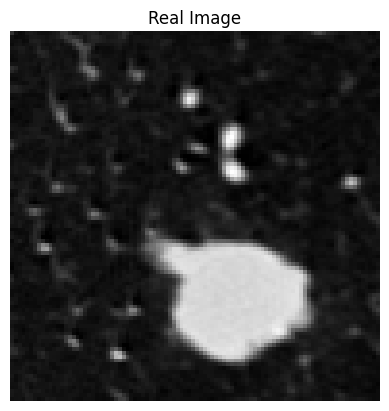

In [ ]:
# Assuming 'output' is your predicted segmentation output array of shape (200, 96, 96, 16, 2)
slice_idx = 0  # Select the slice index along the depth dimension to visualize

# Select the slice from the output array
slice_data = images[0, slice_idx, :, :, :]

# Assuming you want to visualize the segmentation mask of class 1
# mask = slice_data[..., 1]

# Plot the segmentation mask
plt.imshow(slice_data, cmap='gray')
plt.axis('off')
plt.title('Real Image')
plt.show()

In [ ]:
print(images.shape, labels.shape)

(3, 16, 96, 96, 1) (2792, 96, 96, 16, 1)


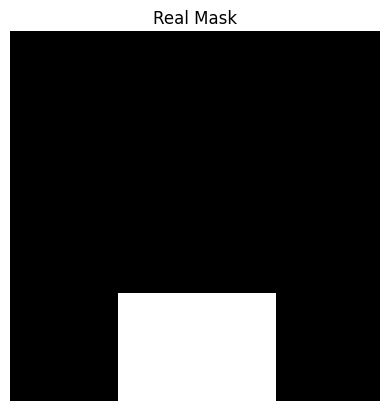

In [ ]:
# Assuming 'output' is your predicted segmentation output array of shape (200, 96, 96, 16, 2)
slice_idx = 0  # Select the slice index along the depth dimension to visualize

# Select the slice from the output array
slice_data = labels[0, :, :, slice_idx, :]

# Assuming you want to visualize the segmentation mask of class 1
# mask = slice_data[..., 1]

# Plot the segmentation mask
plt.imshow(slice_data, cmap='gray')
plt.axis('off')
plt.title('Real Mask')
plt.show()

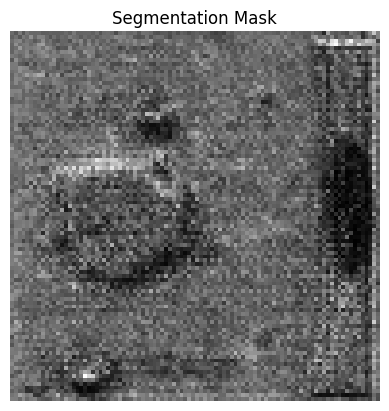

In [ ]:
# Assuming 'output' is your predicted segmentation output array of shape (200, 96, 96, 16, 2)
slice_idx = 0  # Select the slice index along the depth dimension to visualize

# Select the slice from the output array
slice_data = result[0, slice_idx, :, :, :]

# Assuming you want to visualize the segmentation mask of class 1
# mask = slice_data[..., 1]

# Plot the segmentation mask
plt.imshow(slice_data, cmap='gray')
plt.axis('off')
plt.title('Segmentation Mask')
plt.show()

In [ ]:
for tensor_name in tf.train.list_variables('/content/drive/MyDrive/Luna16_log/segmeation/model/Vnet3d.pd-50000'):
    print(tensor_name)

In [ ]:
x_test = images[0:4]

In [ ]:
loaded_model = tf.saved_model.load("/content/drive/MyDrive/LCD/LUNA16/my_model")

In [ ]:
# Get the inference function from the loaded model
inference_func = loaded_model.signatures["serving_default"]

# Assuming you have input data for prediction
input_data = x_test  # Your input data for prediction

# Make predictions using the loaded model
input_data = np.asarray(input_data, dtype=np.float32)
predictions = inference_func(tf.constant(input_data))

# # Access the output of the predictions
# output = predictions["output"]

# # Convert the output to a NumPy array if needed
# output = output.numpy()

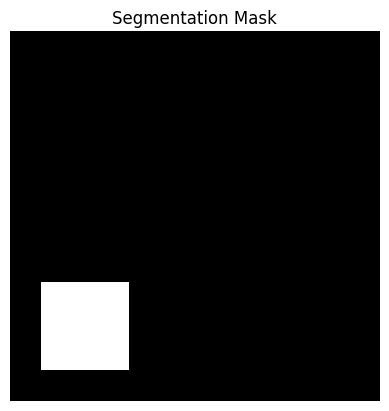

In [ ]:
# Assuming 'output' is your predicted segmentation output array of shape (200, 96, 96, 16, 2)
slice_idx = 10  # Select the slice index along the depth dimension to visualize

# Select the slice from the output array
slice_data = labels[1, :, :, slice_idx, :]

# Assuming you want to visualize the segmentation mask of class 1
# mask = slice_data[..., 1]

# Plot the segmentation mask
plt.imshow(slice_data, cmap='gray')
plt.axis('off')
plt.title('Segmentation Mask')
plt.show()

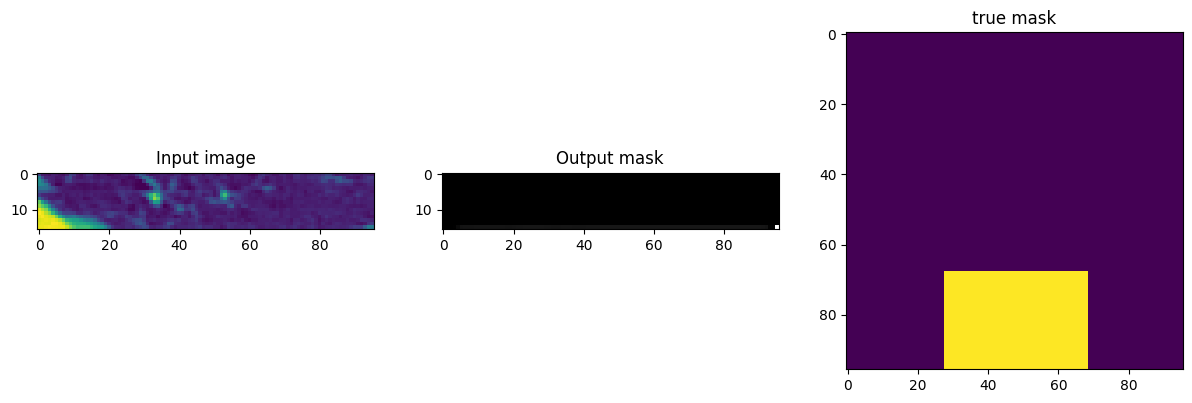

In [ ]:
slice_data = predictions['conv3d_25'][0][slice_idx, :, :, :]

# Assuming you want to visualize the segmentation mask of class 1
mask = slice_data[..., 1]

plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(x_test[0, :, :, slice_idx, :])
plt.title('Input image')
plt.subplot(1, 4, 2)
plt.imshow(mask, cmap='gray')
plt.title('Output mask')
plt.subplot(1, 4, 3)
plt.imshow(labels[0, :, :, slice_idx, :])
plt.title('true mask')
plt.show()

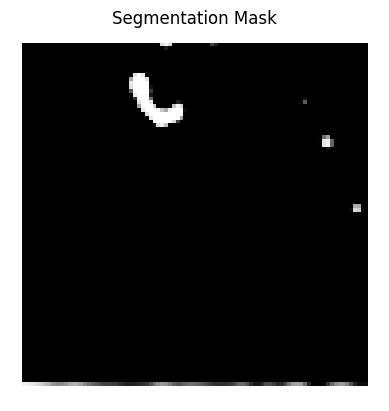

In [ ]:
# Assuming 'output' is your predicted segmentation output array of shape (200, 96, 96, 16, 2)
slice_idx = 10  # Select the slice index along the depth dimension to visualize

# Select the slice from the output array
slice_data = predictions['conv3d_25'][1, slice_idx, :, :, :]

# Assuming you want to visualize the segmentation mask of class 1
mask = slice_data[..., 0]

# Assuming you want to visualize the segmentation mask of class 1
# mask = slice_data[..., 1]

# Plot the segmentation mask
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Segmentation Mask')
plt.show()

In [ ]:
predictions['conv3d_25'].shape

TensorShape([4, 16, 96, 96, 2])

In [ ]:
import tensorflow as tf
import tensorflow.compat.v1.keras.backend as K

def convert_to_keras_model(saved_model_dir):
    # Load the TensorFlow 1.x saved model
    sess = tf.compat.v1.Session()
    saver = tf.compat.v1.train.import_meta_graph(saved_model_dir + '.meta')
    saver.restore(sess, saved_model_dir)

    # Convert the TensorFlow 1.x graph to a Keras model
    keras_graph = tf.compat.v1.get_default_graph()
    keras_model = tf.keras.models.model_from_config(keras_graph.get_config())

    # Transfer the weights from the TensorFlow 1.x model to the Keras model
    for src_var, dest_var in zip(keras_graph.get_collection('variables'), keras_model.trainable_variables):
        dest_var.assign(src_var.eval(session=sess))

    # Close the TensorFlow 1.x session
    sess.close()

    # Convert the Keras model to use TensorFlow 2.x style
    K.set_session(tf.compat.v1.keras.backend.get_session())

    return keras_model

# Path to the saved TensorFlow 1.x model
saved_model_dir = '/content/drive/MyDrive/Luna16_log/segmeation/model/Vnet3d.pd-50000'

# Convert the TensorFlow 1.x model to a Keras model
keras_model = convert_to_keras_model(saved_model_dir)

# Use the converted Keras model
keras_model.summary()


# Feature Extraction and Selection

The following cells will perfom the task of feature extraction, in order to apply it we should do the following:

* Extract the features from the predicted masks from the U-net model   
* process the features we got to apply a feature selection algorithm to them

In these cells I am going to write a code snippet only to load the model based on a saved weight to perfom a prediction on it,
then the predicted images will be processed, then the processed images should be enough to complete this phase



In [ ]:
# @title VGG16 Features Extraction

'''
In the following cell we load the VGG16 pretrained model without the last layer so that I can use it to extract the features out of my copped image
'''

base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
vgg16_features = np.empty((0, 2, 2, 512))

for x in X_cropped:
  rgb_image = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
  preprocessed_image = preprocess_input(rgb_image)
  preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
  features = base_model.predict(preprocessed_image)
  vgg16_features = np.concatenate((vgg16_features, features), axis=0)

In [ ]:
X_vgg16 = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/VGG16 Features/X_cropped_vgg16_features.npy')
X_gabor = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/Gabor Features/X_cropped_gabor.npy')
X_lbp = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/LBP Features/X_cropped_lbp.npy')
X_cropped = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/Cropped Images/X_cropped.npy')
y = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/Cropped Images/y_cropped.npy')

In [ ]:
import numpy as np

# Seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

# Create an index array and shuffle it
indices = np.arange(len(y))
np.random.shuffle(indices)

# Use the shuffled indices to shuffle all arrays
X_vgg16_shuffled = X_vgg16[indices]
X_gabor_shuffled = X_gabor[indices]
X_lbp_shuffled = X_lbp[indices]
X_cropped_shuffled = X_cropped[indices]
y_shuffled = y[indices]

In [ ]:
from sklearn.model_selection import train_test_split

X_train_vgg16, X_test_vgg16, y_train_vgg16, y_test_vgg16 = train_test_split(X_vgg16_shuffled, y_shuffled, test_size=0.1, shuffle=False)
X_train_gabor, X_test_gabor, y_train_gabor, y_test_gabor = train_test_split(X_gabor_shuffled, y_shuffled, test_size=0.1, shuffle=False)
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp = train_test_split(X_lbp_shuffled, y_shuffled, test_size=0.1, shuffle=False)
X_train_cropped, X_test_cropped, y_train_cropped, y_test_cropped = train_test_split(X_cropped_shuffled, y_shuffled, test_size=0.1, shuffle=False)

In [ ]:
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/VGG16 Features/X_train_vgg16.npy', X_train_vgg16)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/VGG16 Features/X_test_vgg16.npy', X_test_vgg16)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/VGG16 Features/y_train_vgg16.npy', y_train_vgg16)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/VGG16 Features/y_test_vgg16.npy', y_test_vgg16)

np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/Gabor Features/X_train_gabor.npy', X_train_gabor)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/Gabor Features/X_test_gabor.npy', X_test_gabor)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/Gabor Features/y_train_gabor.npy', y_train_gabor)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/Gabor Features/y_test_gabor.npy', y_test_gabor)

np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/LBP Features/X_train_lbp.npy', X_train_lbp)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/LBP Features/X_test_lbp.npy', X_test_lbp)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/LBP Features/y_train_lbp.npy', y_train_lbp)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/LBP Features/y_test_lbp.npy', y_test_lbp)

np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/Cropped Images/X_train_cropped.npy', X_train_cropped)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/Cropped Images/X_test_cropped.npy', X_test_cropped)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/Cropped Images/y_train_cropped.npy', y_train_cropped)
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/Cropped Images/y_test_cropped.npy', y_test_cropped)

In [ ]:
X = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2]))

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
X = scaler.fit_transform(X)

In [ ]:
# @title GLCM - LBP - Gabor Features Extraction

glcm_features_array = np.empty((0, 262144))
lbp_features_array = np.empty((0, 169))
gabor_features_array = np.empty((0, 2704))

for x, y_pred, label_val in zip(X_val, y_pred_val_unet_1, labels_val):
  try:
    roi_image_cropped = extract_roi_cropped_image(x, y_pred)
  except:
    continue
  resized_image = cv2.resize(roi_image_cropped[0], target_size)

  gabor_features = extract_gabor_features(resized_image)
  lbp_features = extract_lbp_features(resized_image)
  glcm_features = extract_glcm_features(resized_image)

  glcm_features_array = np.concatenate((glcm_features_array, np.expand_dims(np.array(glcm_features).flatten(), axis=1).T), axis=0)
  lbp_features_array = np.concatenate((lbp_features_array, np.expand_dims(np.array(lbp_features).flatten(), axis=1).T), axis=0)
  gabor_features_array = np.concatenate((gabor_features_array, np.expand_dims(np.array(gabor_features).flatten(), axis=1).T), axis=0)

  features_labels.append(float(label_val[0]))

for x, y_pred, label_test in zip(X_test, y_pred_test_unet_1, labels_val):
  try:
    roi_image_cropped = extract_roi_cropped_image(x, y_pred)
  except:
    continue
  resized_image = cv2.resize(roi_image_cropped[0], target_size)

  gabor_features = extract_gabor_features(resized_image)
  lbp_features = extract_lbp_features(resized_image)
  glcm_features = extract_glcm_features(resized_image)

  glcm_features_array = np.concatenate((glcm_features_array, np.expand_dims(np.array(glcm_features).flatten(), axis=1).T), axis=0)
  lbp_features_array = np.concatenate((lbp_features_array, np.expand_dims(np.array(lbp_features).flatten(), axis=1).T), axis=0)
  gabor_features_array = np.concatenate((gabor_features_array, np.expand_dims(np.array(gabor_features).flatten(), axis=1).T), axis=0)

  features_labels.append(float(label_test[0]))

for x, y_pred, label_train in zip(X_train, y_pred_train_unet_1, labels):
  try:
    roi_image_cropped = extract_roi_cropped_image(x, y_pred)
  except:
    continue
  resized_image = cv2.resize(roi_image_cropped[0], target_size)

  gabor_features = extract_gabor_features(resized_image)
  lbp_features = extract_lbp_features(resized_image)
  glcm_features = extract_glcm_features(resized_image)

  glcm_features_array = np.concatenate((glcm_features_array, np.expand_dims(np.array(glcm_features).flatten(), axis=1).T), axis=0)
  lbp_features_array = np.concatenate((lbp_features_array, np.expand_dims(np.array(lbp_features).flatten(), axis=1).T), axis=0)
  gabor_features_array = np.concatenate((gabor_features_array, np.expand_dims(np.array(gabor_features).flatten(), axis=1).T), axis=0)

  features_labels.append(float(label_train[0]))

features_labels = np.array(features_labels)

In [ ]:
# @title GLCM - LBP - Gabor
from skimage.filters import gabor
from skimage.feature import local_binary_pattern, graycomatrix

def extract_gabor_features(image):
  """Extracts features of an image using Gabor filter."""
  filters = []
  for theta in range(4):
    for frequency in (0.05, 0.25):
      kernel = gabor(image, frequency, theta=theta / 4. * np.pi, sigma_x=1, sigma_y=1)
      filters.append(kernel[0])
  features = []
  for filter in filters:
    feature = filter * image
    features.append(feature)
  return np.sum(features, axis=0)

def extract_glcm_features(image):
  """Extracts features of an image using GLCM filter."""

  image = image.astype('uint8')

  glcm = graycomatrix(image, [1, 2], [0, np.pi / 4], levels=256, normed=True)

  features = glcm.flatten()
  features = features.astype('float32')

  return features

def extract_lbp_features(image):
  """Extracts features of an image using LBP filter."""

  radius = 2
  neighbors = 8 * radius
  lbp_operator = local_binary_pattern(image, neighbors, radius, 'uniform')
  features = lbp_operator

  return features

# gabor_features = extract_gabor_features(np.squeeze(roi_image, axis=-1))
# lbp_feature = extract_lbp_features(np.squeeze(roi_image, axis=-1))
# glcm_features = extract_glcm_features(np.squeeze(roi_image, axis=-1))

# gabor filter array dimension (8, 2, 13, 13)
# lbp array dimension (169,)
# glcm array dimension (262144,)


In [ ]:
X_contextual = np.empty((0, 64, 64, 16))
dim = (64, 64)
for x in X:
  img1 = x[:32, :32]
  img2 = x[:32, 32:]
  img3 = x[32:, :32]
  img4 = x[32:, 32:]

  img1_tl = cv2.resize(img1[:16, :16].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img1_tr = cv2.resize(img1[:16, 16:].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img1_bl = cv2.resize(img1[16:, :16].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img1_br = cv2.resize(img1[16:, 16:].astype(np.float64), dim, interpolation = cv2.INTER_AREA)

  img2_tl = cv2.resize(img2[:16, :16].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img2_tr = cv2.resize(img2[:16, 16:].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img2_bl = cv2.resize(img2[16:, :16].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img2_br = cv2.resize(img2[16:, 16:].astype(np.float64), dim, interpolation = cv2.INTER_AREA)

  img3_tl = cv2.resize(img3[:16, :16].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img3_tr = cv2.resize(img3[:16, 16:].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img3_bl = cv2.resize(img3[16:, :16].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img3_br = cv2.resize(img3[16:, 16:].astype(np.float64), dim, interpolation = cv2.INTER_AREA)

  img4_tl = cv2.resize(img4[:16, :16].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img4_tr = cv2.resize(img4[:16, 16:].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img4_bl = cv2.resize(img4[16:, :16].astype(np.float64), dim, interpolation = cv2.INTER_AREA)
  img4_br = cv2.resize(img4[16:, 16:].astype(np.float64), dim, interpolation = cv2.INTER_AREA)

  stacked_array = np.stack([img1_tl, img1_tr, img1_bl, img1_br,
                            img2_tl, img2_tr, img2_bl, img2_br,
                            img3_tl, img3_tr, img3_bl, img3_br,
                            img4_tl, img4_tr, img4_bl, img4_br], axis=2)

  # X_lbp_contextual = np.concatenate((X_lbp_contextual, stacked_array[np.newaxis, ...]), axis=0)
  X_contextual = np.concatenate((X_contextual, stacked_array[np.newaxis, ...]), axis=0)




In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create 16 random images for demonstration purposes (replace with your images)
images = np.array([img1_tl, img1_tr, img2_tl, img2_tr,
                   img1_bl, img1_br, img2_bl, img2_br,
                   img3_tl, img3_tr, img4_tl, img4_tr,
                   img3_bl, img3_br, img4_bl, img4_br])

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Number of images and their dimensions
num_images = len(images)
image_height, image_width = images[0].shape

# Create a grid of x and z coordinates for each image
x, z = np.meshgrid(np.arange(image_width), np.arange(num_images))

# Stack images horizontally along the x-axis
for y, image in enumerate(images):
    ax.plot_surface(x, y * np.ones_like(x), z, facecolors=plt.cm.gray(image))

# Set the axis labels
ax.set_xlabel('X (Image Width)')
ax.set_ylabel('Y (Image Index)')
ax.set_zlabel('Z (Image Height)')

# Set the y-axis limits
ax.set_ylim(0, num_images)

# Show the plot
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have a dataset X of shape (4569, 16, 16, 16) and labels y

# Define the split ratios
test_size = 0.2  # 20% for testing, adjust as needed

# Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X_lbp_contextual, y_cropped, test_size=test_size, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Now you have X_train, y_train, X_test, y_test as your training and testing sets


In [ ]:
# @title PCA Maximum n_components

def compute_n_components(np_array, epsilon=0.001):
  for i in range(len(np_array) - 1):
    if abs(np_array[i + 1] - np_array[i]) <= epsilon:
      return i
  return -1

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_ft = PCA()
pca_ft.fit(X)

explained_variance_ratio = pca_ft.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
optimal_n = compute_n_components(cumulative_variance_ratio)

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Ratio')
plt.title('Scree Plot')
plt.axvline(x=optimal_n, color='red', linestyle='--', label='Elbow Point')
plt.show()

In [ ]:
# @title PCA for Dimensionality Reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=optimal_n)
X = pca.fit_transform(X)
print("Shape of reduced cluster vectors (PCA):", X.shape)

Shape of reduced cluster vectors (PCA): (4569, 95)


In [ ]:
# @title Agglomerative Clustering

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Perform Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters=2)
clustering.fit(X)
cluster_labels = clustering.labels_

In [ ]:
cluster_zero = X[cluster_labels == 0]
cluster_one = X[cluster_labels == 1]

cluster_zero_labels = y[cluster_labels == 0]
cluster_one_labels = y[cluster_labels == 1]

In [ ]:
print(cluster_one.shape)
print(cluster_zero.shape)
print(cluster_one_labels[cluster_one_labels == 0].shape)
print(cluster_zero_labels[cluster_zero_labels == 0].shape)
print(cluster_one_labels[cluster_one_labels == 1].shape)
print(cluster_zero_labels[cluster_zero_labels == 1].shape)

In [ ]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_classif
cluster_zero_selector = SelectKBest(f_classif, k=80)
cluster_one_selector = SelectKBest(f_classif, k=80)

cluster_zero_k_best = cluster_zero_selector.fit_transform(cluster_zero, cluster_zero_labels)
cluster_one_k_best = cluster_one_selector.fit_transform(cluster_one, cluster_one_labels)

In [ ]:
X = np.concatenate((cluster_zero_k_best, cluster_one_k_best), axis=0)
y = np.concatenate((cluster_zero_labels, cluster_one_labels), axis=0)

In [ ]:
# @title ADASYN Oversampling

import numpy as np
from collections import Counter
from imblearn.over_sampling import ADASYN

# Check the original class distribution
# print("Original class distribution:", Counter(glcm_features_array))

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_zero_resampled, y_zero_resampled = adasyn.fit_resample(cluster_zero_k_best, cluster_zero_labels)
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_one_resampled, y_one_resampled = adasyn.fit_resample(cluster_one_k_best, cluster_one_labels)
# adasyn = ADASYN(sampling_strategy='auto', random_state=42)
# X_resampled, y_resampled = adasyn.fit_resample(reduced_features_vectors, reduced_features_labels)

# Check the new class distribution
# print("Resampled class distribution:", Counter(y_resampled))

X_resampled = np.concatenate((X_one_resampled, X_zero_resampled), axis=0)
y_resampled = np.concatenate((y_one_resampled, y_zero_resampled), axis=0)

In [ ]:
# @title Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint

def get_callbacks_list(i):
  checkpoint = ModelCheckpoint(
    filepath=f"x_cropped_best_model_fold{i}.h5",  # Filepath to save the best model
    monitor='val_accuracy',    # Metric to monitor for saving the best model
    save_best_only=True,       # Save only the best model
    mode='max',                # Maximize the monitored metric
    verbose=1                   # Display messages about the saving process
  )
  early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=50)
  plot_learning = PlotLearning()

  return [early_stopping_cb, plot_learning, checkpoint]

In [ ]:
# @title Plot Learning

from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [ ]:
# @title 1D CNN Approach

import numpy as np
from keras.api._v2.keras.layers import MaxPool1D
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, AvgPool1D, BatchNormalization


def get_1dcnn_model():
  # Create model
  model = Sequential()

  # Add model layers
  model.add(Conv1D(64, kernel_size=7, activation='leaky_relu', input_shape=(optimal_n, 1)))
  model.add(AvgPool1D(5))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(128, activation='leaky_relu', kernel_regularizer=keras.regularizers.l2(0.05)))
  model.add(Dropout(0.8))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  Adam = keras.optimizers.Adam(0.0001)
  model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
# @title 2D CNN Approach

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have your dataset loaded and preprocessed, and X contains images and y contains labels (0 or 1).

# Split the data into training and testing sets (e.g., 80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

def get_2dcnn_model():
  # Create a Sequential model
  model = Sequential()

  # Convolutional Layer 1
  model.add(Conv2D(32, (5, 5), activation='leaky_relu', input_shape=(64, 64, 1)))
  model.add(MaxPooling2D((3, 3)))

  # Convolutional Layer 2
  model.add(Conv2D(16, (3, 3), activation='leaky_relu'))
  model.add(MaxPooling2D((2, 2)))

  # Flatten the feature maps
  model.add(Flatten())

  # Fully Connected Layer 1
  model.add(Dense(128, activation='leaky_relu'))

  # Dropout layer to reduce overfitting
  model.add(Dropout(0.8))

  # Output Layer
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
# @title 2D CNN VGG16
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Input, Concatenate
from keras.models import Model


def get_vgg16_model(input_shape=(64, 64, 1), num_classes=1):
    # Load the pre-trained VGG16 model without the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 16))

    # Create a Sequential model
    model = Sequential()

    # Add an input layer that replicates the single channel to three channels
    input_layer = Input(shape=input_shape)
    x = Concatenate()([input_layer, input_layer, input_layer])  # Replicate the single channel
    x = base_model(x)  # Pass the replicated input through VGG16
    model.add(Model(inputs=input_layer, outputs=x))

    # Flatten the feature maps
    model.add(Flatten())

    # Add a fully connected layer with 128 units and 'relu' activation
    model.add(Dense(128, activation='relu'))

    # Add a dropout layer to reduce overfitting
    model.add(Dropout(0.5))

    # Add the output layer with one unit and 'sigmoid' activation for binary classification
    model.add(Dense(num_classes, activation='sigmoid'))

    # Compile the model with a custom learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# @title 2D CNN MobileNet

from keras.applications import MobileNet
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Input, Concatenate
from keras.models import Model

def get_mobilenet_model(input_shape=(64, 64, 1), num_classes=1):
    # Load the pre-trained MobileNet model without the top (fully connected) layers
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    # Create a Sequential model
    model = Sequential()

    # Add an input layer that replicates the single channel to three channels
    input_layer = Input(shape=input_shape)
    x = Concatenate()([input_layer, input_layer, input_layer])  # Replicate the single channel
    x = base_model(x)  # Pass the replicated input through MobileNet
    model.add(Model(inputs=input_layer, outputs=x))

    # Flatten the feature maps
    model.add(Flatten())

    # Add a fully connected layer with 128 units and 'relu' activation
    model.add(Dense(128, activation='relu'))

    # Add a dropout layer to reduce overfitting
    model.add(Dropout(0.5))

    # Add the output layer with one unit and 'sigmoid' activation for binary classification
    model.add(Dense(num_classes, activation='sigmoid'))

    # Compile the model with a custom learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# @title 3D CNN Approach

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, AveragePooling3D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

def get_3dcnn_model():

  # Create a Sequential model
  model = keras.Sequential()

  # 3D Convolutional Layers
  model.add(Conv3D(16, kernel_size=(5, 5, 5), activation='leaky_relu', kernel_initializer=tf.keras.initializers.GlorotUniform(), input_shape=(16, 16, 16, 1)))

  model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='leaky_relu', kernel_initializer=tf.keras.initializers.GlorotUniform(), kernel_regularizer=keras.regularizers.l2(0.1)))

  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  # Flatten the feature maps
  model.add(Flatten())

  # Fully Connected Layer 1
  model.add(Dense(64, activation='leaky_relu', kernel_initializer=tf.keras.initializers.GlorotUniform(), kernel_regularizer=keras.regularizers.l2(0.15)))

  model.add(Dropout(0.5))

  # Output Layer
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
# @title K-Fold Neural Network

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow import keras
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import LearningRateScheduler
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight

results = []
i = 0
num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

OOF = np.zeros((y.shape[0]))

# Perform K-fold cross-validation
for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  i += 1
  # model = get_1dcnn_model()
  # model = get_2dcnn_model()
  model = get_vgg16_model()
  # model = get_mobilenet_model(input_shape=(64, 64, 1), num_classes=1)

  callbacks_list = get_callbacks_list(i)

  # history = model.fit(X_train, y_train, epochs=256, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks_list)
  history = model.fit(X_train, y_train, epochs=256, batch_size=128, validation_data=(X_test, y_test), callbacks=callbacks_list)
  # history = model.fit(X_train, y_train, epochs=256, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks_list)

  predictions = model.predict(X_test)
  y_pred = np.round(predictions)

  OOF[test_index] = y_pred.T.squeeze(axis=0)

  accuracy = accuracy_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  results.append((accuracy, auc, f1, recall, precision))

oof_accuracy = accuracy_score(y, OOF)
print(f"Out of Fold Accuracy: {oof_accuracy:.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score

# y_pred = best_SVC.svm_classifier.predict(X_test)
OOF = oof

# Calculate accuracy
accuracy = accuracy_score(y, OOF)

# Calculate AUC (Area Under the ROC Curve)
# Note: This applies only if you have a binary classification problem
auc = roc_auc_score(y, OOF)

# Calculate F1 score
f1 = f1_score(y, OOF)

# Calculate recall (sensitivity)
recall = recall_score(y, OOF)

# Calculate precision (positive predictive value)
precision = precision_score(y, OOF)

# Print or use the calculated metrics as needed
print("Accuracy:", accuracy)
print("AUC:", auc)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
# model = get_model()  # Assuming you have defined the get_model function as in your initial code

# Save the visualization as an image file (e.g., 'model.png')
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
X = reduced_features_vectors
y = reduced_features_labels

In [ ]:
# @title SVC

import numpy as np
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from collections import namedtuple
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight

# Initialize the KFold with n_splits=10 (10 folds)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Set the custom threshold for binary predictions
custom_threshold = 0.5

# Initialize an array to store predictions from the SVC classifier
oof = np.zeros(X.shape[0])

# Perform 10-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Optionally, you can apply ADASYN for class imbalance
    # adasyn = ADASYN(sampling_strategy='minority', random_state=42)
    # X_train, y_train = adasyn.fit_resample(X_train, y_train)

    # Create the Support Vector Classifier with the desired hyperparameters
    svc_classifier = SVC(C=50, kernel='poly', probability=False, random_state=42)

    # Train the SVC classifier on the training data
    svc_classifier.fit(X_train, y_train)

    # Make probability predictions on the test data using the SVC classifier
    # y_prob = svc_classifier.predict_proba(X_test)[:, 1]

    y_pred = svc_classifier.predict(X_test)

    # Apply the custom threshold for binary predictions
    # y_pred = (y_prob >= custom_threshold).astype(int)

    # Calculate accuracy for the SVC classifier and print it
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Fold {fold}: Test Accuracy (SVC Classifier) = {accuracy:.4f}")

    # Set oof_ensemble[test_index] based on the predictions
    oof[test_index] = y_pred

oof_accuracy = accuracy_score(y, oof)
print(f"oof Accuracy: {oof_accuracy:.4f}")

In [ ]:
# @title Confusion Matrix

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have the ground truth labels for the test data stored in "y_test"
# and the predictions made on the test data stored in "binary_predictions"

# Calculate the confusion matrix
cm = confusion_matrix(y, oof)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [ ]:
# @title LCDExperiment Class

class LCDExperiment:
  def __init__(self, classifier=None, name='', scores=None, probability_threshold=None, probability=False, dimensionality_reduction=None, fs=None, clustering=None, feature_type=None):
    if probability:
      assert probability_threshold is not None and 0. <= probability_threshold <= 0.99, "probability_threshold must be in range between 0 and 1."
    assert isinstance(scores, Scores), "Please provide the scores."
    if fs:
      assert isinstance(fs, list) and clustering is not None, "fs should be a list of feature selection methods, and a clutering method should be provided."
    self.classifier = classifier
    self.scores = scores
    self.probability_threshold = probability_threshold
    self.probability = probability
    self.dimensionality_reduction = dimensionality_reduction
    self.fs = fs
    self.clustering = clustering
    self.feature_type = feature_type
    self.name = name

  def transform(self, X):
    if not self.dimensionality_reduction and not self.fs:
      return X
    elif not self.fs:
      scaler = StandardScaler()
      scaler.fit(X)
      X = scaler.transform(X)
      return self.dimensionality_reduction.transform(X)
    elif not self.dimensionality_reduction:
      pred_cluster = self.clustering.fit_predict(X)
      res = []
      for cluster in np.unique(pred_cluster):
        res.append(self.fs[int(cluster)].transform(X[pred_cluster == cluster]))
      return res
    else:
      scaler = StandardScaler()
      scaler.fit(X)
      X = scaler.transform(X)
      pred_cluster = self.clustering.fit_predict(X)
      res = []
      for cluster in np.unique(pred_cluster):
        res.append(self.fs[int(cluster)].transform(self.dimensionality_reduction.transform(X[pred_cluster == cluster])))
      return res

In [ ]:
# @title Scores Class
class Scores:
  def __init__(self, accuracy, auc, precision, recall, f1_score):
    self.accuracy = accuracy
    self.auc = auc
    self.precision = precision
    self.recall = recall
    self.f1_score = f1_score

In [ ]:
# @title Decision Profile Class

class DecisionProfile:
  def __init__(self, mode='hard', experiments=None, weights=None, operators=None, probability=True, default_probability=0.5):
    assert mode in ['hard', 'soft', 'weighted', 'custom'], "mode should be one of these options: hard, soft, weighted, custom."
    if mode == 'weighted':
      assert weights is not None, "You should specify a list of weights if the mode is weighted."
    if mode == 'weighted':
      assert (isinstance(weights, list) or isinstance(weights, np.ndarray)) and sum(weights) == 1.0, "The sum of all weights should be equal to 1.0."
    if mode == 'weighted':
      assert len(weights) == len(experiments), "The number of weights should be the same as the number of experiments."
    if mode == 'custom':
      assert operators is None, "You should specify a list of operators with a length equals to the (#experiments - 1)."
    if mode == 'custom':
      assert len(operators) == (len(experiments) - 1), "The operators should be the length of (#experiments - 1)."
    assert isinstance(experiments, list), "experiments are required."
    if mode == 'hard':
      assert not probability, "You should set probability to False to apply 'hard' mode aggregation."
    self.mode = mode
    self.experiments = experiments
    self.operators = operators
    self.weights = weights
    self.probability = probability
    self.default_probability = default_probability
    self.predictions = []
    self.probabilities = []
    self.op_dict = {
        '+': np.add,
        '-': np.subtract,
        '*': np.multiply,
        '/': np.divide,
        '&': np.bitwise_and,
        '|': np.bitwise_or,
        'avg': np.mean,
    }


  def fit(self, X):
    if self.probability:
      self.fit_proba(X)
    else:
      self.fit_normal(X)

  def fit_proba(self, X):
    self.probabilities = []
    for experiment in self.experiments:
      x = X[experiment.feature_type][experiment.name]
      if hasattr(experiment.classifier, 'predict_proba'):
        y_pred_proba = experiment.classifier.predict_proba(x)
        self.probabilities.append(y_pred_proba)
      else:
        raise AttributeError(f"Classifier {experiment.name} doesn't have an attribute predict_proba.")

  def fit_normal(self, X):
    self.predictions = []
    for experiment in self.experiments:
      x = X[experiment.feature_type][experiment.name]
      if hasattr(experiment.classifier, 'predict'):
        y_pred = experiment.classifier.predict(x)
        self.predictions.append(y_pred)
      else:
        raise AttributeError(f"Classifier {experiment.name} doesn't have an attribute predict.")

  def apply_aggregation(self):
    aggregation_method = getattr(self, f"{self.mode}_aggregation")
    aggregation_res = aggregation_method()
    self.aggregation_res = aggregation_res
    return aggregation_res

  def soft_aggregation(self):
    y_pred_sum = None
    for probability_prediction in self.probabilities:
      if y_pred_sum is None:
        y_pred_sum = probability_prediction.copy()
      else:
        y_pred_sum += probability_prediction
    y_pred_sum /= float(len(self.experiments))
    y_pred = np.where(y_pred_sum[:, 1] >= self.default_probability, 1, 0)
    return y_pred


  def weighted_aggregation(self):
    y_pred_weighted = None
    for probability_prediction, weight in zip(self.probabilities, self.weights):
      probability_prediction = probability_prediction * weight
      if y_pred_weighted is None:
        y_pred_weighted = probability_prediction.copy()
      else:
        y_pred_weighted += probability_prediction
    y_pred = np.where(y_pred_weighted[:, 1] >= self.default_probability, 1, 0)
    return y_pred

  def hard_aggregation(self):
    y_pred_sum = []
    for prediction in self.predictions:
      y_pred = prediction
      y_pred_sum.append(y_pred)
    if len(y_pred_sum) == 1:
      return y_pred_sum
    y_pred_sum = np.array(y_pred_sum).T
    return np.where(y_pred_sum.sum(axis=1) >= (y_pred_sum.shape[1] / 2), 1, 0)

  def custom_aggregation(self):
    accumelated_res = self.probabilities[i][:, 1]
    for i in range(len(self.experiments) - 1):
      if self.operators[i] not in self.op_dict.keys():
        raise ValueError(f"Operator {self.operators[i]} is not valid.")
      accumelated_res = self.op_dict[self.operators[i]](accumelated_res, self.probabilities[i+1][:, 1])
    return accumelated_res

In [ ]:
# @title Pre-preocessing Class

class SegmentationError(Exception):
  def __init__(self, message):
    self.message = message
    super().__init__(self.message)

class PreProcessing:
  def __init__(self, unet_model=None, vgg16_model=None):
    self.unet_model = unet_model
    self.vgg16_model = vgg16_model

  def __resize(self, input_image,):
    input_image = input_image.astype(np.float32)
    input_image = cv2.resize(input_image, dsize=(128, 128))
    return input_image

  def __expand_dimension(self, X_train):
    X_train = np.array(X_train)
    if len(X_train.shape) < 4:
      X_train=np.expand_dims(X_train, axis=-1)

    return X_train

  def __normalize(self, input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

  def __preprocess(self, x, imgs):
    xt = []
    for i in tq(range(len(imgs))):
      x = self.__resize(np.array(imgs[i]))
      x = self.__normalize(x)
      xt.append(x)
    return xt

  def apply_segmentation(self, X):
    if not self.unet_model:
      raise SegmentationError("You haven't included a segmentation model.")
    X_processed = self.__preprocess([], X)
    X_processed = self.__expand_dimension(X_processed)
    y_pred = self.unet_model.predict(X_processed)
    y_pred = np.argmin(y_pred, axis=-1)
    if len(X.shape) == 2 or (len(X.shape) == 3 and X.shape[0] == 1):
      try:
        if len(X.shape) == 2:
          roi_image_cropped = self.__extract_roi_cropped_image(X_processed, y_pred)
        else:
          roi_image_cropped = self.__extract_roi_cropped_image(X_processed[0], y_pred)
      except SegmentationError as e:
        print(f"Segmentation Error: {e}")
      return roi_image_cropped
    else:
      cropped_images = []
      for x, y in zip(X_processed, y_pred):
        try:
          roi_image_cropped = self.__extract_roi_cropped_image(x, y)
          cropped_images.append(roi_image_cropped[0])
        except:
          continue
      return np.array(cropped_images)

  def extract_features(self, X, feature_type=None, all_features=False):
    if isinstance(feature_type, str):
        assert feature_type in ['vgg16', 'lbp', 'gabor'], "feature_type should be one of the following: 'vgg16', 'gabor', 'lbp'"
        assert not all_features, "If feature_type is specified, all_features should be False."
    if feature_type is None:
        assert all_features, "If feature_type is not specified, all_features should be True."

    if len(X.shape) == 2:
      if feature_type is not None:
        if feature_type == 'vgg16':
          rgb_image = cv2.cvtColor(X, cv2.COLOR_GRAY2RGB)
          preprocessed_image = preprocess_input(rgb_image)
          preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
          vgg16_features = self.vgg16_model.predict(preprocessed_image)
          return vgg16_features

        elif feature_type == 'lbp':
          return self.__extract_lbp_features(X)

        elif feature_type == 'gabor':
          return self.__extract_gabor_features(X)
      else:
        rgb_image = cv2.cvtColor(X, cv2.COLOR_GRAY2RGB)
        preprocessed_image = preprocess_input(rgb_image)
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
        vgg16_features = self.vgg16_model.predict(preprocessed_image)

        gabor_features = self.__extract_gabor_features(X)
        lbp_features = self.__extract_lbp_features(X)

        return {
            'vgg16': [vgg16_features],
            'lbp': [lbp_features],
            'gabor': [gabor_features]
            }

    else:
      if feature_type is not None:
        if feature_type == 'vgg16':
          vgg16_features_list = []
          for x in X:
            rgb_image = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
            preprocessed_image = preprocess_input(rgb_image)
            preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
            vgg16_features = self.vgg16_model.predict(preprocessed_image)
            vgg16_features_list.append(vgg16_features)
          return vgg16_features_list

        elif feature_type == 'lbp':
          return [self.__extract_lbp_features(x) for x in X]

        elif feature_type == 'gabor':
          return [self.__extract_gabor_features(x) for x in X]
      else:
        features_dict = {key: [] for key in {'vgg16', 'lbp', 'gabor'}}
        for x in X:
          rgb_image = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
          preprocessed_image = preprocess_input(rgb_image)
          preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
          vgg16_features = self.vgg16_model.predict(preprocessed_image)

          gabor_features = self.__extract_gabor_features(x)
          lbp_features = self.__extract_lbp_features(x)
          features_dict['lbp'].append(lbp_features)
          features_dict['gabor'].append(gabor_features)
          features_dict['vgg16'].append(vgg16_features)

        return features_dict

  def __extract_roi_cropped_image(self, image, mask):
    mask = np.uint8(mask == 0)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    roi_image = image[y:y+h, x:x+w]
    if 0 in roi_image.shape:
      raise SegmentationError("No ROI to extract.")
    return roi_image , (x, y, w, h)

  def __extract_gabor_features(self, image):
    """Extracts features of an image using Gabor filter."""
    filters = []
    for theta in range(4):
      for frequency in (0.05, 0.25):
        kernel = gabor(image, frequency, theta=theta / 4. * np.pi, sigma_x=1, sigma_y=1)
        filters.append(kernel[0])
    features = []
    for filter in filters:
      feature = filter * image
      features.append(feature)
    return np.sum(features, axis=0)

  def __extract_lbp_features(self, image):
    """Extracts features of an image using LBP filter."""

    radius = 2
    neighbors = 8 * radius
    lbp_operator = local_binary_pattern(image, neighbors, radius, 'uniform')
    features = lbp_operator

    return features

In [ ]:
# @title **To Be Transfared to a Newer Notebook**

#LBP, VGG16, Gabor Features SVC Experiments (RBF, POLY), (PCA, PCA & Feature Selection, Just LBP Features)

X_train = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/Cropped Images/X_train_cropped.npy')
y_train = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/VGG16 Features/y_train_vgg16.npy')
X_test = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/Cropped Images/X_test_cropped.npy')
y_test = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/VGG16 Features/y_test_vgg16.npy')

In [ ]:
X_train_flatten = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_flatten = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)

In [ ]:
# @title PCA for Dimensionality Reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=238)
X_train = pca.fit_transform(X_train)
print("Shape of reduced cluster vectors (PCA):", X_train.shape)
X_test = pca.transform(X_test)
print("Shape of reduced cluster vectors (PCA):", X_test.shape)

Shape of reduced cluster vectors (PCA): (4112, 238)
Shape of reduced cluster vectors (PCA): (457, 238)


In [ ]:
# @title Agglomerative Clustering

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Perform Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters=2)
clustering.fit(X_train)
X_train_cluster_labels = clustering.labels_
X_test_cluster_labels = clustering.fit_predict(X_test)

In [ ]:
X_train_cluster_zero = X_train[X_train_cluster_labels == 0]
X_train_cluster_one = X_train[X_train_cluster_labels == 1]
X_train_cluster_zero_labels = y_train[X_train_cluster_labels == 0]
X_train_cluster_one_labels = y_train[X_train_cluster_labels == 1]

X_test_cluster_zero = X_test[X_test_cluster_labels == 0]
X_test_cluster_one = X_test[X_test_cluster_labels == 1]
X_test_cluster_zero_labels = y_test[X_test_cluster_labels == 0]
X_test_cluster_one_labels = y_test[X_test_cluster_labels == 1]

In [ ]:
print(X_train_cluster_one.shape)
print(X_train_cluster_zero.shape)
print(X_train_cluster_one_labels[X_train_cluster_one_labels == 0].shape)
print(X_train_cluster_zero_labels[X_train_cluster_zero_labels == 0].shape)
print(X_train_cluster_one_labels[X_train_cluster_one_labels == 1].shape)
print(X_train_cluster_zero_labels[X_train_cluster_zero_labels == 1].shape)

print(X_test_cluster_one.shape)
print(X_test_cluster_zero.shape)
print(X_test_cluster_one_labels[X_test_cluster_one_labels == 0].shape)
print(X_test_cluster_zero_labels[X_test_cluster_zero_labels == 0].shape)
print(X_test_cluster_one_labels[X_test_cluster_one_labels == 1].shape)
print(X_test_cluster_zero_labels[X_test_cluster_zero_labels == 1].shape)

(1492, 238)
(2620, 238)
(708,)
(1329,)
(784,)
(1291,)
(205, 238)
(252, 238)
(109,)
(138,)
(96,)
(114,)


In [ ]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_classif
cluster_zero_selector = SelectKBest(f_classif, k=220)
cluster_one_selector = SelectKBest(f_classif, k=220)

X_train_cluster_zero_k_best = cluster_zero_selector.fit_transform(X_train_cluster_zero, X_train_cluster_zero_labels)
X_train_cluster_one_k_best = cluster_one_selector.fit_transform(X_train_cluster_one, X_train_cluster_one_labels)
X_test_cluster_zero_k_best = cluster_zero_selector.transform(X_test_cluster_zero)
X_test_cluster_one_k_best = cluster_one_selector.transform(X_test_cluster_one)

In [ ]:
X_train = np.concatenate((X_train_cluster_one_k_best, X_train_cluster_zero_k_best), axis=0)
y_train = np.concatenate((X_train_cluster_one_labels, X_train_cluster_zero_labels), axis=0)
X_test = np.concatenate((X_test_cluster_one_k_best, X_test_cluster_zero_k_best), axis=0)
y_test = np.concatenate((X_test_cluster_one_labels, X_test_cluster_zero_labels), axis=0)

In [ ]:
!pip install lime

In [ ]:
# @title SVC

import numpy as np
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from collections import namedtuple
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight

svc_classifier = SVC(C=50, kernel='rbf', probability=True, random_state=42)

svc_classifier.fit(X_train_flatten, y_train)

y_pred = svc_classifier.predict(X_test_flatten)

accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9365


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score

# y_pred = best_SVC.svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate AUC (Area Under the ROC Curve)
# Note: This applies only if you have a binary classification problem
auc = roc_auc_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)

# Calculate precision (positive predictive value)
precision = precision_score(y_test, y_pred)

# Print or use the calculated metrics as needed
print("Accuracy:", accuracy)
print("AUC:", auc)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)


Accuracy: 0.8468271334792122
AUC: 0.8461731251204935
F1 Score: 0.8341232227488152
Recall: 0.8380952380952381
Precision: 0.8301886792452831


<Axes: >

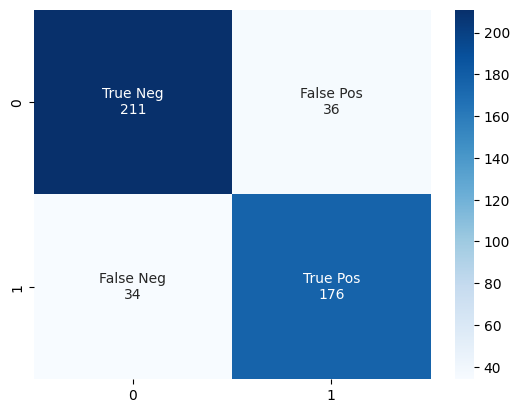

In [ ]:
# @title Confusion Matrix

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have the ground truth labels for the test data stored in "y_test"
# and the predictions made on the test data stored in "binary_predictions"

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [ ]:
e.__dict__

In [ ]:
scores = Scores(accuracy=accuracy,
                recall=recall,
                precision=precision,
                f1_score=f1,
                auc=auc)

lcd_experiment = LCDExperiment(svc_classifier,
                               'svc_vgg16_exp3',
                               scores=scores,
                               dimensionality_reduction=pca,
                              #  fs=[cluster_zero_selector, cluster_one_selector],
                              #  clustering=clustering,
                               feature_type='vgg16')

In [ ]:
np.save('/content/drive/MyDrive/LCD/candidates_and_annotations/VGG16 Features/LCD Experiments/svc_vgg16_exp3.npy', lcd_experiment)

In [ ]:
folders = ['VGG16', 'LBP', 'Gabor']
files = ['vgg16', 'lbp', 'gabor']
experiments = []

for fo, fi in zip(folders, files):
  for i in range(6):
    experiment = np.load(f'/content/drive/MyDrive/LCD/candidates_and_annotations/{fo} Features/LCD Experiments/svc_{fi}_exp{i+1}.npy', allow_pickle=True).tolist()
    experiments.append(experiment)

In [ ]:
X_test = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/Cropped Images/X_test_cropped.npy')
y_test = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/LBP Features/y_test_lbp.npy')

In [ ]:
lcd_experiments = []
for experiment in experiments:
  lcd_experiment = LCDExperiment(
      classifier=experiment.classifier,
      name=experiment.name,
      scores=experiment.scores,
      probability_threshold=experiment.probability_threshold,
      probability=experiment.probability,
      dimensionality_reduction=experiment.dimensionality_reduction,
      fs=experiment.fs,
      clustering=experiment.clustering,
      feature_type=experiment.feature_type,
  )
  lcd_experiments.append(lcd_experiment)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [ ]:
pre_processing = PreProcessing(unet_model=None, vgg16_model=base_model)

In [ ]:
X_test = pre_processing.extract_features(X_test, all_features=True)

In [ ]:
# cropped_images = pre_processing.apply_segmentation(np.array(imgs_val))

In [ ]:
features_dict = {}
features_dict['vgg16'] = np.reshape(np.array(X_test['vgg16']), (np.array(X_test['vgg16']).shape[0], -1))
features_dict['gabor'] = np.reshape(np.array(X_test['gabor']), (np.array(X_test['gabor']).shape[0], -1))
features_dict['lbp'] = np.reshape(np.array(X_test['lbp']), (np.array(X_test['lbp']).shape[0], -1))

In [ ]:
X = {'vgg16': {},
     'gabor': {},
     'lbp': {}
     }

for experiment in lcd_experiments:
  feature_type = experiment.feature_type
  experiment_name = experiment.name
  transformed_features = experiment.transform(features_dict[feature_type])
  if isinstance(transformed_features, list):
    transformed_features = np.concatenate(transformed_features, axis=0)
  X[feature_type][experiment_name] = transformed_features

In [ ]:
# @title Split experiments into 3 categories (PCA Experiments - PCA-FS Experiments - Non-PCA-Non-FS Experiments)

pca_experiments = [exp for exp in lcd_experiments if exp.dimensionality_reduction and not exp.fs]
pca_fs_experiments = [exp for exp in lcd_experiments if exp.dimensionality_reduction and exp.fs]
non_pca_non_fs_experiments = [exp for exp in lcd_experiments if not exp.dimensionality_reduction and not exp.fs]

In [ ]:
decision_profile = DecisionProfile(mode='soft', experiments=pca_experiments, probability=True)

In [ ]:
decision_profile.fit(X)

In [ ]:
y_pred = decision_profile.apply_aggregation()

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate AUC (Area Under the ROC Curve)
# Note: This applies only if you have a binary classification problem
auc = roc_auc_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)

# Calculate precision (positive predictive value)
precision = precision_score(y_test, y_pred)

# Print or use the calculated metrics as needed
print("Accuracy:", accuracy)
print("AUC:", auc)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)


Accuracy: 0.9431072210065645
AUC: 0.942731829573935
F1 Score: 0.9380952380952381
Recall: 0.9380952380952381
Precision: 0.9380952380952381


<Axes: >

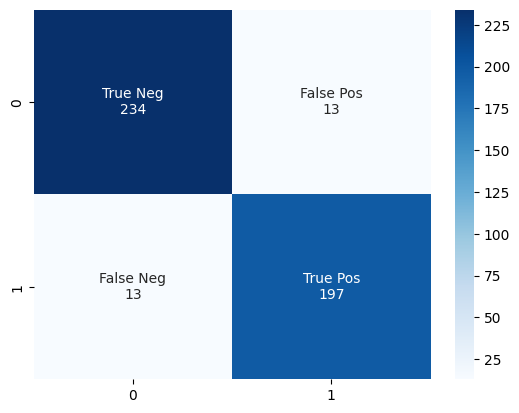

In [ ]:
# @title Confusion Matrix

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have the ground truth labels for the test data stored in "y_test"
# and the predictions made on the test data stored in "binary_predictions"

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# LIME


In [ ]:
#LBP, VGG16, Gabor Features SVC Experiments (RBF, POLY), (PCA, PCA & Feature Selection, Just LBP Features)

X_train = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/Cropped Images/X_train_cropped.npy')
y_train = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/VGG16 Features/y_train_vgg16.npy')
X_test = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/Cropped Images/X_test_cropped.npy')
y_test = np.load('/content/drive/MyDrive/LCD/candidates_and_annotations/VGG16 Features/y_test_vgg16.npy')

In [ ]:
!pip install lime

In [ ]:
import tensorflow as tf

# Replace 'your_model.h5' with the actual path to your HDF5 file
model_path = '/content/drive/MyDrive/LCD/candidates_and_annotations/CNN Approach/VGG16 Backbone 10-Fold/x_cropped_best_model_fold1.h5'

# Load the model
model = tf.keras.models.load_model(model_path)

# Now you can use the model for predictions or further training

In [ ]:
# @title LIME Base

"""
Contains abstract functionality for learning locally linear sparse model.
"""
import numpy as np
import scipy as sp
from sklearn.linear_model import Ridge, lars_path
from sklearn.utils import check_random_state


class LimeBase(object):
    """Class for learning a locally linear sparse model from perturbed data"""
    def __init__(self,
                 kernel_fn,
                 verbose=False,
                 random_state=None):
        """Init function

        Args:
            kernel_fn: function that transforms an array of distances into an
                        array of proximity values (floats).
            verbose: if true, print local prediction values from linear model.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        self.kernel_fn = kernel_fn
        self.verbose = verbose
        self.random_state = check_random_state(random_state)

    @staticmethod
    def generate_lars_path(weighted_data, weighted_labels):
        """Generates the lars path for weighted data.

        Args:
            weighted_data: data that has been weighted by kernel
            weighted_label: labels, weighted by kernel

        Returns:
            (alphas, coefs), both are arrays corresponding to the
            regularization parameter and coefficients, respectively
        """
        x_vector = weighted_data
        alphas, _, coefs = lars_path(x_vector,
                                     weighted_labels,
                                     method='lasso',
                                     verbose=False)
        return alphas, coefs

    def forward_selection(self, data, labels, weights, num_features):
        """Iteratively adds features to the model"""
        clf = Ridge(alpha=0, fit_intercept=True, random_state=self.random_state)
        used_features = []
        for _ in range(min(num_features, data.shape[1])):
            max_ = -100000000
            best = 0
            for feature in range(data.shape[1]):
                if feature in used_features:
                    continue
                clf.fit(data[:, used_features + [feature]], labels,
                        sample_weight=weights)
                score = clf.score(data[:, used_features + [feature]],
                                  labels,
                                  sample_weight=weights)
                if score > max_:
                    best = feature
                    max_ = score
            used_features.append(best)
        return np.array(used_features)

    def feature_selection(self, data, labels, weights, num_features, method):
        """Selects features for the model. see explain_instance_with_data to
           understand the parameters."""
        if method == 'none':
            return np.array(range(data.shape[1]))
        elif method == 'forward_selection':
            return self.forward_selection(data, labels, weights, num_features)
        elif method == 'highest_weights':
            clf = Ridge(alpha=0.01, fit_intercept=True,
                        random_state=self.random_state)
            clf.fit(data, labels, sample_weight=weights)

            coef = clf.coef_
            if sp.sparse.issparse(data):
                coef = sp.sparse.csr_matrix(clf.coef_)
                weighted_data = coef.multiply(data[0])
                # Note: most efficient to slice the data before reversing
                sdata = len(weighted_data.data)
                argsort_data = np.abs(weighted_data.data).argsort()
                # Edge case where data is more sparse than requested number of feature importances
                # In that case, we just pad with zero-valued features
                if sdata < num_features:
                    nnz_indexes = argsort_data[::-1]
                    indices = weighted_data.indices[nnz_indexes]
                    num_to_pad = num_features - sdata
                    indices = np.concatenate((indices, np.zeros(num_to_pad, dtype=indices.dtype)))
                    indices_set = set(indices)
                    pad_counter = 0
                    for i in range(data.shape[1]):
                        if i not in indices_set:
                            indices[pad_counter + sdata] = i
                            pad_counter += 1
                            if pad_counter >= num_to_pad:
                                break
                else:
                    nnz_indexes = argsort_data[sdata - num_features:sdata][::-1]
                    indices = weighted_data.indices[nnz_indexes]
                return indices
            else:
                weighted_data = coef * data[0]
                feature_weights = sorted(
                    zip(range(data.shape[1]), weighted_data),
                    key=lambda x: np.abs(x[1]),
                    reverse=True)
                return np.array([x[0] for x in feature_weights[:num_features]])
        elif method == 'lasso_path':
            weighted_data = ((data - np.average(data, axis=0, weights=weights))
                             * np.sqrt(weights[:, np.newaxis]))
            weighted_labels = ((labels - np.average(labels, weights=weights))
                               * np.sqrt(weights))
            nonzero = range(weighted_data.shape[1])
            _, coefs = self.generate_lars_path(weighted_data,
                                               weighted_labels)
            for i in range(len(coefs.T) - 1, 0, -1):
                nonzero = coefs.T[i].nonzero()[0]
                if len(nonzero) <= num_features:
                    break
            used_features = nonzero
            return used_features
        elif method == 'auto':
            if num_features <= 6:
                n_method = 'forward_selection'
            else:
                n_method = 'highest_weights'
            return self.feature_selection(data, labels, weights,
                                          num_features, n_method)

    def explain_instance_with_data(self,
                                   neighborhood_data,
                                   neighborhood_labels,
                                   distances,
                                   label,
                                   num_features,
                                   feature_selection='auto',
                                   model_regressor=None):
        """Takes perturbed data, labels and distances, returns explanation.

        Args:
            neighborhood_data: perturbed data, 2d array. first element is
                               assumed to be the original data point.
            neighborhood_labels: corresponding perturbed labels. should have as
                                 many columns as the number of possible labels.
            distances: distances to original data point.
            label: label for which we want an explanation
            num_features: maximum number of features in explanation
            feature_selection: how to select num_features. options are:
                'forward_selection': iteratively add features to the model.
                    This is costly when num_features is high
                'highest_weights': selects the features that have the highest
                    product of absolute weight * original data point when
                    learning with all the features
                'lasso_path': chooses features based on the lasso
                    regularization path
                'none': uses all features, ignores num_features
                'auto': uses forward_selection if num_features <= 6, and
                    'highest_weights' otherwise.
            model_regressor: sklearn regressor to use in explanation.
                Defaults to Ridge regression if None. Must have
                model_regressor.coef_ and 'sample_weight' as a parameter
                to model_regressor.fit()

        Returns:
            (intercept, exp, score, local_pred):
            intercept is a float.
            exp is a sorted list of tuples, where each tuple (x,y) corresponds
            to the feature id (x) and the local weight (y). The list is sorted
            by decreasing absolute value of y.
            score is the R^2 value of the returned explanation
            local_pred is the prediction of the explanation model on the original instance
        """

        weights = self.kernel_fn(distances)
        labels_column = neighborhood_labels[:, label]
        used_features = self.feature_selection(neighborhood_data,
                                               labels_column,
                                               weights,
                                               num_features,
                                               feature_selection)
        if model_regressor is None:
            model_regressor = Ridge(alpha=1, fit_intercept=True,
                                    random_state=self.random_state)
        easy_model = model_regressor
        easy_model.fit(neighborhood_data[:, used_features],
                       labels_column, sample_weight=weights)
        prediction_score = easy_model.score(
            neighborhood_data[:, used_features],
            labels_column, sample_weight=weights)

        local_pred = easy_model.predict(neighborhood_data[0, used_features].reshape(1, -1))

        if self.verbose:
            print('Intercept', easy_model.intercept_)
            print('Prediction_local', local_pred,)
            print('Right:', neighborhood_labels[0, label])
        return (easy_model.intercept_,
                sorted(zip(used_features, easy_model.coef_),
                       key=lambda x: np.abs(x[1]), reverse=True),
                prediction_score, local_pred)

In [ ]:
# @title Base Wrapper and Segmentation Algorithm

import types
from lime.utils.generic_utils import has_arg
from skimage.segmentation import felzenszwalb, slic, quickshift


class BaseWrapper(object):
    """Base class for LIME Scikit-Image wrapper


    Args:
        target_fn: callable function or class instance
        target_params: dict, parameters to pass to the target_fn


    'target_params' takes parameters required to instanciate the
        desired Scikit-Image class/model
    """

    def __init__(self, target_fn=None, **target_params):
        self.target_fn = target_fn
        self.target_params = target_params

    def _check_params(self, parameters):
        """Checks for mistakes in 'parameters'

        Args :
            parameters: dict, parameters to be checked

        Raises :
            ValueError: if any parameter is not a valid argument for the target function
                or the target function is not defined
            TypeError: if argument parameters is not iterable
         """
        a_valid_fn = []
        if self.target_fn is None:
            if callable(self):
                a_valid_fn.append(self.__call__)
            else:
                raise TypeError('invalid argument: tested object is not callable,\
                 please provide a valid target_fn')
        elif isinstance(self.target_fn, types.FunctionType) \
                or isinstance(self.target_fn, types.MethodType):
            a_valid_fn.append(self.target_fn)
        else:
            a_valid_fn.append(self.target_fn.__call__)

        if not isinstance(parameters, str):
            for p in parameters:
                for fn in a_valid_fn:
                    if has_arg(fn, p):
                        pass
                    else:
                        raise ValueError('{} is not a valid parameter'.format(p))
        else:
            raise TypeError('invalid argument: list or dictionnary expected')

    def set_params(self, **params):
        """Sets the parameters of this estimator.
        Args:
            **params: Dictionary of parameter names mapped to their values.

        Raises :
            ValueError: if any parameter is not a valid argument
                for the target function
        """
        self._check_params(params)
        self.target_params = params

    def filter_params(self, fn, override=None):
        """Filters `target_params` and return those in `fn`'s arguments.
        Args:
            fn : arbitrary function
            override: dict, values to override target_params
        Returns:
            result : dict, dictionary containing variables
            in both target_params and fn's arguments.
        """
        override = override or {}
        result = {}
        for name, value in self.target_params.items():
            if has_arg(fn, name):
                result.update({name: value})
        result.update(override)
        return result


class SegmentationAlgorithm(BaseWrapper):
    """ Define the image segmentation function based on Scikit-Image
            implementation and a set of provided parameters

        Args:
            algo_type: string, segmentation algorithm among the following:
                'quickshift', 'slic', 'felzenszwalb'
            target_params: dict, algorithm parameters (valid model paramters
                as define in Scikit-Image documentation)
    """

    def __init__(self, algo_type, **target_params):
        self.algo_type = algo_type
        if (self.algo_type == 'quickshift'):
            BaseWrapper.__init__(self, quickshift, **target_params)
            kwargs = self.filter_params(quickshift)
            self.set_params(**kwargs)
        elif (self.algo_type == 'felzenszwalb'):
            BaseWrapper.__init__(self, felzenszwalb, **target_params)
            kwargs = self.filter_params(felzenszwalb)
            self.set_params(**kwargs)
        elif (self.algo_type == 'slic'):
            BaseWrapper.__init__(self, slic, **target_params)
            kwargs = self.filter_params(slic)
            self.set_params(**kwargs)

    def __call__(self, *args):
        return self.target_fn(args[0], **self.target_params)

In [ ]:
# @title LIME Image
"""
Functions for explaining classifiers that use Image data.
"""
import copy
from functools import partial

import numpy as np
import sklearn
import sklearn.preprocessing
from sklearn.utils import check_random_state
from skimage.color import gray2rgb
from tqdm.auto import tqdm


class ImageExplanation(object):
    def __init__(self, image, segments):
        """Init function.

        Args:
            image: 3d numpy array
            segments: 2d numpy array, with the output from skimage.segmentation
        """
        self.image = image
        self.segments = segments
        self.intercept = {}
        self.local_exp = {}
        self.local_pred = None

    def get_image_and_mask(self, label, positive_only=True, negative_only=False, hide_rest=False,
                           num_features=5, min_weight=0.):
        """Init function.

        Args:
            label: label to explain
            positive_only: if True, only take superpixels that positively contribute to
                the prediction of the label.
            negative_only: if True, only take superpixels that negatively contribute to
                the prediction of the label. If false, and so is positive_only, then both
                negativey and positively contributions will be taken.
                Both can't be True at the same time
            hide_rest: if True, make the non-explanation part of the return
                image gray
            num_features: number of superpixels to include in explanation
            min_weight: minimum weight of the superpixels to include in explanation

        Returns:
            (image, mask), where image is a 3d numpy array and mask is a 2d
            numpy array that can be used with
            skimage.segmentation.mark_boundaries
        """
        if label not in self.local_exp:
            raise KeyError('Label not in explanation')
        if positive_only & negative_only:
            raise ValueError("Positive_only and negative_only cannot be true at the same time.")
        segments = self.segments
        image = self.image
        exp = self.local_exp[label]
        mask = np.zeros(segments.shape, segments.dtype)
        if hide_rest:
            temp = np.zeros(self.image.shape)
        else:
            temp = self.image.copy()
        if positive_only:
            fs = [x[0] for x in exp
                  if x[1] > 0 and x[1] > min_weight][:num_features]
        if negative_only:
            fs = [x[0] for x in exp
                  if x[1] < 0 and abs(x[1]) > min_weight][:num_features]
        if positive_only or negative_only:
            for f in fs:
                temp[segments == f] = image[segments == f].copy()
                mask[segments == f] = 1
            return temp, mask
        else:
            for f, w in exp[:num_features]:
                if np.abs(w) < min_weight:
                    continue
                c = 0 if w < 0 else 1
                mask[segments == f] = -1 if w < 0 else 1
                temp[segments == f] = image[segments == f].copy()
                temp[segments == f, c] = np.max(image)
            return temp, mask


class LimeImageExplainer(object):
    """Explains predictions on Image (i.e. matrix) data.
    For numerical features, perturb them by sampling from a Normal(0,1) and
    doing the inverse operation of mean-centering and scaling, according to the
    means and stds in the training data. For categorical features, perturb by
    sampling according to the training distribution, and making a binary
    feature that is 1 when the value is the same as the instance being
    explained."""

    def __init__(self, kernel_width=.25, kernel=None, verbose=False,
                 feature_selection='auto', random_state=None):
        """Init function.

        Args:
            kernel_width: kernel width for the exponential kernel.
            If None, defaults to sqrt(number of columns) * 0.75.
            kernel: similarity kernel that takes euclidean distances and kernel
                width as input and outputs weights in (0,1). If None, defaults to
                an exponential kernel.
            verbose: if true, print local prediction values from linear model
            feature_selection: feature selection method. can be
                'forward_selection', 'lasso_path', 'none' or 'auto'.
                See function 'explain_instance_with_data' in lime_base.py for
                details on what each of the options does.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        kernel_width = float(kernel_width)

        if kernel is None:
            def kernel(d, kernel_width):
                return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

        kernel_fn = partial(kernel, kernel_width=kernel_width)

        self.random_state = check_random_state(random_state)
        self.feature_selection = feature_selection
        self.base = LimeBase(kernel_fn, verbose, random_state=self.random_state)

    def explain_instance(self, image, classifier_fn, labels=(1,),
                         hide_color=None,
                         top_labels=5, num_features=100000, num_samples=1000,
                         batch_size=10,
                         segmentation_fn=None,
                         distance_metric='cosine',
                         model_regressor=None,
                         random_seed=None):
        """Generates explanations for a prediction.

        First, we generate neighborhood data by randomly perturbing features
        from the instance (see __data_inverse). We then learn locally weighted
        linear models on this neighborhood data to explain each of the classes
        in an interpretable way (see lime_base.py).

        Args:
            image: 3 dimension RGB image. If this is only two dimensional,
                we will assume it's a grayscale image and call gray2rgb.
            classifier_fn: classifier prediction probability function, which
                takes a numpy array and outputs prediction probabilities.  For
                ScikitClassifiers , this is classifier.predict_proba.
            labels: iterable with labels to be explained.
            hide_color: TODO
            top_labels: if not None, ignore labels and produce explanations for
                the K labels with highest prediction probabilities, where K is
                this parameter.
            num_features: maximum number of features present in explanation
            num_samples: size of the neighborhood to learn the linear model
            batch_size: TODO
            distance_metric: the distance metric to use for weights.
            model_regressor: sklearn regressor to use in explanation. Defaults
            to Ridge regression in LimeBase. Must have model_regressor.coef_
            and 'sample_weight' as a parameter to model_regressor.fit()
            segmentation_fn: SegmentationAlgorithm, wrapped skimage
            segmentation function
            random_seed: integer used as random seed for the segmentation
                algorithm. If None, a random integer, between 0 and 1000,
                will be generated using the internal random number generator.

        Returns:
            An ImageExplanation object (see lime_image.py) with the corresponding
            explanations.
        """
        if len(image.shape) == 2:
            image = gray2rgb(image)
        if random_seed is None:
            random_seed = self.random_state.randint(0, high=1000)

        if segmentation_fn is None:
            segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4,
                                                    max_dist=200, ratio=0.2,
                                                    random_seed=random_seed)
        try:
            segments = segmentation_fn(image)
        except ValueError as e:
            raise e

        fudged_image = image.copy()
        if hide_color is None:
            for x in np.unique(segments):
                fudged_image[segments == x] = (
                    np.mean(image[segments == x][:, 0]),
                    np.mean(image[segments == x][:, 1]),
                    np.mean(image[segments == x][:, 2]))
        else:
            fudged_image[:] = hide_color

        top = labels

        data, labels = self.data_labels(image, fudged_image, segments,
                                        classifier_fn, num_samples,
                                        batch_size=batch_size)

        distances = sklearn.metrics.pairwise_distances(
            data,
            data[0].reshape(1, -1),
            metric=distance_metric
        ).ravel()

        ret_exp = ImageExplanation(image, segments)
        if top_labels:
            top = np.argsort(labels[0])[-top_labels:]
            ret_exp.top_labels = list(top)
            ret_exp.top_labels.reverse()
        for label in top:
            (ret_exp.intercept[label],
             ret_exp.local_exp[label],
             ret_exp.score, ret_exp.local_pred) = self.base.explain_instance_with_data(
                data, labels, distances, label, num_features,
                model_regressor=model_regressor,
                feature_selection=self.feature_selection)
        return ret_exp

    def data_labels(self,
                    image,
                    fudged_image,
                    segments,
                    classifier_fn,
                    num_samples,
                    batch_size=10):
        """Generates images and predictions in the neighborhood of this image.

        Args:
            image: 3d numpy array, the image
            fudged_image: 3d numpy array, image to replace original image when
                superpixel is turned off
            segments: segmentation of the image
            classifier_fn: function that takes a list of images and returns a
                matrix of prediction probabilities
            num_samples: size of the neighborhood to learn the linear model
            batch_size: classifier_fn will be called on batches of this size.

        Returns:
            A tuple (data, labels), where:
                data: dense num_samples * num_superpixels
                labels: prediction probabilities matrix
        """
        n_features = np.unique(segments).shape[0]
        data = self.random_state.randint(0, 2, num_samples * n_features)\
            .reshape((num_samples, n_features))
        labels = []
        data[0, :] = 1
        imgs = []
        for row in tqdm(data):
            temp = copy.deepcopy(image)
            zeros = np.where(row == 0)[0]
            mask = np.zeros(segments.shape).astype(bool)
            for z in zeros:
                mask[segments == z] = True
            temp[mask] = fudged_image[mask]
            imgs.append(temp[:, :, 0])
            if len(imgs) == batch_size:
                preds = classifier_fn(np.array(imgs))
                labels.extend(preds)
                imgs = []
        if len(imgs) > 0:
            preds = classifier_fn(np.array(imgs))
            labels.extend(preds)
        return data, np.array(labels)


In [ ]:
import time
from skimage.segmentation import mark_boundaries

img_idx_to_explain = 32

explainer = LimeImageExplainer()
explanation_euclidean = explainer.explain_instance(X_train[img_idx_to_explain].astype('double'),
                                         model.predict, top_labels=2,
                                         hide_color=None, num_samples=256,
                                         distance_metric='euclidean')

explainer = LimeImageExplainer()
explanation_cosine = explainer.explain_instance(X_train[img_idx_to_explain].astype('double'),
                                         model.predict, top_labels=2,
                                         hide_color=None, num_samples=256,
                                         distance_metric='cosine')

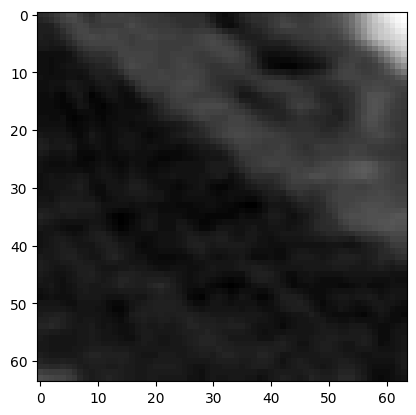

In [ ]:
plt.imshow(X_train[img_idx_to_explain], cmap='gray')

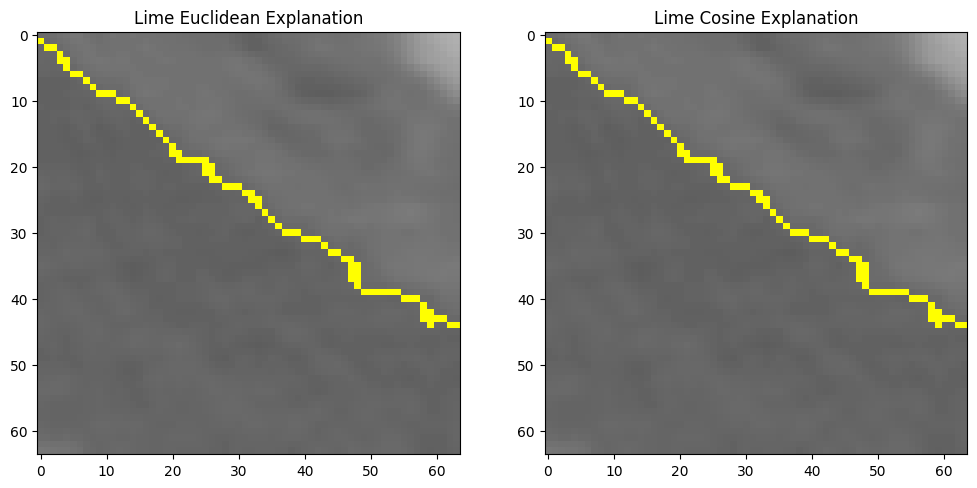

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Assuming explanation_euclidean, explanation_cosine, X_train, and img_idx_to_explain are defined

# Create a new figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Lime Euclidean Explanation
temp, mask = explanation_euclidean.get_image_and_mask(explanation_euclidean.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
# Plot the marked boundaries image with title "Lime Euclidean Explanation"
img_1 = mark_boundaries(X_train[img_idx_to_explain], mask)
axs[0].imshow(img_1)
axs[0].set_title("Lime Euclidean Explanation")

# Lime Cosine Explanation
temp, mask = explanation_cosine.get_image_and_mask(explanation_cosine.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
# Plot the marked boundaries image with title "Lime Cosine Explanation"
img_2 = mark_boundaries(X_train[img_idx_to_explain], mask)
axs[1].imshow(img_2)
axs[1].set_title("Lime Cosine Explanation")

# Display the plot
plt.show()

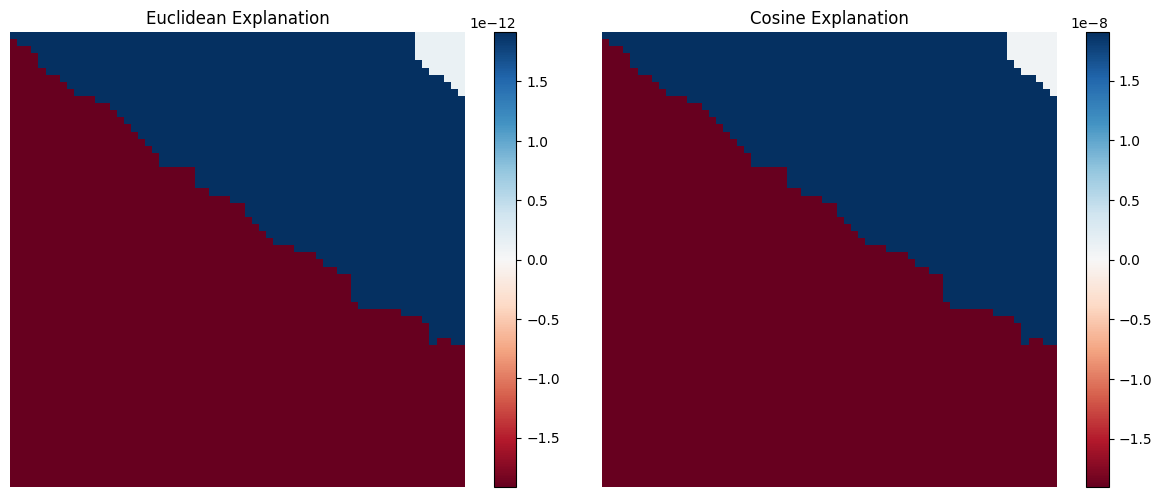

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have two explanation objects: explanation_euclidean and explanation_cosine

# Select the same class explained on the figures above for explanation_euclidean.
ind_euclidean = explanation_euclidean.top_labels[0]
dict_heatmap_euclidean = dict(explanation_euclidean.local_exp[ind_euclidean])
heatmap_euclidean = np.vectorize(dict_heatmap_euclidean.get)(explanation_euclidean.segments)

# Select the same class explained on the figures above for explanation_cosine.
ind_cosine = explanation_cosine.top_labels[0]
dict_heatmap_cosine = dict(explanation_cosine.local_exp[ind_cosine])
heatmap_cosine = np.vectorize(dict_heatmap_cosine.get)(explanation_cosine.segments)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for explanation_euclidean
im_euclidean = axes[0].imshow(heatmap_euclidean, cmap='RdBu', vmin=-heatmap_euclidean.max(), vmax=heatmap_euclidean.max())
axes[0].set_title('Euclidean Explanation')
axes[0].axis('off')
fig.colorbar(im_euclidean, ax=axes[0], orientation='vertical')

# Plot for explanation_cosine
im_cosine = axes[1].imshow(heatmap_cosine, cmap='RdBu', vmin=-heatmap_cosine.max(), vmax=heatmap_cosine.max())
axes[1].set_title('Cosine Explanation')
axes[1].axis('off')
fig.colorbar(im_cosine, ax=axes[1], orientation='vertical')

# Adjust layout
plt.tight_layout()
plt.show()
